In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import ttest_ind, kstest

from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.calibration import calibration_curve

from imblearn.under_sampling import RandomUnderSampler

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import lightgbm as lgm
from xgboost import XGBClassifier

from tabpfn import TabPFNClassifier

from lofo import LOFOImportance, Dataset, plot_importance

import optuna

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def competition_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1)/2

In [3]:
def lgb_metric(y_true, y_pred):
    return 'competition_log_loss', competition_log_loss(y_true, y_pred), False

In [4]:
train_df = pd.read_csv('train.csv')
greek_df = pd.read_csv('greeks.csv')
test_df = pd.read_csv('test.csv')

train_df.columns = [col.strip() for col in train_df.columns]
train_df['EJ'] = train_df['EJ'].map({'B' : 0, 'A':1})

test_df.columns = [col.strip() for col in test_df.columns]
test_df['EJ'] = test_df['EJ'].map({'B': 0, 'A' : 1})

In [5]:
int_denominators = {
 'AB': 0.004273,
 'AF': 0.00242,
 'AH': 0.008709,
 'AM': 0.003097,
 'AR': 0.005244,
 'AX': 0.008859,
 'AY': 0.000609,
 'AZ': 0.006302,
 'BC': 0.007028,
 'BD': 0.00799,
 'BN': 0.3531,
 'BP': 0.004239,
 'BQ': 0.002605,
 'BR': 0.006049,
 'BZ': 0.004267,
 'CB': 0.009191,
 'CC': 6.12e-06,
 'CD': 0.007928,
 'CF': 0.003041,
 'CH': 0.000398,
 'CL': 0.006365,
 'CR': 7.5e-05,
 'CS': 0.003487,
 'CU': 0.005517,
 'CW': 9.2e-05,
 'DA': 0.00388,
 'DE': 0.004435,
 'DF': 0.000351,
 'DH': 0.002733,
 'DI': 0.003765,
 'DL': 0.00212,
 'DN': 0.003412,
 'DU': 0.0013794,
 'DV': 0.00259,
 'DY': 0.004492,
 'EB': 0.007068,
 'EE': 0.004031,
 'EG': 0.006025,
 'EH': 0.006084,
 'EL': 0.000429,
 'EP': 0.009269,
 'EU': 0.005064,
 'FC': 0.005712,
 'FD': 0.005937,
 'FE': 0.007486,
 'FI': 0.005513,
 'FR': 0.00058,
 'FS': 0.006773,
 'GB': 0.009302,
 'GE': 0.004417,
 'GF': 0.004374,
 'GH': 0.003721,
 'GI': 0.002572
}
for k, v in int_denominators.items():
    train_df[k] = np.round(train_df[k]/v,1)
    
for k, v in int_denominators.items():
    test_df[k] = np.round(test_df[k]/v,1)

In [6]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,7.298162,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,0.173229,857.0,84.0,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,7.709560,1682.0,177.0,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,6.122162,857.0,42.0,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,8.153058,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1


In [7]:
greek_df.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [8]:
# getting the indices of the unknown dates
idx = greek_df[greek_df['Epsilon'] == 'Unknown'].index
train_df['unknown'] = [1 if x == 'Unknown' else 0 for x in greek_df['Epsilon']]

# adding the epsilon column to the train df and coercing errors
train_df['Epsilon'] = pd.to_datetime(greek_df['Epsilon'], errors='coerce')

# applying a mask and converting valid datetimes to ordinals
mask = pd.isnull(train_df['Epsilon'])
train_df.loc[~mask, 'Epsilon'] = train_df.loc[~mask, 'Epsilon'].apply(lambda x: x.toordinal())
train_df['Epsilon'] = train_df['Epsilon'].fillna(0).astype(int)

I built a classifier to predict whether a row had a missing date or not,  
but it wasn't able to outperform a naive prediction of the base rate (~0.23).  

In [9]:
def compare_class_box(column=None):
    
    pos = train_df[train_df['Class'] == 1]
    neg = train_df[train_df['Class'] == 0]
    
    sns.kdeplot(pos[column], color='blue')
    sns.kdeplot(neg[column], color='orange')

    # Display the plot
    plt.show()

In [10]:
class WeightedEns(BaseEstimator):
    def __init__(self):
        self.classifiers = [XGBClassifier(learning_rate=0.2, scale_pos_weight=4.7),
                            TabPFNClassifier(N_ensemble_configurations=64)]
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median')
    
    def fit(self, X, y):
        cls, y = np.unique(y, return_inverse=True)
        self.classes_ = cls
        X = self.imp.fit_transform(X)
        for cl in self.classifiers:
            cl.fit(X,y)
    
    def predict_proba(self, X):
        X = self.imp.transform(X)
        ps = np.stack([cl.predict_proba(X) for cl in self.classifiers])
        p = np.mean(ps,axis=0)
        class_0_est_instances = p[:,0].sum()
        others_est_instances = p[:,1:].sum()
        
        # reweighting the predictions for balanced log loss
        new_p = p * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(p.shape[1])]])
        return new_p / np.sum(new_p,axis=1,keepdims=1)

In [11]:
greek_df[['Alpha', 'Beta', 'Gamma', 'Delta']]

,Alpha,Beta,Gamma,Delta
0,B,C,G,D
1,A,C,M,B
2,A,C,M,B
3,A,C,M,B
4,D,B,F,B
...,...,...,...,...
612,A,B,M,B
613,A,B,M,B
614,A,C,M,B
615,A,C,M,B


In [47]:
# using the kolmogorov-smirnoff test to find
# columns where the distributions differ
# by target class (1/0)

diff_distributions = []

for col in train_df.select_dtypes('number').columns[:-4]:
    sample1 = train_df.query("Class == 1")[col].dropna()
    sample2 = train_df.query("Class == 0")[col].dropna()
    tstat, pval = kstest(sample1, sample2)
    
    if pval <= 0.05:
        diff_distributions.append(col)

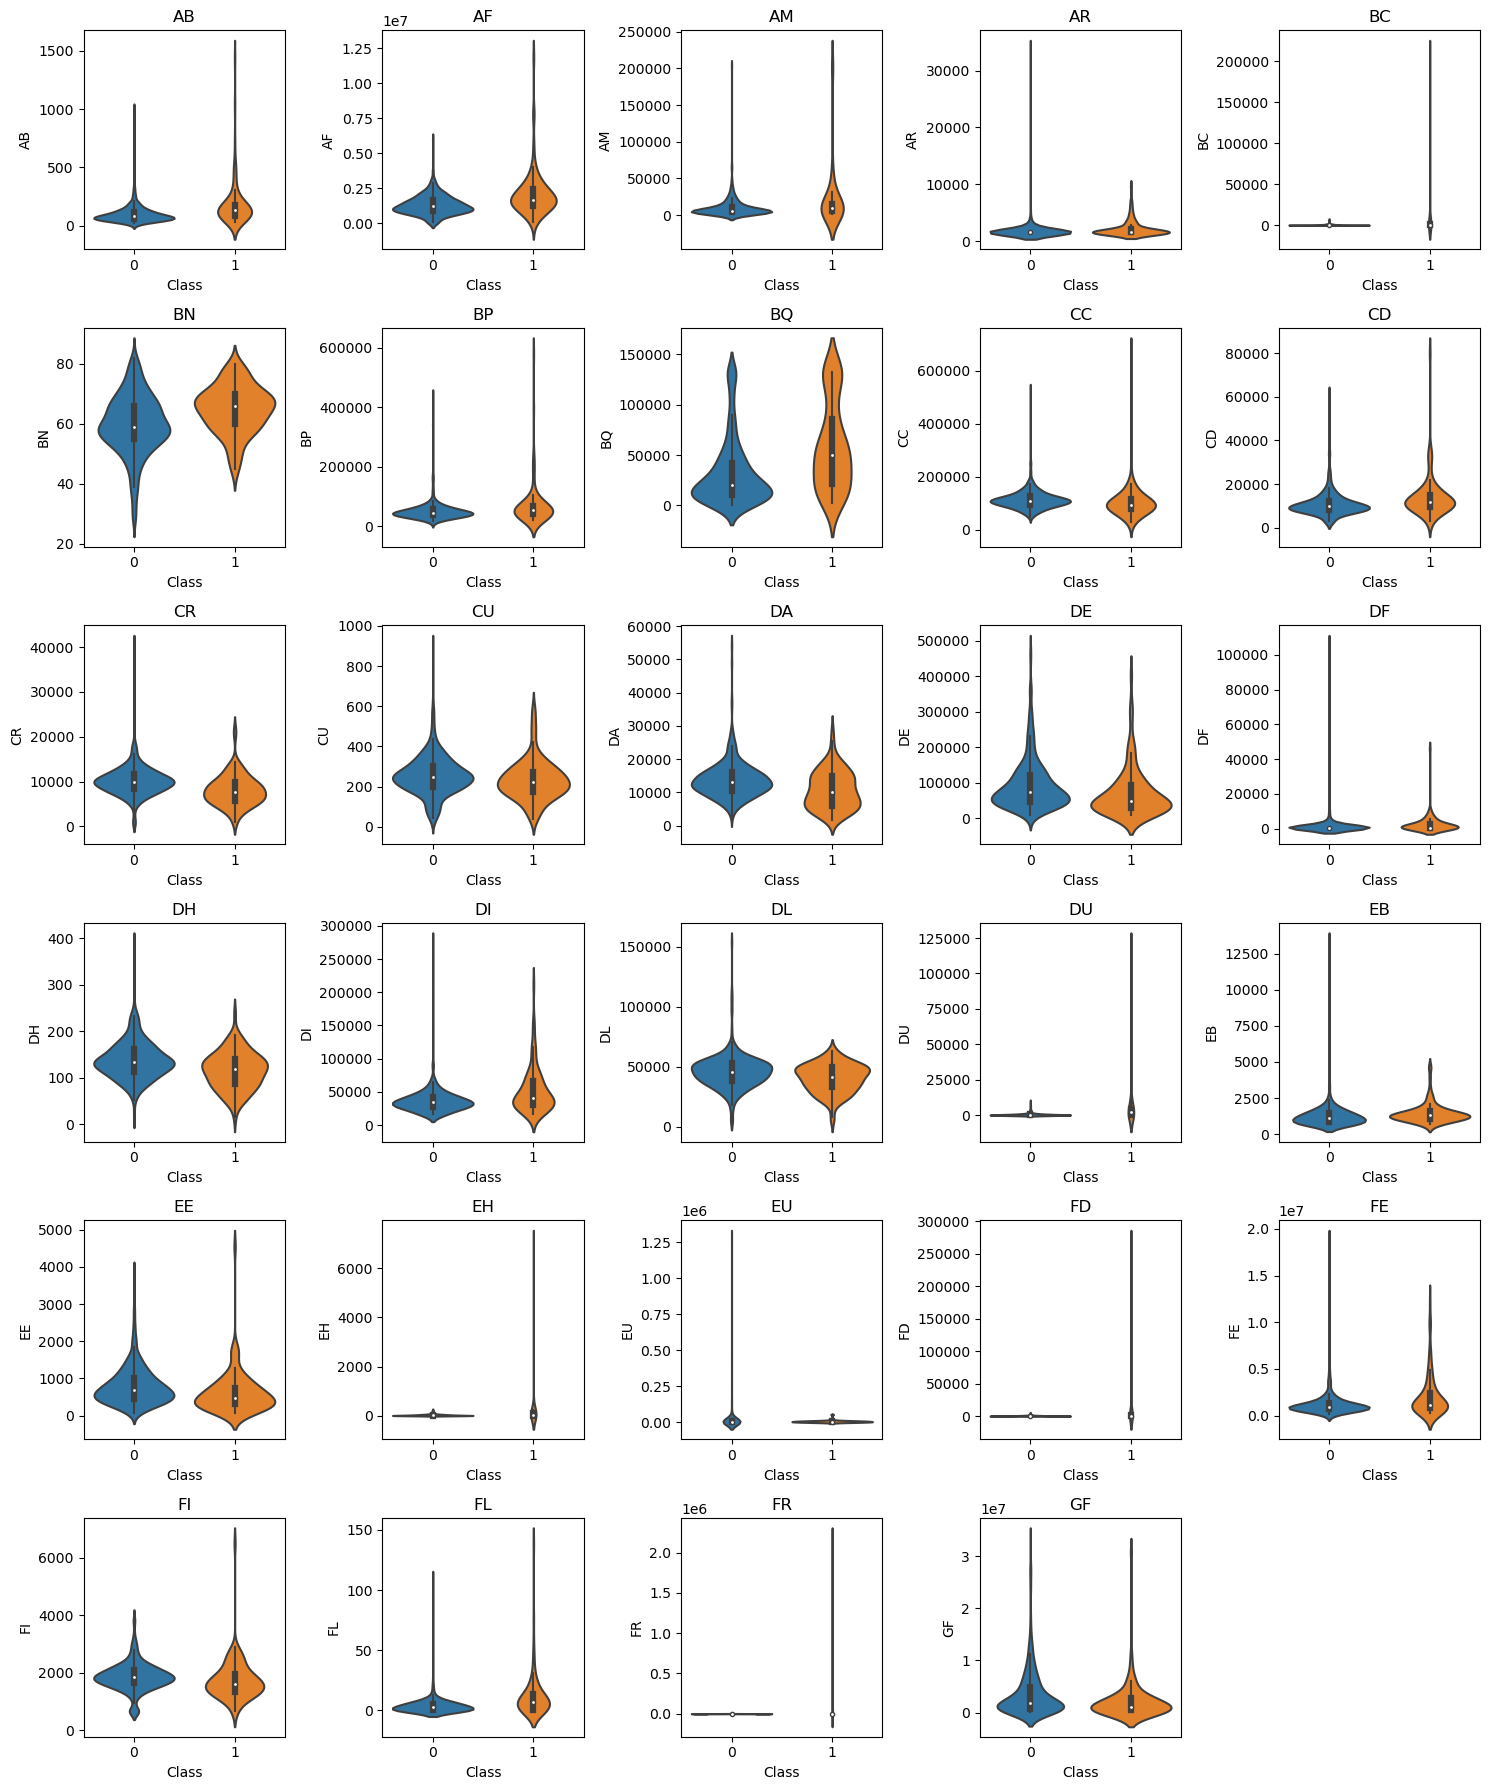

In [48]:
# plotting the distributions that differ
diff_distributions.extend(['Class'])

fig, axes = plt.subplots(6, 5, figsize=(15, 18))
axes = axes.flatten()

for i, column in enumerate(train_df[diff_distributions].columns[:-1]):

    sns.violinplot(x='Class', y=column, data=train_df[diff_distributions], ax=axes[i])
    axes[i].set_title(f"{column}")

# remove empty plots
for j in range(i+1, 6 * 5):
    fig.delaxes(axes[j])


fig.tight_layout()
plt.show()

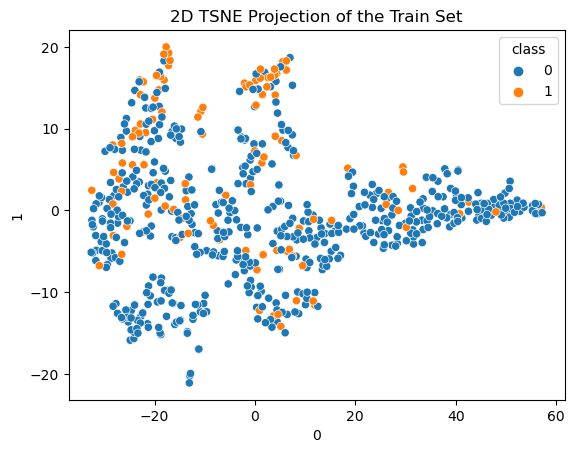

In [14]:
# clustering with TSNE to create a 2d plot. nothing
# stands out 
tsne = TSNE(n_components=2, random_state=442)

xformed = pd.DataFrame(
    tsne
    .fit_transform(train_df
                   .drop(columns=['Id','Class', 'unknown'])
                   .fillna(train_df.median(numeric_only=True)))
)

xformed['class'] = train_df['Class'].values

sns.scatterplot(x=0, y=1, data=xformed, hue='class')

plt.title("2D TSNE Projection of the Train Set")
plt.show()

In [15]:
# finding outliers to see if the models improve
# when they're excluded from the train sets 
from sklearn.ensemble import IsolationForest

# fitting outlier model
clf = IsolationForest()
clf.fit(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon']).fillna(train_df.median()))

# getting the outlier preds
outlier_preds = (
    clf
    .predict(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon']).fillna(train_df.median(numeric_only=True))
            )
)

# the indices of the outliers
outlier_idx = (np.where(outlier_preds < 0)[0])

C:\Users\yaobv\AppData\Local\Temp\ipykernel_7412\487782852.py:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  clf.fit(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon']).fillna(train_df.median()))


In [24]:
# cross-validation loop to train several models

balance_score = []
fold_scores = []
fold_idxs = []
oofs = []
svc_oofs = []
xgb_oofs = []
tab_oofs = []

for n in range(25):

    skf = StratifiedKFold(n_splits=10, shuffle=True)
    ml_skf = MultilabelStratifiedKFold(n_splits=10, shuffle=True)

    X = train_df.drop(columns=['EJ']).copy()
    y = train_df['Class'].values
    
#     greek_df.iloc[:,1:-1]

    models = {}
    oof = np.zeros(len(X))
    xgb_oof = np.zeros(len(X))
    tab_oof = np.zeros(len(X))
    svc_oof = np.zeros(len(X))

    for i, (train, val) in enumerate(ml_skf.split(X, greek_df.iloc[:,1:-1])):
            
        # if we're dropping outliers from train, we can use the outlier 
        # idx above. never drop them from validation.
#         train = [i for i in train if i not in outlier_idx]

        train_x = X.iloc[train].drop(columns=['Id', 'Class']).copy()
        train_y = y[train]

        # getting the id values
        val_x = X.iloc[val].drop(columns=['Id', 'Class']).copy()
        val_y = y[val]
        
        # training the lgbm classifier
    
        
        
        model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 5000,
                           early_stopping_rounds=300,
                           subsample=0.7,
                           colsample_bytree=0.6,
                           max_depth=8,
                           class_weight='balanced',
                           metric='None',
                           is_unbalance=True)
        
        
        model.fit(train_x, train_y,
                  eval_set=[(val_x, val_y)],
                  eval_metric=lgb_metric,
                  early_stopping_rounds=300,
                  verbose=0)
        
        # training the SVC
        
        svc = SVC(C=5, probability=True, class_weight='balanced')
        svc_pipeline = make_pipeline(SimpleImputer(), StandardScaler(), svc)
        
        svc_pipeline.fit(train_x, train_y)
        
        # training xgb model
        
        xgb_model = XGBClassifier(learning_rate=0.06, scale_pos_weight=4.7)
        
        xgb_model.fit(train_x, train_y, eval_set=[(val_x, val_y)])
        
        preds = model.predict_proba(val_x)[:,1]        
        svc_preds = svc_pipeline.predict_proba(val_x)[:,1]
        xgb_preds = xgb_model.predict_proba(val_x)[:,1]
    
        oof[val] = preds
        models[f'model_{i}'] = model
        
        svc_oof[val] = svc_preds
        
        xgb_oof[val] = xgb_preds
        
        fold_scores.append(competition_log_loss(val_y, preds))
        fold_idxs.append([train, val])

    balance_score.append(competition_log_loss(y, oof))
    oofs.append(oof)
    svc_oofs.append(svc_oof)
    xgb_oofs.append(xgb_oof)
#     tab_oofs.append(tab_oof)

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=300, early_stopping_rounds=300 will be ignored. Current value: early_stopping_round=300
[0]	validation_0-logloss:0.65371
[1]	validation_0-logloss:0.61932
[2]	validation_0-logloss:0.58830
[3]	validation_0-logloss:0.55966
[4]	validation_0-logloss:0.53370
[5]	validation_0-logloss:0.51074
[6]	validation_0-logloss:0.49054
[7]	validation_0-logloss:0.47177
[8]	validation_0-logloss:0.45364
[9]	validation_0-logloss:0.43922
[10]	validation_0-logloss:0.42391
[11]	validation_0-logloss:0.41302
[12]	validation_0-logloss:0.40055
[13]	validation_0-logloss:0.38944
[14]	validation_0-logloss:0.38402
[15]	validation_0-logloss:0.37658
[16]	validation_0-logloss:0.36343
[17]	validation_0-logloss:0.35696
[18]	validation_0-logloss:0.35015
[19]	validation_0-logloss:0.33876
[20]	validation_0-logloss:0.33007
[21]	validation_0-logloss:0.31959
[22]	validation_0-logloss:0.31424
[23]	validation_0-logloss:0.30951
[24]	validation_0-logloss:0.30477
[25]	validation_0-loglo

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65882
[1]	validation_0-logloss:0.62528
[2]	validation_0-logloss:0.59255
[3]	validation_0-logloss:0.56399
[4]	validation_0-logloss:0.54054
[5]	validation_0-logloss:0.52355
[6]	validation_0-logloss:0.50849
[7]	validation_0-logloss:0.49140
[8]	validation_0-logloss:0.48021
[9]	validation_0-logloss:0.47037
[10]	validation_0-logloss:0.45851
[11]	validation_0-logloss:0.44754
[12]	validation_0-logloss:0.43848
[13]	validation_0-logloss:0.42945
[14]	validation_0-logloss:0.42177
[15]	validation_0-logloss:0.40981
[16]	validation_0-logloss:0.40295
[17]	validation_0-logloss:0.39267
[18]	validation_0-logloss:0.38119
[19]	validation_0-logloss:0.37587
[20]	validation_0-logloss:0.36689
[21]	validation_0-logloss:0.36317
[22]	validation_0-logloss:0.35331
[23]	validation_0-logloss:0.34717
[24]	validation_0-logloss:0.34592
[25]	validation_0-logloss:0.33983
[26]	validation_0-logloss:0.33951
[27]	validation_0-logloss:0.34057
[28]	validation_0-logloss:0.33718
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65398
[1]	validation_0-logloss:0.62123
[2]	validation_0-logloss:0.58887
[3]	validation_0-logloss:0.56054
[4]	validation_0-logloss:0.53305
[5]	validation_0-logloss:0.50881
[6]	validation_0-logloss:0.48946
[7]	validation_0-logloss:0.46957
[8]	validation_0-logloss:0.45266
[9]	validation_0-logloss:0.43723
[10]	validation_0-logloss:0.41903
[11]	validation_0-logloss:0.40410
[12]	validation_0-logloss:0.39268
[13]	validation_0-logloss:0.37744
[14]	validation_0-logloss:0.36827
[15]	validation_0-logloss:0.35822
[16]	validation_0-logloss:0.35061
[17]	validation_0-logloss:0.34272
[18]	validation_0-logloss:0.33288
[19]	validation_0-logloss:0.32584
[20]	validation_0-logloss:0.31964
[21]	validation_0-logloss:0.31102
[22]	validation_0-logloss:0.30488
[23]	validation_0-logloss:0.30056
[24]	validation_0-logloss:0.29569
[25]	validation_0-logloss:0.28957
[26]	validation_0-logloss:0.28404
[27]	validation_0-logloss:0.27874
[28]	validation_0-logloss:0.27602
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64528
[1]	validation_0-logloss:0.60463
[2]	validation_0-logloss:0.57046
[3]	validation_0-logloss:0.53937
[4]	validation_0-logloss:0.51022
[5]	validation_0-logloss:0.48590
[6]	validation_0-logloss:0.46153
[7]	validation_0-logloss:0.44077
[8]	validation_0-logloss:0.41882
[9]	validation_0-logloss:0.40315
[10]	validation_0-logloss:0.38578
[11]	validation_0-logloss:0.37025
[12]	validation_0-logloss:0.35761
[13]	validation_0-logloss:0.34443
[14]	validation_0-logloss:0.33419
[15]	validation_0-logloss:0.32451
[16]	validation_0-logloss:0.31514
[17]	validation_0-logloss:0.30542
[18]	validation_0-logloss:0.29679
[19]	validation_0-logloss:0.28877
[20]	validation_0-logloss:0.28177
[21]	validation_0-logloss:0.27441
[22]	validation_0-logloss:0.26687
[23]	validation_0-logloss:0.26001
[24]	validation_0-logloss:0.25392
[25]	validation_0-logloss:0.24676
[26]	validation_0-logloss:0.23840
[27]	validation_0-logloss:0.23042
[28]	validation_0-logloss:0.22340
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65401
[1]	validation_0-logloss:0.62031
[2]	validation_0-logloss:0.58833
[3]	validation_0-logloss:0.56202
[4]	validation_0-logloss:0.53885
[5]	validation_0-logloss:0.52085
[6]	validation_0-logloss:0.50453
[7]	validation_0-logloss:0.49053
[8]	validation_0-logloss:0.47803
[9]	validation_0-logloss:0.46316
[10]	validation_0-logloss:0.45157
[11]	validation_0-logloss:0.43782
[12]	validation_0-logloss:0.43014
[13]	validation_0-logloss:0.41921
[14]	validation_0-logloss:0.40944
[15]	validation_0-logloss:0.40104
[16]	validation_0-logloss:0.39299
[17]	validation_0-logloss:0.38560
[18]	validation_0-logloss:0.37988
[19]	validation_0-logloss:0.37642
[20]	validation_0-logloss:0.36937
[21]	validation_0-logloss:0.36409
[22]	validation_0-logloss:0.35825
[23]	validation_0-logloss:0.35244
[24]	validation_0-logloss:0.34727
[25]	validation_0-logloss:0.34140
[26]	validation_0-logloss:0.33773
[27]	validation_0-logloss:0.33371
[28]	validation_0-logloss:0.33078
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65768
[1]	validation_0-logloss:0.63176
[2]	validation_0-logloss:0.60962
[3]	validation_0-logloss:0.58429
[4]	validation_0-logloss:0.56206
[5]	validation_0-logloss:0.53916
[6]	validation_0-logloss:0.51796
[7]	validation_0-logloss:0.50176
[8]	validation_0-logloss:0.49153
[9]	validation_0-logloss:0.48256
[10]	validation_0-logloss:0.46361
[11]	validation_0-logloss:0.44464
[12]	validation_0-logloss:0.43511
[13]	validation_0-logloss:0.42116
[14]	validation_0-logloss:0.40908
[15]	validation_0-logloss:0.39490
[16]	validation_0-logloss:0.38160
[17]	validation_0-logloss:0.36640
[18]	validation_0-logloss:0.35609
[19]	validation_0-logloss:0.35341
[20]	validation_0-logloss:0.34390
[21]	validation_0-logloss:0.33238
[22]	validation_0-logloss:0.32445
[23]	validation_0-logloss:0.31402
[24]	validation_0-logloss:0.30764
[25]	validation_0-logloss:0.30098
[26]	validation_0-logloss:0.29084
[27]	validation_0-logloss:0.28484
[28]	validation_0-logloss:0.27873
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64906
[1]	validation_0-logloss:0.61019
[2]	validation_0-logloss:0.57508
[3]	validation_0-logloss:0.54442
[4]	validation_0-logloss:0.51677
[5]	validation_0-logloss:0.48997
[6]	validation_0-logloss:0.46399
[7]	validation_0-logloss:0.44198
[8]	validation_0-logloss:0.42125
[9]	validation_0-logloss:0.40171
[10]	validation_0-logloss:0.38342
[11]	validation_0-logloss:0.37003
[12]	validation_0-logloss:0.35449
[13]	validation_0-logloss:0.34038
[14]	validation_0-logloss:0.32742
[15]	validation_0-logloss:0.31511
[16]	validation_0-logloss:0.30437
[17]	validation_0-logloss:0.29338
[18]	validation_0-logloss:0.28571
[19]	validation_0-logloss:0.27687
[20]	validation_0-logloss:0.27149
[21]	validation_0-logloss:0.26559
[22]	validation_0-logloss:0.25981
[23]	validation_0-logloss:0.25267
[24]	validation_0-logloss:0.24799
[25]	validation_0-logloss:0.24056
[26]	validation_0-logloss:0.23695
[27]	validation_0-logloss:0.23433
[28]	validation_0-logloss:0.22996
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64773
[1]	validation_0-logloss:0.60818
[2]	validation_0-logloss:0.57097
[3]	validation_0-logloss:0.53723
[4]	validation_0-logloss:0.50900
[5]	validation_0-logloss:0.48192
[6]	validation_0-logloss:0.45652
[7]	validation_0-logloss:0.43494
[8]	validation_0-logloss:0.41593
[9]	validation_0-logloss:0.39690
[10]	validation_0-logloss:0.38097
[11]	validation_0-logloss:0.36765
[12]	validation_0-logloss:0.35186
[13]	validation_0-logloss:0.33988
[14]	validation_0-logloss:0.32779
[15]	validation_0-logloss:0.31623
[16]	validation_0-logloss:0.30749
[17]	validation_0-logloss:0.29774
[18]	validation_0-logloss:0.28908
[19]	validation_0-logloss:0.28181
[20]	validation_0-logloss:0.27416
[21]	validation_0-logloss:0.26751
[22]	validation_0-logloss:0.26034
[23]	validation_0-logloss:0.25383
[24]	validation_0-logloss:0.24778
[25]	validation_0-logloss:0.24282
[26]	validation_0-logloss:0.23632
[27]	validation_0-logloss:0.23265
[28]	validation_0-logloss:0.22808
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64857
[1]	validation_0-logloss:0.60859
[2]	validation_0-logloss:0.57316
[3]	validation_0-logloss:0.54048
[4]	validation_0-logloss:0.51201
[5]	validation_0-logloss:0.48467
[6]	validation_0-logloss:0.45917
[7]	validation_0-logloss:0.43662
[8]	validation_0-logloss:0.41426
[9]	validation_0-logloss:0.39645
[10]	validation_0-logloss:0.37791
[11]	validation_0-logloss:0.36280
[12]	validation_0-logloss:0.34748
[13]	validation_0-logloss:0.33254
[14]	validation_0-logloss:0.31892
[15]	validation_0-logloss:0.30706
[16]	validation_0-logloss:0.29555
[17]	validation_0-logloss:0.28489
[18]	validation_0-logloss:0.27459
[19]	validation_0-logloss:0.26684
[20]	validation_0-logloss:0.25710
[21]	validation_0-logloss:0.24869
[22]	validation_0-logloss:0.24029
[23]	validation_0-logloss:0.23354
[24]	validation_0-logloss:0.22760
[25]	validation_0-logloss:0.22068
[26]	validation_0-logloss:0.21506
[27]	validation_0-logloss:0.21052
[28]	validation_0-logloss:0.20517
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64535
[1]	validation_0-logloss:0.60482
[2]	validation_0-logloss:0.56667
[3]	validation_0-logloss:0.53229
[4]	validation_0-logloss:0.50134
[5]	validation_0-logloss:0.47400
[6]	validation_0-logloss:0.44820
[7]	validation_0-logloss:0.42734
[8]	validation_0-logloss:0.41006
[9]	validation_0-logloss:0.39187
[10]	validation_0-logloss:0.37542
[11]	validation_0-logloss:0.35991
[12]	validation_0-logloss:0.34562
[13]	validation_0-logloss:0.33346
[14]	validation_0-logloss:0.32153
[15]	validation_0-logloss:0.31051
[16]	validation_0-logloss:0.30029
[17]	validation_0-logloss:0.29210
[18]	validation_0-logloss:0.28278
[19]	validation_0-logloss:0.27373
[20]	validation_0-logloss:0.26495
[21]	validation_0-logloss:0.25754
[22]	validation_0-logloss:0.25108
[23]	validation_0-logloss:0.24355
[24]	validation_0-logloss:0.23818
[25]	validation_0-logloss:0.23030
[26]	validation_0-logloss:0.22315
[27]	validation_0-logloss:0.21854
[28]	validation_0-logloss:0.21354
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65197
[1]	validation_0-logloss:0.61493
[2]	validation_0-logloss:0.58215
[3]	validation_0-logloss:0.55393
[4]	validation_0-logloss:0.52668
[5]	validation_0-logloss:0.50245
[6]	validation_0-logloss:0.47997
[7]	validation_0-logloss:0.46128
[8]	validation_0-logloss:0.44084
[9]	validation_0-logloss:0.42439
[10]	validation_0-logloss:0.41138
[11]	validation_0-logloss:0.39748
[12]	validation_0-logloss:0.38316
[13]	validation_0-logloss:0.36938
[14]	validation_0-logloss:0.35764
[15]	validation_0-logloss:0.34588
[16]	validation_0-logloss:0.33838
[17]	validation_0-logloss:0.33266
[18]	validation_0-logloss:0.32408
[19]	validation_0-logloss:0.31648
[20]	validation_0-logloss:0.30824
[21]	validation_0-logloss:0.30380
[22]	validation_0-logloss:0.29700
[23]	validation_0-logloss:0.29156
[24]	validation_0-logloss:0.28681
[25]	validation_0-logloss:0.28443
[26]	validation_0-logloss:0.28070
[27]	validation_0-logloss:0.27891
[28]	validation_0-logloss:0.27499
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64425
[1]	validation_0-logloss:0.60050
[2]	validation_0-logloss:0.56237
[3]	validation_0-logloss:0.52638
[4]	validation_0-logloss:0.49677
[5]	validation_0-logloss:0.46931
[6]	validation_0-logloss:0.44360
[7]	validation_0-logloss:0.42200
[8]	validation_0-logloss:0.40017
[9]	validation_0-logloss:0.38097
[10]	validation_0-logloss:0.36421
[11]	validation_0-logloss:0.34853
[12]	validation_0-logloss:0.33179
[13]	validation_0-logloss:0.31696
[14]	validation_0-logloss:0.30562
[15]	validation_0-logloss:0.29273
[16]	validation_0-logloss:0.28094
[17]	validation_0-logloss:0.27082
[18]	validation_0-logloss:0.26077
[19]	validation_0-logloss:0.25100
[20]	validation_0-logloss:0.24213
[21]	validation_0-logloss:0.23423
[22]	validation_0-logloss:0.22673
[23]	validation_0-logloss:0.21987
[24]	validation_0-logloss:0.21361
[25]	validation_0-logloss:0.20821
[26]	validation_0-logloss:0.20296
[27]	validation_0-logloss:0.19826
[28]	validation_0-logloss:0.19246
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65688
[1]	validation_0-logloss:0.62258
[2]	validation_0-logloss:0.58902
[3]	validation_0-logloss:0.55743
[4]	validation_0-logloss:0.52784
[5]	validation_0-logloss:0.49940
[6]	validation_0-logloss:0.48099
[7]	validation_0-logloss:0.45435
[8]	validation_0-logloss:0.43147
[9]	validation_0-logloss:0.41179
[10]	validation_0-logloss:0.39220
[11]	validation_0-logloss:0.37637
[12]	validation_0-logloss:0.36109
[13]	validation_0-logloss:0.34729
[14]	validation_0-logloss:0.33399
[15]	validation_0-logloss:0.32257
[16]	validation_0-logloss:0.30977
[17]	validation_0-logloss:0.29651
[18]	validation_0-logloss:0.28358
[19]	validation_0-logloss:0.27397
[20]	validation_0-logloss:0.26426
[21]	validation_0-logloss:0.25684
[22]	validation_0-logloss:0.25055
[23]	validation_0-logloss:0.24129
[24]	validation_0-logloss:0.23367
[25]	validation_0-logloss:0.22517
[26]	validation_0-logloss:0.21781
[27]	validation_0-logloss:0.21056
[28]	validation_0-logloss:0.20240
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65493
[1]	validation_0-logloss:0.61859
[2]	validation_0-logloss:0.58632
[3]	validation_0-logloss:0.56020
[4]	validation_0-logloss:0.53612
[5]	validation_0-logloss:0.51499
[6]	validation_0-logloss:0.49319
[7]	validation_0-logloss:0.47190
[8]	validation_0-logloss:0.45238
[9]	validation_0-logloss:0.43770
[10]	validation_0-logloss:0.42190
[11]	validation_0-logloss:0.41338
[12]	validation_0-logloss:0.39904
[13]	validation_0-logloss:0.38482
[14]	validation_0-logloss:0.37133
[15]	validation_0-logloss:0.36028
[16]	validation_0-logloss:0.35067
[17]	validation_0-logloss:0.34267
[18]	validation_0-logloss:0.33295
[19]	validation_0-logloss:0.32643
[20]	validation_0-logloss:0.31998
[21]	validation_0-logloss:0.31037
[22]	validation_0-logloss:0.30450
[23]	validation_0-logloss:0.30027
[24]	validation_0-logloss:0.29433
[25]	validation_0-logloss:0.28844
[26]	validation_0-logloss:0.28415
[27]	validation_0-logloss:0.27881
[28]	validation_0-logloss:0.27418
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64642
[1]	validation_0-logloss:0.60720
[2]	validation_0-logloss:0.56992
[3]	validation_0-logloss:0.53640
[4]	validation_0-logloss:0.50887
[5]	validation_0-logloss:0.48653
[6]	validation_0-logloss:0.46615
[7]	validation_0-logloss:0.44625
[8]	validation_0-logloss:0.43151
[9]	validation_0-logloss:0.41921
[10]	validation_0-logloss:0.40904
[11]	validation_0-logloss:0.39473
[12]	validation_0-logloss:0.38349
[13]	validation_0-logloss:0.37547
[14]	validation_0-logloss:0.36475
[15]	validation_0-logloss:0.35426
[16]	validation_0-logloss:0.34320
[17]	validation_0-logloss:0.33597
[18]	validation_0-logloss:0.32820
[19]	validation_0-logloss:0.32097
[20]	validation_0-logloss:0.31725
[21]	validation_0-logloss:0.30835
[22]	validation_0-logloss:0.30289
[23]	validation_0-logloss:0.29531
[24]	validation_0-logloss:0.28823
[25]	validation_0-logloss:0.28213
[26]	validation_0-logloss:0.27589
[27]	validation_0-logloss:0.27018
[28]	validation_0-logloss:0.26531
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65276
[1]	validation_0-logloss:0.61809
[2]	validation_0-logloss:0.58715
[3]	validation_0-logloss:0.56345
[4]	validation_0-logloss:0.53935
[5]	validation_0-logloss:0.51948
[6]	validation_0-logloss:0.50070
[7]	validation_0-logloss:0.48521
[8]	validation_0-logloss:0.47108
[9]	validation_0-logloss:0.45924
[10]	validation_0-logloss:0.44765
[11]	validation_0-logloss:0.43771
[12]	validation_0-logloss:0.42905
[13]	validation_0-logloss:0.42123
[14]	validation_0-logloss:0.41390
[15]	validation_0-logloss:0.40788
[16]	validation_0-logloss:0.40407
[17]	validation_0-logloss:0.39965
[18]	validation_0-logloss:0.39425
[19]	validation_0-logloss:0.38911
[20]	validation_0-logloss:0.38591
[21]	validation_0-logloss:0.38385
[22]	validation_0-logloss:0.38115
[23]	validation_0-logloss:0.37998
[24]	validation_0-logloss:0.37753
[25]	validation_0-logloss:0.37652
[26]	validation_0-logloss:0.37360
[27]	validation_0-logloss:0.37200
[28]	validation_0-logloss:0.37067
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65815
[1]	validation_0-logloss:0.62435
[2]	validation_0-logloss:0.59658
[3]	validation_0-logloss:0.56762
[4]	validation_0-logloss:0.54754
[5]	validation_0-logloss:0.53073
[6]	validation_0-logloss:0.51184
[7]	validation_0-logloss:0.49775
[8]	validation_0-logloss:0.47834
[9]	validation_0-logloss:0.46838
[10]	validation_0-logloss:0.45199
[11]	validation_0-logloss:0.44185
[12]	validation_0-logloss:0.43404
[13]	validation_0-logloss:0.42338
[14]	validation_0-logloss:0.41605
[15]	validation_0-logloss:0.40825
[16]	validation_0-logloss:0.40270
[17]	validation_0-logloss:0.39528
[18]	validation_0-logloss:0.38630
[19]	validation_0-logloss:0.38021
[20]	validation_0-logloss:0.37227
[21]	validation_0-logloss:0.36673
[22]	validation_0-logloss:0.35967
[23]	validation_0-logloss:0.35341
[24]	validation_0-logloss:0.34540
[25]	validation_0-logloss:0.34091
[26]	validation_0-logloss:0.33293
[27]	validation_0-logloss:0.33077
[28]	validation_0-logloss:0.32443
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64854
[1]	validation_0-logloss:0.60993
[2]	validation_0-logloss:0.57551
[3]	validation_0-logloss:0.54689
[4]	validation_0-logloss:0.52133
[5]	validation_0-logloss:0.49610
[6]	validation_0-logloss:0.47398
[7]	validation_0-logloss:0.45309
[8]	validation_0-logloss:0.43536
[9]	validation_0-logloss:0.41971
[10]	validation_0-logloss:0.40428
[11]	validation_0-logloss:0.38556
[12]	validation_0-logloss:0.36916
[13]	validation_0-logloss:0.35601
[14]	validation_0-logloss:0.34180
[15]	validation_0-logloss:0.33205
[16]	validation_0-logloss:0.32025
[17]	validation_0-logloss:0.30664
[18]	validation_0-logloss:0.29681
[19]	validation_0-logloss:0.28650
[20]	validation_0-logloss:0.27835
[21]	validation_0-logloss:0.26780
[22]	validation_0-logloss:0.25893
[23]	validation_0-logloss:0.25197
[24]	validation_0-logloss:0.24549
[25]	validation_0-logloss:0.23849
[26]	validation_0-logloss:0.23206
[27]	validation_0-logloss:0.22486
[28]	validation_0-logloss:0.21756
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65143
[1]	validation_0-logloss:0.61448
[2]	validation_0-logloss:0.58185
[3]	validation_0-logloss:0.55229
[4]	validation_0-logloss:0.52452
[5]	validation_0-logloss:0.50197
[6]	validation_0-logloss:0.48054
[7]	validation_0-logloss:0.46191
[8]	validation_0-logloss:0.44612
[9]	validation_0-logloss:0.42778
[10]	validation_0-logloss:0.41437
[11]	validation_0-logloss:0.39981
[12]	validation_0-logloss:0.38819
[13]	validation_0-logloss:0.37363
[14]	validation_0-logloss:0.35985
[15]	validation_0-logloss:0.35104
[16]	validation_0-logloss:0.33855
[17]	validation_0-logloss:0.32829
[18]	validation_0-logloss:0.31892
[19]	validation_0-logloss:0.30930
[20]	validation_0-logloss:0.30210
[21]	validation_0-logloss:0.29643
[22]	validation_0-logloss:0.29157
[23]	validation_0-logloss:0.28786
[24]	validation_0-logloss:0.28129
[25]	validation_0-logloss:0.27544
[26]	validation_0-logloss:0.26946
[27]	validation_0-logloss:0.26455
[28]	validation_0-logloss:0.25958
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65066
[1]	validation_0-logloss:0.61356
[2]	validation_0-logloss:0.58154
[3]	validation_0-logloss:0.55136
[4]	validation_0-logloss:0.52376
[5]	validation_0-logloss:0.49896
[6]	validation_0-logloss:0.47632
[7]	validation_0-logloss:0.45612
[8]	validation_0-logloss:0.43874
[9]	validation_0-logloss:0.42142
[10]	validation_0-logloss:0.40511
[11]	validation_0-logloss:0.38898
[12]	validation_0-logloss:0.37351
[13]	validation_0-logloss:0.36021
[14]	validation_0-logloss:0.34644
[15]	validation_0-logloss:0.33469
[16]	validation_0-logloss:0.32344
[17]	validation_0-logloss:0.31541
[18]	validation_0-logloss:0.30689
[19]	validation_0-logloss:0.30206
[20]	validation_0-logloss:0.29597
[21]	validation_0-logloss:0.29018
[22]	validation_0-logloss:0.28442
[23]	validation_0-logloss:0.28014
[24]	validation_0-logloss:0.27783
[25]	validation_0-logloss:0.27229
[26]	validation_0-logloss:0.27009
[27]	validation_0-logloss:0.26507
[28]	validation_0-logloss:0.26190
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64877
[1]	validation_0-logloss:0.61086
[2]	validation_0-logloss:0.57977
[3]	validation_0-logloss:0.54465
[4]	validation_0-logloss:0.51966
[5]	validation_0-logloss:0.49781
[6]	validation_0-logloss:0.47279
[7]	validation_0-logloss:0.45214
[8]	validation_0-logloss:0.43264
[9]	validation_0-logloss:0.41835
[10]	validation_0-logloss:0.40537
[11]	validation_0-logloss:0.38955
[12]	validation_0-logloss:0.37604
[13]	validation_0-logloss:0.36542
[14]	validation_0-logloss:0.35343
[15]	validation_0-logloss:0.34429
[16]	validation_0-logloss:0.33446
[17]	validation_0-logloss:0.32291
[18]	validation_0-logloss:0.31293
[19]	validation_0-logloss:0.30471
[20]	validation_0-logloss:0.29611
[21]	validation_0-logloss:0.28759
[22]	validation_0-logloss:0.27992
[23]	validation_0-logloss:0.27255
[24]	validation_0-logloss:0.26588
[25]	validation_0-logloss:0.25784
[26]	validation_0-logloss:0.25287
[27]	validation_0-logloss:0.24852
[28]	validation_0-logloss:0.24271
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64900
[1]	validation_0-logloss:0.61172
[2]	validation_0-logloss:0.57820
[3]	validation_0-logloss:0.54606
[4]	validation_0-logloss:0.52034
[5]	validation_0-logloss:0.49343
[6]	validation_0-logloss:0.47204
[7]	validation_0-logloss:0.45088
[8]	validation_0-logloss:0.43328
[9]	validation_0-logloss:0.41396
[10]	validation_0-logloss:0.39946
[11]	validation_0-logloss:0.38507
[12]	validation_0-logloss:0.37215
[13]	validation_0-logloss:0.35978
[14]	validation_0-logloss:0.34594
[15]	validation_0-logloss:0.33318
[16]	validation_0-logloss:0.32319
[17]	validation_0-logloss:0.31321
[18]	validation_0-logloss:0.30259
[19]	validation_0-logloss:0.29345
[20]	validation_0-logloss:0.28286
[21]	validation_0-logloss:0.27535
[22]	validation_0-logloss:0.26720
[23]	validation_0-logloss:0.25967
[24]	validation_0-logloss:0.25246
[25]	validation_0-logloss:0.24607
[26]	validation_0-logloss:0.24112
[27]	validation_0-logloss:0.23590
[28]	validation_0-logloss:0.22986
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65940
[1]	validation_0-logloss:0.62765
[2]	validation_0-logloss:0.59881
[3]	validation_0-logloss:0.57143
[4]	validation_0-logloss:0.54817
[5]	validation_0-logloss:0.53033
[6]	validation_0-logloss:0.51573
[7]	validation_0-logloss:0.50013
[8]	validation_0-logloss:0.48213
[9]	validation_0-logloss:0.46468
[10]	validation_0-logloss:0.45052
[11]	validation_0-logloss:0.44099
[12]	validation_0-logloss:0.42545
[13]	validation_0-logloss:0.40958
[14]	validation_0-logloss:0.39704
[15]	validation_0-logloss:0.38744
[16]	validation_0-logloss:0.37953
[17]	validation_0-logloss:0.37041
[18]	validation_0-logloss:0.36546
[19]	validation_0-logloss:0.35889
[20]	validation_0-logloss:0.35571
[21]	validation_0-logloss:0.35048
[22]	validation_0-logloss:0.34545
[23]	validation_0-logloss:0.34006
[24]	validation_0-logloss:0.33713
[25]	validation_0-logloss:0.33450
[26]	validation_0-logloss:0.32889
[27]	validation_0-logloss:0.32604
[28]	validation_0-logloss:0.32228
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64750
[1]	validation_0-logloss:0.60813
[2]	validation_0-logloss:0.57178
[3]	validation_0-logloss:0.53917
[4]	validation_0-logloss:0.51141
[5]	validation_0-logloss:0.48453
[6]	validation_0-logloss:0.46268
[7]	validation_0-logloss:0.44268
[8]	validation_0-logloss:0.42202
[9]	validation_0-logloss:0.40596
[10]	validation_0-logloss:0.38664
[11]	validation_0-logloss:0.37027
[12]	validation_0-logloss:0.35604
[13]	validation_0-logloss:0.34289
[14]	validation_0-logloss:0.33094
[15]	validation_0-logloss:0.31794
[16]	validation_0-logloss:0.30881
[17]	validation_0-logloss:0.30096
[18]	validation_0-logloss:0.29266
[19]	validation_0-logloss:0.28442
[20]	validation_0-logloss:0.27543
[21]	validation_0-logloss:0.26878
[22]	validation_0-logloss:0.26351
[23]	validation_0-logloss:0.25894
[24]	validation_0-logloss:0.25252
[25]	validation_0-logloss:0.24486
[26]	validation_0-logloss:0.24206
[27]	validation_0-logloss:0.23873
[28]	validation_0-logloss:0.23298
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64988
[1]	validation_0-logloss:0.61358
[2]	validation_0-logloss:0.58053
[3]	validation_0-logloss:0.55019
[4]	validation_0-logloss:0.52389
[5]	validation_0-logloss:0.49974
[6]	validation_0-logloss:0.47916
[7]	validation_0-logloss:0.46097
[8]	validation_0-logloss:0.44465
[9]	validation_0-logloss:0.42860
[10]	validation_0-logloss:0.41453
[11]	validation_0-logloss:0.40265
[12]	validation_0-logloss:0.38735
[13]	validation_0-logloss:0.37688
[14]	validation_0-logloss:0.36323
[15]	validation_0-logloss:0.35091
[16]	validation_0-logloss:0.34325
[17]	validation_0-logloss:0.33587
[18]	validation_0-logloss:0.33026
[19]	validation_0-logloss:0.32054
[20]	validation_0-logloss:0.31060
[21]	validation_0-logloss:0.30138
[22]	validation_0-logloss:0.29429
[23]	validation_0-logloss:0.29052
[24]	validation_0-logloss:0.28572
[25]	validation_0-logloss:0.28004
[26]	validation_0-logloss:0.27477
[27]	validation_0-logloss:0.27055
[28]	validation_0-logloss:0.26696
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65386
[1]	validation_0-logloss:0.61996
[2]	validation_0-logloss:0.59230
[3]	validation_0-logloss:0.56670
[4]	validation_0-logloss:0.54315
[5]	validation_0-logloss:0.52485
[6]	validation_0-logloss:0.50421
[7]	validation_0-logloss:0.48486
[8]	validation_0-logloss:0.46688
[9]	validation_0-logloss:0.45302
[10]	validation_0-logloss:0.43812
[11]	validation_0-logloss:0.42273
[12]	validation_0-logloss:0.40870
[13]	validation_0-logloss:0.39862
[14]	validation_0-logloss:0.38576
[15]	validation_0-logloss:0.37655
[16]	validation_0-logloss:0.36651
[17]	validation_0-logloss:0.35899
[18]	validation_0-logloss:0.35077
[19]	validation_0-logloss:0.34210
[20]	validation_0-logloss:0.33411
[21]	validation_0-logloss:0.32852
[22]	validation_0-logloss:0.32130
[23]	validation_0-logloss:0.31449
[24]	validation_0-logloss:0.30925
[25]	validation_0-logloss:0.30298
[26]	validation_0-logloss:0.29736
[27]	validation_0-logloss:0.28998
[28]	validation_0-logloss:0.28198
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65738
[1]	validation_0-logloss:0.62023
[2]	validation_0-logloss:0.59131
[3]	validation_0-logloss:0.56659
[4]	validation_0-logloss:0.53979
[5]	validation_0-logloss:0.52163
[6]	validation_0-logloss:0.50509
[7]	validation_0-logloss:0.48563
[8]	validation_0-logloss:0.47165
[9]	validation_0-logloss:0.46026
[10]	validation_0-logloss:0.44333
[11]	validation_0-logloss:0.43240
[12]	validation_0-logloss:0.41772
[13]	validation_0-logloss:0.40329
[14]	validation_0-logloss:0.39464
[15]	validation_0-logloss:0.38413
[16]	validation_0-logloss:0.37869
[17]	validation_0-logloss:0.36834
[18]	validation_0-logloss:0.35697
[19]	validation_0-logloss:0.34876
[20]	validation_0-logloss:0.34365
[21]	validation_0-logloss:0.33889
[22]	validation_0-logloss:0.33474
[23]	validation_0-logloss:0.32600
[24]	validation_0-logloss:0.32248
[25]	validation_0-logloss:0.31708
[26]	validation_0-logloss:0.31341
[27]	validation_0-logloss:0.31125
[28]	validation_0-logloss:0.30172
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65688
[1]	validation_0-logloss:0.62523
[2]	validation_0-logloss:0.59658
[3]	validation_0-logloss:0.57118
[4]	validation_0-logloss:0.54817
[5]	validation_0-logloss:0.52599
[6]	validation_0-logloss:0.50089
[7]	validation_0-logloss:0.47887
[8]	validation_0-logloss:0.45698
[9]	validation_0-logloss:0.43905
[10]	validation_0-logloss:0.42737
[11]	validation_0-logloss:0.41282
[12]	validation_0-logloss:0.39805
[13]	validation_0-logloss:0.38674
[14]	validation_0-logloss:0.37504
[15]	validation_0-logloss:0.36677
[16]	validation_0-logloss:0.35635
[17]	validation_0-logloss:0.34785
[18]	validation_0-logloss:0.33975
[19]	validation_0-logloss:0.33337
[20]	validation_0-logloss:0.32334
[21]	validation_0-logloss:0.31782
[22]	validation_0-logloss:0.31180
[23]	validation_0-logloss:0.30621
[24]	validation_0-logloss:0.30142
[25]	validation_0-logloss:0.29651
[26]	validation_0-logloss:0.29508
[27]	validation_0-logloss:0.28844
[28]	validation_0-logloss:0.28515
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65510
[1]	validation_0-logloss:0.62081
[2]	validation_0-logloss:0.59036
[3]	validation_0-logloss:0.56186
[4]	validation_0-logloss:0.53947
[5]	validation_0-logloss:0.52173
[6]	validation_0-logloss:0.50045
[7]	validation_0-logloss:0.48399
[8]	validation_0-logloss:0.46731
[9]	validation_0-logloss:0.45183
[10]	validation_0-logloss:0.43898
[11]	validation_0-logloss:0.42718
[12]	validation_0-logloss:0.41842
[13]	validation_0-logloss:0.40642
[14]	validation_0-logloss:0.39907
[15]	validation_0-logloss:0.38807
[16]	validation_0-logloss:0.37767
[17]	validation_0-logloss:0.36637
[18]	validation_0-logloss:0.35971
[19]	validation_0-logloss:0.35146
[20]	validation_0-logloss:0.34799
[21]	validation_0-logloss:0.34062
[22]	validation_0-logloss:0.33628
[23]	validation_0-logloss:0.32853
[24]	validation_0-logloss:0.32539
[25]	validation_0-logloss:0.32212
[26]	validation_0-logloss:0.32088
[27]	validation_0-logloss:0.31779
[28]	validation_0-logloss:0.31751
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65447
[1]	validation_0-logloss:0.61792
[2]	validation_0-logloss:0.58715
[3]	validation_0-logloss:0.55876
[4]	validation_0-logloss:0.53360
[5]	validation_0-logloss:0.51176
[6]	validation_0-logloss:0.49086
[7]	validation_0-logloss:0.47344
[8]	validation_0-logloss:0.45758
[9]	validation_0-logloss:0.44413
[10]	validation_0-logloss:0.42850
[11]	validation_0-logloss:0.41621
[12]	validation_0-logloss:0.40637
[13]	validation_0-logloss:0.39476
[14]	validation_0-logloss:0.38611
[15]	validation_0-logloss:0.37642
[16]	validation_0-logloss:0.36723
[17]	validation_0-logloss:0.36186
[18]	validation_0-logloss:0.35613
[19]	validation_0-logloss:0.34834
[20]	validation_0-logloss:0.34387
[21]	validation_0-logloss:0.33550
[22]	validation_0-logloss:0.32428
[23]	validation_0-logloss:0.31471
[24]	validation_0-logloss:0.30472
[25]	validation_0-logloss:0.29657
[26]	validation_0-logloss:0.28709
[27]	validation_0-logloss:0.27981
[28]	validation_0-logloss:0.27367
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65128
[1]	validation_0-logloss:0.61725
[2]	validation_0-logloss:0.58835
[3]	validation_0-logloss:0.56056
[4]	validation_0-logloss:0.53844
[5]	validation_0-logloss:0.51334
[6]	validation_0-logloss:0.49063
[7]	validation_0-logloss:0.47129
[8]	validation_0-logloss:0.45391
[9]	validation_0-logloss:0.43792
[10]	validation_0-logloss:0.41973
[11]	validation_0-logloss:0.40533
[12]	validation_0-logloss:0.38834
[13]	validation_0-logloss:0.37100
[14]	validation_0-logloss:0.35348
[15]	validation_0-logloss:0.34326
[16]	validation_0-logloss:0.33244
[17]	validation_0-logloss:0.32361
[18]	validation_0-logloss:0.31429
[19]	validation_0-logloss:0.30134
[20]	validation_0-logloss:0.29248
[21]	validation_0-logloss:0.28593
[22]	validation_0-logloss:0.27761
[23]	validation_0-logloss:0.26976
[24]	validation_0-logloss:0.25941
[25]	validation_0-logloss:0.25550
[26]	validation_0-logloss:0.25128
[27]	validation_0-logloss:0.24804
[28]	validation_0-logloss:0.24182
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65175
[1]	validation_0-logloss:0.61508
[2]	validation_0-logloss:0.58690
[3]	validation_0-logloss:0.55535
[4]	validation_0-logloss:0.53337
[5]	validation_0-logloss:0.50802
[6]	validation_0-logloss:0.49228
[7]	validation_0-logloss:0.47730
[8]	validation_0-logloss:0.46446
[9]	validation_0-logloss:0.44671
[10]	validation_0-logloss:0.43400
[11]	validation_0-logloss:0.42230
[12]	validation_0-logloss:0.40961
[13]	validation_0-logloss:0.40034
[14]	validation_0-logloss:0.38885
[15]	validation_0-logloss:0.38376
[16]	validation_0-logloss:0.37445
[17]	validation_0-logloss:0.36691
[18]	validation_0-logloss:0.35675
[19]	validation_0-logloss:0.35298
[20]	validation_0-logloss:0.34455
[21]	validation_0-logloss:0.33877
[22]	validation_0-logloss:0.33453
[23]	validation_0-logloss:0.32724
[24]	validation_0-logloss:0.32194
[25]	validation_0-logloss:0.31550
[26]	validation_0-logloss:0.30875
[27]	validation_0-logloss:0.30228
[28]	validation_0-logloss:0.29668
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66581
[1]	validation_0-logloss:0.64080
[2]	validation_0-logloss:0.61768
[3]	validation_0-logloss:0.59766
[4]	validation_0-logloss:0.57728
[5]	validation_0-logloss:0.55791
[6]	validation_0-logloss:0.54086
[7]	validation_0-logloss:0.52852
[8]	validation_0-logloss:0.51154
[9]	validation_0-logloss:0.49635
[10]	validation_0-logloss:0.48307
[11]	validation_0-logloss:0.47113
[12]	validation_0-logloss:0.46108
[13]	validation_0-logloss:0.45192
[14]	validation_0-logloss:0.44150
[15]	validation_0-logloss:0.43407
[16]	validation_0-logloss:0.42514
[17]	validation_0-logloss:0.42126
[18]	validation_0-logloss:0.41402
[19]	validation_0-logloss:0.41156
[20]	validation_0-logloss:0.40713
[21]	validation_0-logloss:0.40331
[22]	validation_0-logloss:0.40152
[23]	validation_0-logloss:0.39915
[24]	validation_0-logloss:0.39312
[25]	validation_0-logloss:0.38953
[26]	validation_0-logloss:0.38538
[27]	validation_0-logloss:0.38130
[28]	validation_0-logloss:0.38163
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65077
[1]	validation_0-logloss:0.61263
[2]	validation_0-logloss:0.57733
[3]	validation_0-logloss:0.54819
[4]	validation_0-logloss:0.52091
[5]	validation_0-logloss:0.49846
[6]	validation_0-logloss:0.47476
[7]	validation_0-logloss:0.45418
[8]	validation_0-logloss:0.43472
[9]	validation_0-logloss:0.41688
[10]	validation_0-logloss:0.40167
[11]	validation_0-logloss:0.38716
[12]	validation_0-logloss:0.37297
[13]	validation_0-logloss:0.36135
[14]	validation_0-logloss:0.35089
[15]	validation_0-logloss:0.33962
[16]	validation_0-logloss:0.33097
[17]	validation_0-logloss:0.32274
[18]	validation_0-logloss:0.31332
[19]	validation_0-logloss:0.30626
[20]	validation_0-logloss:0.29731
[21]	validation_0-logloss:0.29011
[22]	validation_0-logloss:0.28310
[23]	validation_0-logloss:0.27571
[24]	validation_0-logloss:0.27152
[25]	validation_0-logloss:0.26609
[26]	validation_0-logloss:0.26220
[27]	validation_0-logloss:0.25656
[28]	validation_0-logloss:0.25185
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64554
[1]	validation_0-logloss:0.60529
[2]	validation_0-logloss:0.57022
[3]	validation_0-logloss:0.53592
[4]	validation_0-logloss:0.50797
[5]	validation_0-logloss:0.48220
[6]	validation_0-logloss:0.45482
[7]	validation_0-logloss:0.43283
[8]	validation_0-logloss:0.41336
[9]	validation_0-logloss:0.39573
[10]	validation_0-logloss:0.38003
[11]	validation_0-logloss:0.36155
[12]	validation_0-logloss:0.34782
[13]	validation_0-logloss:0.33345
[14]	validation_0-logloss:0.31995
[15]	validation_0-logloss:0.31074
[16]	validation_0-logloss:0.30078
[17]	validation_0-logloss:0.28925
[18]	validation_0-logloss:0.28258
[19]	validation_0-logloss:0.27416
[20]	validation_0-logloss:0.26668
[21]	validation_0-logloss:0.26120
[22]	validation_0-logloss:0.25594
[23]	validation_0-logloss:0.24995
[24]	validation_0-logloss:0.24595
[25]	validation_0-logloss:0.24191
[26]	validation_0-logloss:0.23617
[27]	validation_0-logloss:0.23161
[28]	validation_0-logloss:0.22692
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64643
[1]	validation_0-logloss:0.61062
[2]	validation_0-logloss:0.57436
[3]	validation_0-logloss:0.54315
[4]	validation_0-logloss:0.51726
[5]	validation_0-logloss:0.49197
[6]	validation_0-logloss:0.47102
[7]	validation_0-logloss:0.45214
[8]	validation_0-logloss:0.43313
[9]	validation_0-logloss:0.41580
[10]	validation_0-logloss:0.40507
[11]	validation_0-logloss:0.39333
[12]	validation_0-logloss:0.38037
[13]	validation_0-logloss:0.36983
[14]	validation_0-logloss:0.36010
[15]	validation_0-logloss:0.35102
[16]	validation_0-logloss:0.34487
[17]	validation_0-logloss:0.33936
[18]	validation_0-logloss:0.33347
[19]	validation_0-logloss:0.32670
[20]	validation_0-logloss:0.32326
[21]	validation_0-logloss:0.32032
[22]	validation_0-logloss:0.31793
[23]	validation_0-logloss:0.31617
[24]	validation_0-logloss:0.31444
[25]	validation_0-logloss:0.31257
[26]	validation_0-logloss:0.31036
[27]	validation_0-logloss:0.30828
[28]	validation_0-logloss:0.30603
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65378
[1]	validation_0-logloss:0.62036
[2]	validation_0-logloss:0.59004
[3]	validation_0-logloss:0.56343
[4]	validation_0-logloss:0.53805
[5]	validation_0-logloss:0.51138
[6]	validation_0-logloss:0.49020
[7]	validation_0-logloss:0.47211
[8]	validation_0-logloss:0.45268
[9]	validation_0-logloss:0.43677
[10]	validation_0-logloss:0.42501
[11]	validation_0-logloss:0.40960
[12]	validation_0-logloss:0.39783
[13]	validation_0-logloss:0.38882
[14]	validation_0-logloss:0.37342
[15]	validation_0-logloss:0.36522
[16]	validation_0-logloss:0.35911
[17]	validation_0-logloss:0.34694
[18]	validation_0-logloss:0.33777
[19]	validation_0-logloss:0.32712
[20]	validation_0-logloss:0.31951
[21]	validation_0-logloss:0.31307
[22]	validation_0-logloss:0.30449
[23]	validation_0-logloss:0.29920
[24]	validation_0-logloss:0.29237
[25]	validation_0-logloss:0.28503
[26]	validation_0-logloss:0.27882
[27]	validation_0-logloss:0.27489
[28]	validation_0-logloss:0.26834
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65419
[1]	validation_0-logloss:0.61962
[2]	validation_0-logloss:0.58873
[3]	validation_0-logloss:0.56258
[4]	validation_0-logloss:0.53853
[5]	validation_0-logloss:0.51461
[6]	validation_0-logloss:0.49420
[7]	validation_0-logloss:0.47529
[8]	validation_0-logloss:0.45582
[9]	validation_0-logloss:0.44255
[10]	validation_0-logloss:0.42677
[11]	validation_0-logloss:0.40874
[12]	validation_0-logloss:0.39887
[13]	validation_0-logloss:0.38235
[14]	validation_0-logloss:0.36748
[15]	validation_0-logloss:0.35431
[16]	validation_0-logloss:0.34131
[17]	validation_0-logloss:0.33317
[18]	validation_0-logloss:0.32216
[19]	validation_0-logloss:0.31436
[20]	validation_0-logloss:0.30353
[21]	validation_0-logloss:0.29718
[22]	validation_0-logloss:0.28903
[23]	validation_0-logloss:0.28398
[24]	validation_0-logloss:0.27798
[25]	validation_0-logloss:0.27252
[26]	validation_0-logloss:0.26796
[27]	validation_0-logloss:0.26128
[28]	validation_0-logloss:0.25803
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65604
[1]	validation_0-logloss:0.62532
[2]	validation_0-logloss:0.59242
[3]	validation_0-logloss:0.56870
[4]	validation_0-logloss:0.54608
[5]	validation_0-logloss:0.52813
[6]	validation_0-logloss:0.51070
[7]	validation_0-logloss:0.49591
[8]	validation_0-logloss:0.47976
[9]	validation_0-logloss:0.46183
[10]	validation_0-logloss:0.45101
[11]	validation_0-logloss:0.44037
[12]	validation_0-logloss:0.43118
[13]	validation_0-logloss:0.42067
[14]	validation_0-logloss:0.40653
[15]	validation_0-logloss:0.40147
[16]	validation_0-logloss:0.39466
[17]	validation_0-logloss:0.38771
[18]	validation_0-logloss:0.38103
[19]	validation_0-logloss:0.37640
[20]	validation_0-logloss:0.36586
[21]	validation_0-logloss:0.36285
[22]	validation_0-logloss:0.35939
[23]	validation_0-logloss:0.35604
[24]	validation_0-logloss:0.34699
[25]	validation_0-logloss:0.34473
[26]	validation_0-logloss:0.34101
[27]	validation_0-logloss:0.33449
[28]	validation_0-logloss:0.33361
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64969
[1]	validation_0-logloss:0.60668
[2]	validation_0-logloss:0.56807
[3]	validation_0-logloss:0.53566
[4]	validation_0-logloss:0.50565
[5]	validation_0-logloss:0.47869
[6]	validation_0-logloss:0.45355
[7]	validation_0-logloss:0.42991
[8]	validation_0-logloss:0.40879
[9]	validation_0-logloss:0.38991
[10]	validation_0-logloss:0.37133
[11]	validation_0-logloss:0.35432
[12]	validation_0-logloss:0.34206
[13]	validation_0-logloss:0.32874
[14]	validation_0-logloss:0.31583
[15]	validation_0-logloss:0.30455
[16]	validation_0-logloss:0.29399
[17]	validation_0-logloss:0.28481
[18]	validation_0-logloss:0.27660
[19]	validation_0-logloss:0.26941
[20]	validation_0-logloss:0.26235
[21]	validation_0-logloss:0.25689
[22]	validation_0-logloss:0.25240
[23]	validation_0-logloss:0.24577
[24]	validation_0-logloss:0.24037
[25]	validation_0-logloss:0.23574
[26]	validation_0-logloss:0.22982
[27]	validation_0-logloss:0.22619
[28]	validation_0-logloss:0.21898
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65037
[1]	validation_0-logloss:0.61081
[2]	validation_0-logloss:0.57917
[3]	validation_0-logloss:0.55232
[4]	validation_0-logloss:0.52858
[5]	validation_0-logloss:0.50333
[6]	validation_0-logloss:0.48418
[7]	validation_0-logloss:0.46123
[8]	validation_0-logloss:0.44466
[9]	validation_0-logloss:0.42550
[10]	validation_0-logloss:0.40560
[11]	validation_0-logloss:0.39328
[12]	validation_0-logloss:0.37901
[13]	validation_0-logloss:0.36460
[14]	validation_0-logloss:0.35577
[15]	validation_0-logloss:0.34304
[16]	validation_0-logloss:0.33086
[17]	validation_0-logloss:0.32135
[18]	validation_0-logloss:0.31226
[19]	validation_0-logloss:0.30310
[20]	validation_0-logloss:0.29408
[21]	validation_0-logloss:0.28689
[22]	validation_0-logloss:0.28072
[23]	validation_0-logloss:0.27449
[24]	validation_0-logloss:0.27069
[25]	validation_0-logloss:0.26438
[26]	validation_0-logloss:0.25784
[27]	validation_0-logloss:0.25178
[28]	validation_0-logloss:0.24649
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64971
[1]	validation_0-logloss:0.61585
[2]	validation_0-logloss:0.58795
[3]	validation_0-logloss:0.55416
[4]	validation_0-logloss:0.52952
[5]	validation_0-logloss:0.50414
[6]	validation_0-logloss:0.48024
[7]	validation_0-logloss:0.46195
[8]	validation_0-logloss:0.44543
[9]	validation_0-logloss:0.43106
[10]	validation_0-logloss:0.41830
[11]	validation_0-logloss:0.40763
[12]	validation_0-logloss:0.39569
[13]	validation_0-logloss:0.38584
[14]	validation_0-logloss:0.37913
[15]	validation_0-logloss:0.36725
[16]	validation_0-logloss:0.36215
[17]	validation_0-logloss:0.35297
[18]	validation_0-logloss:0.34696
[19]	validation_0-logloss:0.33959
[20]	validation_0-logloss:0.33319
[21]	validation_0-logloss:0.32909
[22]	validation_0-logloss:0.32251
[23]	validation_0-logloss:0.31521
[24]	validation_0-logloss:0.30732
[25]	validation_0-logloss:0.30071
[26]	validation_0-logloss:0.29088
[27]	validation_0-logloss:0.28511
[28]	validation_0-logloss:0.27964
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64954
[1]	validation_0-logloss:0.60988
[2]	validation_0-logloss:0.57663
[3]	validation_0-logloss:0.54482
[4]	validation_0-logloss:0.51785
[5]	validation_0-logloss:0.49070
[6]	validation_0-logloss:0.46393
[7]	validation_0-logloss:0.44122
[8]	validation_0-logloss:0.42165
[9]	validation_0-logloss:0.40369
[10]	validation_0-logloss:0.38558
[11]	validation_0-logloss:0.36682
[12]	validation_0-logloss:0.35163
[13]	validation_0-logloss:0.33758
[14]	validation_0-logloss:0.32713
[15]	validation_0-logloss:0.31454
[16]	validation_0-logloss:0.30205
[17]	validation_0-logloss:0.29125
[18]	validation_0-logloss:0.28107
[19]	validation_0-logloss:0.27173
[20]	validation_0-logloss:0.26141
[21]	validation_0-logloss:0.25101
[22]	validation_0-logloss:0.24240
[23]	validation_0-logloss:0.23297
[24]	validation_0-logloss:0.22487
[25]	validation_0-logloss:0.21738
[26]	validation_0-logloss:0.21018
[27]	validation_0-logloss:0.20534
[28]	validation_0-logloss:0.20020
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65324
[1]	validation_0-logloss:0.61870
[2]	validation_0-logloss:0.58836
[3]	validation_0-logloss:0.55877
[4]	validation_0-logloss:0.53411
[5]	validation_0-logloss:0.51102
[6]	validation_0-logloss:0.49146
[7]	validation_0-logloss:0.47479
[8]	validation_0-logloss:0.45732
[9]	validation_0-logloss:0.44021
[10]	validation_0-logloss:0.42321
[11]	validation_0-logloss:0.41219
[12]	validation_0-logloss:0.40205
[13]	validation_0-logloss:0.39397
[14]	validation_0-logloss:0.38206
[15]	validation_0-logloss:0.37542
[16]	validation_0-logloss:0.36605
[17]	validation_0-logloss:0.35720
[18]	validation_0-logloss:0.34885
[19]	validation_0-logloss:0.34282
[20]	validation_0-logloss:0.33633
[21]	validation_0-logloss:0.33008
[22]	validation_0-logloss:0.32560
[23]	validation_0-logloss:0.31978
[24]	validation_0-logloss:0.31601
[25]	validation_0-logloss:0.31219
[26]	validation_0-logloss:0.30850
[27]	validation_0-logloss:0.30504
[28]	validation_0-logloss:0.30210
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65203
[1]	validation_0-logloss:0.61450
[2]	validation_0-logloss:0.58216
[3]	validation_0-logloss:0.54649
[4]	validation_0-logloss:0.52294
[5]	validation_0-logloss:0.50140
[6]	validation_0-logloss:0.47909
[7]	validation_0-logloss:0.45809
[8]	validation_0-logloss:0.44226
[9]	validation_0-logloss:0.42787
[10]	validation_0-logloss:0.40686
[11]	validation_0-logloss:0.39178
[12]	validation_0-logloss:0.37952
[13]	validation_0-logloss:0.36707
[14]	validation_0-logloss:0.35674
[15]	validation_0-logloss:0.34600
[16]	validation_0-logloss:0.33281
[17]	validation_0-logloss:0.32117
[18]	validation_0-logloss:0.31012
[19]	validation_0-logloss:0.30011
[20]	validation_0-logloss:0.28997
[21]	validation_0-logloss:0.28194
[22]	validation_0-logloss:0.27223
[23]	validation_0-logloss:0.26429
[24]	validation_0-logloss:0.25696
[25]	validation_0-logloss:0.24960
[26]	validation_0-logloss:0.24192
[27]	validation_0-logloss:0.23928
[28]	validation_0-logloss:0.23377
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65509
[1]	validation_0-logloss:0.62143
[2]	validation_0-logloss:0.59244
[3]	validation_0-logloss:0.56550
[4]	validation_0-logloss:0.54094
[5]	validation_0-logloss:0.52022
[6]	validation_0-logloss:0.50173
[7]	validation_0-logloss:0.47911
[8]	validation_0-logloss:0.46007
[9]	validation_0-logloss:0.44056
[10]	validation_0-logloss:0.42529
[11]	validation_0-logloss:0.41230
[12]	validation_0-logloss:0.40046
[13]	validation_0-logloss:0.38980
[14]	validation_0-logloss:0.38074
[15]	validation_0-logloss:0.37065
[16]	validation_0-logloss:0.36181
[17]	validation_0-logloss:0.35202
[18]	validation_0-logloss:0.34446
[19]	validation_0-logloss:0.33964
[20]	validation_0-logloss:0.33091
[21]	validation_0-logloss:0.32503
[22]	validation_0-logloss:0.31938
[23]	validation_0-logloss:0.31697
[24]	validation_0-logloss:0.31151
[25]	validation_0-logloss:0.30772
[26]	validation_0-logloss:0.30313
[27]	validation_0-logloss:0.29847
[28]	validation_0-logloss:0.29425
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65135
[1]	validation_0-logloss:0.61595
[2]	validation_0-logloss:0.58225
[3]	validation_0-logloss:0.55232
[4]	validation_0-logloss:0.52667
[5]	validation_0-logloss:0.50554
[6]	validation_0-logloss:0.47639
[7]	validation_0-logloss:0.45661
[8]	validation_0-logloss:0.43376
[9]	validation_0-logloss:0.41124
[10]	validation_0-logloss:0.39245
[11]	validation_0-logloss:0.37314
[12]	validation_0-logloss:0.35789
[13]	validation_0-logloss:0.34154
[14]	validation_0-logloss:0.32489
[15]	validation_0-logloss:0.30900
[16]	validation_0-logloss:0.29647
[17]	validation_0-logloss:0.28316
[18]	validation_0-logloss:0.27276
[19]	validation_0-logloss:0.26235
[20]	validation_0-logloss:0.25156
[21]	validation_0-logloss:0.24117
[22]	validation_0-logloss:0.23111
[23]	validation_0-logloss:0.22226
[24]	validation_0-logloss:0.21313
[25]	validation_0-logloss:0.20552
[26]	validation_0-logloss:0.19840
[27]	validation_0-logloss:0.19094
[28]	validation_0-logloss:0.18518
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66050
[1]	validation_0-logloss:0.63216
[2]	validation_0-logloss:0.60263
[3]	validation_0-logloss:0.57920
[4]	validation_0-logloss:0.55599
[5]	validation_0-logloss:0.53167
[6]	validation_0-logloss:0.51362
[7]	validation_0-logloss:0.49768
[8]	validation_0-logloss:0.48246
[9]	validation_0-logloss:0.46978
[10]	validation_0-logloss:0.45561
[11]	validation_0-logloss:0.44402
[12]	validation_0-logloss:0.43461
[13]	validation_0-logloss:0.42532
[14]	validation_0-logloss:0.41699
[15]	validation_0-logloss:0.40853
[16]	validation_0-logloss:0.40038
[17]	validation_0-logloss:0.39391
[18]	validation_0-logloss:0.38744
[19]	validation_0-logloss:0.38330
[20]	validation_0-logloss:0.37776
[21]	validation_0-logloss:0.37336
[22]	validation_0-logloss:0.36838
[23]	validation_0-logloss:0.36455
[24]	validation_0-logloss:0.36106
[25]	validation_0-logloss:0.35768
[26]	validation_0-logloss:0.35364
[27]	validation_0-logloss:0.35039
[28]	validation_0-logloss:0.34855
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65023
[1]	validation_0-logloss:0.61156
[2]	validation_0-logloss:0.57387
[3]	validation_0-logloss:0.54142
[4]	validation_0-logloss:0.51297
[5]	validation_0-logloss:0.49111
[6]	validation_0-logloss:0.46794
[7]	validation_0-logloss:0.44964
[8]	validation_0-logloss:0.43162
[9]	validation_0-logloss:0.41575
[10]	validation_0-logloss:0.40587
[11]	validation_0-logloss:0.38924
[12]	validation_0-logloss:0.37755
[13]	validation_0-logloss:0.36479
[14]	validation_0-logloss:0.35961
[15]	validation_0-logloss:0.34854
[16]	validation_0-logloss:0.34004
[17]	validation_0-logloss:0.32837
[18]	validation_0-logloss:0.32040
[19]	validation_0-logloss:0.31182
[20]	validation_0-logloss:0.30754
[21]	validation_0-logloss:0.30055
[22]	validation_0-logloss:0.29423
[23]	validation_0-logloss:0.29030
[24]	validation_0-logloss:0.28679
[25]	validation_0-logloss:0.28169
[26]	validation_0-logloss:0.27719
[27]	validation_0-logloss:0.27280
[28]	validation_0-logloss:0.26713
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65379
[1]	validation_0-logloss:0.61401
[2]	validation_0-logloss:0.58135
[3]	validation_0-logloss:0.55092
[4]	validation_0-logloss:0.52368
[5]	validation_0-logloss:0.50078
[6]	validation_0-logloss:0.47782
[7]	validation_0-logloss:0.45814
[8]	validation_0-logloss:0.44049
[9]	validation_0-logloss:0.42481
[10]	validation_0-logloss:0.40909
[11]	validation_0-logloss:0.39728
[12]	validation_0-logloss:0.38532
[13]	validation_0-logloss:0.37083
[14]	validation_0-logloss:0.36126
[15]	validation_0-logloss:0.34865
[16]	validation_0-logloss:0.33716
[17]	validation_0-logloss:0.32517
[18]	validation_0-logloss:0.31448
[19]	validation_0-logloss:0.30712
[20]	validation_0-logloss:0.29972
[21]	validation_0-logloss:0.29318
[22]	validation_0-logloss:0.28805
[23]	validation_0-logloss:0.28510
[24]	validation_0-logloss:0.28022
[25]	validation_0-logloss:0.27573
[26]	validation_0-logloss:0.27306
[27]	validation_0-logloss:0.26919
[28]	validation_0-logloss:0.26731
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64543
[1]	validation_0-logloss:0.60184
[2]	validation_0-logloss:0.56383
[3]	validation_0-logloss:0.52818
[4]	validation_0-logloss:0.49690
[5]	validation_0-logloss:0.47048
[6]	validation_0-logloss:0.44385
[7]	validation_0-logloss:0.41925
[8]	validation_0-logloss:0.39917
[9]	validation_0-logloss:0.38165
[10]	validation_0-logloss:0.36078
[11]	validation_0-logloss:0.34220
[12]	validation_0-logloss:0.32619
[13]	validation_0-logloss:0.30829
[14]	validation_0-logloss:0.29451
[15]	validation_0-logloss:0.28182
[16]	validation_0-logloss:0.27005
[17]	validation_0-logloss:0.25777
[18]	validation_0-logloss:0.24658
[19]	validation_0-logloss:0.23492
[20]	validation_0-logloss:0.22611
[21]	validation_0-logloss:0.21707
[22]	validation_0-logloss:0.20761
[23]	validation_0-logloss:0.19807
[24]	validation_0-logloss:0.18900
[25]	validation_0-logloss:0.18059
[26]	validation_0-logloss:0.17400
[27]	validation_0-logloss:0.16797
[28]	validation_0-logloss:0.16097
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65118
[1]	validation_0-logloss:0.61024
[2]	validation_0-logloss:0.57292
[3]	validation_0-logloss:0.53943
[4]	validation_0-logloss:0.51106
[5]	validation_0-logloss:0.48415
[6]	validation_0-logloss:0.45815
[7]	validation_0-logloss:0.43602
[8]	validation_0-logloss:0.41580
[9]	validation_0-logloss:0.39677
[10]	validation_0-logloss:0.38062
[11]	validation_0-logloss:0.36633
[12]	validation_0-logloss:0.35280
[13]	validation_0-logloss:0.34055
[14]	validation_0-logloss:0.33003
[15]	validation_0-logloss:0.31952
[16]	validation_0-logloss:0.30949
[17]	validation_0-logloss:0.30183
[18]	validation_0-logloss:0.29443
[19]	validation_0-logloss:0.28683
[20]	validation_0-logloss:0.27962
[21]	validation_0-logloss:0.27560
[22]	validation_0-logloss:0.27124
[23]	validation_0-logloss:0.26526
[24]	validation_0-logloss:0.25934
[25]	validation_0-logloss:0.25352
[26]	validation_0-logloss:0.24992
[27]	validation_0-logloss:0.24693
[28]	validation_0-logloss:0.24293
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65792
[1]	validation_0-logloss:0.62027
[2]	validation_0-logloss:0.59021
[3]	validation_0-logloss:0.56154
[4]	validation_0-logloss:0.53164
[5]	validation_0-logloss:0.51080
[6]	validation_0-logloss:0.48574
[7]	validation_0-logloss:0.46720
[8]	validation_0-logloss:0.45111
[9]	validation_0-logloss:0.43468
[10]	validation_0-logloss:0.41901
[11]	validation_0-logloss:0.40503
[12]	validation_0-logloss:0.39617
[13]	validation_0-logloss:0.38357
[14]	validation_0-logloss:0.37780
[15]	validation_0-logloss:0.36592
[16]	validation_0-logloss:0.36115
[17]	validation_0-logloss:0.35003
[18]	validation_0-logloss:0.34335
[19]	validation_0-logloss:0.33543
[20]	validation_0-logloss:0.33139
[21]	validation_0-logloss:0.32747
[22]	validation_0-logloss:0.32252
[23]	validation_0-logloss:0.31935
[24]	validation_0-logloss:0.31595
[25]	validation_0-logloss:0.31583
[26]	validation_0-logloss:0.31208
[27]	validation_0-logloss:0.31043
[28]	validation_0-logloss:0.31178
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65625
[1]	validation_0-logloss:0.62255
[2]	validation_0-logloss:0.59306
[3]	validation_0-logloss:0.56745
[4]	validation_0-logloss:0.54329
[5]	validation_0-logloss:0.52313
[6]	validation_0-logloss:0.50206
[7]	validation_0-logloss:0.48256
[8]	validation_0-logloss:0.46596
[9]	validation_0-logloss:0.45185
[10]	validation_0-logloss:0.43756
[11]	validation_0-logloss:0.42581
[12]	validation_0-logloss:0.41484
[13]	validation_0-logloss:0.40549
[14]	validation_0-logloss:0.39518
[15]	validation_0-logloss:0.38649
[16]	validation_0-logloss:0.37441
[17]	validation_0-logloss:0.36503
[18]	validation_0-logloss:0.35760
[19]	validation_0-logloss:0.35119
[20]	validation_0-logloss:0.34440
[21]	validation_0-logloss:0.33789
[22]	validation_0-logloss:0.33151
[23]	validation_0-logloss:0.32673
[24]	validation_0-logloss:0.31939
[25]	validation_0-logloss:0.31519
[26]	validation_0-logloss:0.30765
[27]	validation_0-logloss:0.29886
[28]	validation_0-logloss:0.29254
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65332
[1]	validation_0-logloss:0.61557
[2]	validation_0-logloss:0.58196
[3]	validation_0-logloss:0.55085
[4]	validation_0-logloss:0.52530
[5]	validation_0-logloss:0.50032
[6]	validation_0-logloss:0.47698
[7]	validation_0-logloss:0.45705
[8]	validation_0-logloss:0.44041
[9]	validation_0-logloss:0.42264
[10]	validation_0-logloss:0.40785
[11]	validation_0-logloss:0.39573
[12]	validation_0-logloss:0.38274
[13]	validation_0-logloss:0.36956
[14]	validation_0-logloss:0.35770
[15]	validation_0-logloss:0.34597
[16]	validation_0-logloss:0.33833
[17]	validation_0-logloss:0.32949
[18]	validation_0-logloss:0.31849
[19]	validation_0-logloss:0.31124
[20]	validation_0-logloss:0.30220
[21]	validation_0-logloss:0.29263
[22]	validation_0-logloss:0.28820
[23]	validation_0-logloss:0.27979
[24]	validation_0-logloss:0.27183
[25]	validation_0-logloss:0.26862
[26]	validation_0-logloss:0.26436
[27]	validation_0-logloss:0.25737
[28]	validation_0-logloss:0.25127
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65203
[1]	validation_0-logloss:0.61749
[2]	validation_0-logloss:0.58184
[3]	validation_0-logloss:0.54882
[4]	validation_0-logloss:0.52163
[5]	validation_0-logloss:0.49791
[6]	validation_0-logloss:0.47303
[7]	validation_0-logloss:0.45241
[8]	validation_0-logloss:0.43124
[9]	validation_0-logloss:0.41431
[10]	validation_0-logloss:0.39826
[11]	validation_0-logloss:0.38206
[12]	validation_0-logloss:0.37019
[13]	validation_0-logloss:0.35872
[14]	validation_0-logloss:0.34649
[15]	validation_0-logloss:0.33522
[16]	validation_0-logloss:0.32711
[17]	validation_0-logloss:0.31623
[18]	validation_0-logloss:0.31107
[19]	validation_0-logloss:0.30130
[20]	validation_0-logloss:0.29577
[21]	validation_0-logloss:0.28754
[22]	validation_0-logloss:0.28079
[23]	validation_0-logloss:0.27502
[24]	validation_0-logloss:0.26796
[25]	validation_0-logloss:0.26127
[26]	validation_0-logloss:0.25433
[27]	validation_0-logloss:0.24926
[28]	validation_0-logloss:0.24407
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65458
[1]	validation_0-logloss:0.61684
[2]	validation_0-logloss:0.58401
[3]	validation_0-logloss:0.55285
[4]	validation_0-logloss:0.52502
[5]	validation_0-logloss:0.49739
[6]	validation_0-logloss:0.47271
[7]	validation_0-logloss:0.45336
[8]	validation_0-logloss:0.43336
[9]	validation_0-logloss:0.41459
[10]	validation_0-logloss:0.39804
[11]	validation_0-logloss:0.38337
[12]	validation_0-logloss:0.36916
[13]	validation_0-logloss:0.35778
[14]	validation_0-logloss:0.34834
[15]	validation_0-logloss:0.33644
[16]	validation_0-logloss:0.32678
[17]	validation_0-logloss:0.31831
[18]	validation_0-logloss:0.30788
[19]	validation_0-logloss:0.30073
[20]	validation_0-logloss:0.29370
[21]	validation_0-logloss:0.28776
[22]	validation_0-logloss:0.28032
[23]	validation_0-logloss:0.27453
[24]	validation_0-logloss:0.27038
[25]	validation_0-logloss:0.26463
[26]	validation_0-logloss:0.26039
[27]	validation_0-logloss:0.25455
[28]	validation_0-logloss:0.25042
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65569
[1]	validation_0-logloss:0.62283
[2]	validation_0-logloss:0.59121
[3]	validation_0-logloss:0.55822
[4]	validation_0-logloss:0.53164
[5]	validation_0-logloss:0.50700
[6]	validation_0-logloss:0.48590
[7]	validation_0-logloss:0.46747
[8]	validation_0-logloss:0.45180
[9]	validation_0-logloss:0.43609
[10]	validation_0-logloss:0.41881
[11]	validation_0-logloss:0.40413
[12]	validation_0-logloss:0.39065
[13]	validation_0-logloss:0.37833
[14]	validation_0-logloss:0.36902
[15]	validation_0-logloss:0.35866
[16]	validation_0-logloss:0.35044
[17]	validation_0-logloss:0.34137
[18]	validation_0-logloss:0.33558
[19]	validation_0-logloss:0.32744
[20]	validation_0-logloss:0.32041
[21]	validation_0-logloss:0.31436
[22]	validation_0-logloss:0.30677
[23]	validation_0-logloss:0.30142
[24]	validation_0-logloss:0.29676
[25]	validation_0-logloss:0.29334
[26]	validation_0-logloss:0.28994
[27]	validation_0-logloss:0.28683
[28]	validation_0-logloss:0.28315
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65542
[1]	validation_0-logloss:0.62043
[2]	validation_0-logloss:0.58934
[3]	validation_0-logloss:0.56143
[4]	validation_0-logloss:0.53683
[5]	validation_0-logloss:0.51782
[6]	validation_0-logloss:0.49517
[7]	validation_0-logloss:0.47359
[8]	validation_0-logloss:0.45472
[9]	validation_0-logloss:0.44089
[10]	validation_0-logloss:0.42700
[11]	validation_0-logloss:0.41377
[12]	validation_0-logloss:0.40323
[13]	validation_0-logloss:0.39135
[14]	validation_0-logloss:0.38277
[15]	validation_0-logloss:0.37287
[16]	validation_0-logloss:0.36222
[17]	validation_0-logloss:0.35342
[18]	validation_0-logloss:0.34481
[19]	validation_0-logloss:0.33870
[20]	validation_0-logloss:0.33654
[21]	validation_0-logloss:0.32838
[22]	validation_0-logloss:0.32253
[23]	validation_0-logloss:0.31437
[24]	validation_0-logloss:0.31107
[25]	validation_0-logloss:0.30299
[26]	validation_0-logloss:0.29474
[27]	validation_0-logloss:0.28969
[28]	validation_0-logloss:0.28501
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64438
[1]	validation_0-logloss:0.60232
[2]	validation_0-logloss:0.56605
[3]	validation_0-logloss:0.53369
[4]	validation_0-logloss:0.50443
[5]	validation_0-logloss:0.47929
[6]	validation_0-logloss:0.45135
[7]	validation_0-logloss:0.43334
[8]	validation_0-logloss:0.40957
[9]	validation_0-logloss:0.39223
[10]	validation_0-logloss:0.37459
[11]	validation_0-logloss:0.36057
[12]	validation_0-logloss:0.34242
[13]	validation_0-logloss:0.33056
[14]	validation_0-logloss:0.31551
[15]	validation_0-logloss:0.30127
[16]	validation_0-logloss:0.28830
[17]	validation_0-logloss:0.27589
[18]	validation_0-logloss:0.26480
[19]	validation_0-logloss:0.25431
[20]	validation_0-logloss:0.24805
[21]	validation_0-logloss:0.23942
[22]	validation_0-logloss:0.23283
[23]	validation_0-logloss:0.22650
[24]	validation_0-logloss:0.22026
[25]	validation_0-logloss:0.21448
[26]	validation_0-logloss:0.20755
[27]	validation_0-logloss:0.20379
[28]	validation_0-logloss:0.19805
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64451
[1]	validation_0-logloss:0.60442
[2]	validation_0-logloss:0.56882
[3]	validation_0-logloss:0.53577
[4]	validation_0-logloss:0.50659
[5]	validation_0-logloss:0.48114
[6]	validation_0-logloss:0.45696
[7]	validation_0-logloss:0.43658
[8]	validation_0-logloss:0.41667
[9]	validation_0-logloss:0.39787
[10]	validation_0-logloss:0.38172
[11]	validation_0-logloss:0.36707
[12]	validation_0-logloss:0.35321
[13]	validation_0-logloss:0.34031
[14]	validation_0-logloss:0.32920
[15]	validation_0-logloss:0.31800
[16]	validation_0-logloss:0.30828
[17]	validation_0-logloss:0.30083
[18]	validation_0-logloss:0.29227
[19]	validation_0-logloss:0.28508
[20]	validation_0-logloss:0.27971
[21]	validation_0-logloss:0.27284
[22]	validation_0-logloss:0.26610
[23]	validation_0-logloss:0.25851
[24]	validation_0-logloss:0.25284
[25]	validation_0-logloss:0.24765
[26]	validation_0-logloss:0.24229
[27]	validation_0-logloss:0.23786
[28]	validation_0-logloss:0.23452
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64627
[1]	validation_0-logloss:0.60529
[2]	validation_0-logloss:0.56959
[3]	validation_0-logloss:0.53685
[4]	validation_0-logloss:0.50713
[5]	validation_0-logloss:0.47810
[6]	validation_0-logloss:0.45597
[7]	validation_0-logloss:0.43337
[8]	validation_0-logloss:0.42026
[9]	validation_0-logloss:0.40099
[10]	validation_0-logloss:0.38126
[11]	validation_0-logloss:0.36625
[12]	validation_0-logloss:0.35153
[13]	validation_0-logloss:0.33888
[14]	validation_0-logloss:0.32356
[15]	validation_0-logloss:0.31144
[16]	validation_0-logloss:0.29961
[17]	validation_0-logloss:0.28830
[18]	validation_0-logloss:0.27848
[19]	validation_0-logloss:0.26706
[20]	validation_0-logloss:0.25872
[21]	validation_0-logloss:0.25118
[22]	validation_0-logloss:0.24379
[23]	validation_0-logloss:0.23623
[24]	validation_0-logloss:0.22920
[25]	validation_0-logloss:0.22345
[26]	validation_0-logloss:0.21764
[27]	validation_0-logloss:0.21241
[28]	validation_0-logloss:0.20841
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65212
[1]	validation_0-logloss:0.61532
[2]	validation_0-logloss:0.58328
[3]	validation_0-logloss:0.55347
[4]	validation_0-logloss:0.52840
[5]	validation_0-logloss:0.50427
[6]	validation_0-logloss:0.48291
[7]	validation_0-logloss:0.45944
[8]	validation_0-logloss:0.43905
[9]	validation_0-logloss:0.42032
[10]	validation_0-logloss:0.40256
[11]	validation_0-logloss:0.38464
[12]	validation_0-logloss:0.36905
[13]	validation_0-logloss:0.35663
[14]	validation_0-logloss:0.34374
[15]	validation_0-logloss:0.33236
[16]	validation_0-logloss:0.32236
[17]	validation_0-logloss:0.31139
[18]	validation_0-logloss:0.29919
[19]	validation_0-logloss:0.29125
[20]	validation_0-logloss:0.28390
[21]	validation_0-logloss:0.27574
[22]	validation_0-logloss:0.26957
[23]	validation_0-logloss:0.26322
[24]	validation_0-logloss:0.25732
[25]	validation_0-logloss:0.25047
[26]	validation_0-logloss:0.24484
[27]	validation_0-logloss:0.24035
[28]	validation_0-logloss:0.23607
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65832
[1]	validation_0-logloss:0.62554
[2]	validation_0-logloss:0.59806
[3]	validation_0-logloss:0.56940
[4]	validation_0-logloss:0.54373
[5]	validation_0-logloss:0.52351
[6]	validation_0-logloss:0.50282
[7]	validation_0-logloss:0.48271
[8]	validation_0-logloss:0.46636
[9]	validation_0-logloss:0.45140
[10]	validation_0-logloss:0.43630
[11]	validation_0-logloss:0.42303
[12]	validation_0-logloss:0.41235
[13]	validation_0-logloss:0.40146
[14]	validation_0-logloss:0.38935
[15]	validation_0-logloss:0.38017
[16]	validation_0-logloss:0.36937
[17]	validation_0-logloss:0.36165
[18]	validation_0-logloss:0.35339
[19]	validation_0-logloss:0.34605
[20]	validation_0-logloss:0.33822
[21]	validation_0-logloss:0.33348
[22]	validation_0-logloss:0.32485
[23]	validation_0-logloss:0.31913
[24]	validation_0-logloss:0.31517
[25]	validation_0-logloss:0.30918
[26]	validation_0-logloss:0.30391
[27]	validation_0-logloss:0.30049
[28]	validation_0-logloss:0.29580
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65149
[1]	validation_0-logloss:0.61596
[2]	validation_0-logloss:0.58081
[3]	validation_0-logloss:0.55060
[4]	validation_0-logloss:0.52299
[5]	validation_0-logloss:0.49781
[6]	validation_0-logloss:0.47565
[7]	validation_0-logloss:0.45357
[8]	validation_0-logloss:0.43201
[9]	validation_0-logloss:0.41087
[10]	validation_0-logloss:0.39502
[11]	validation_0-logloss:0.37991
[12]	validation_0-logloss:0.36470
[13]	validation_0-logloss:0.35311
[14]	validation_0-logloss:0.34236
[15]	validation_0-logloss:0.32984
[16]	validation_0-logloss:0.32069
[17]	validation_0-logloss:0.31135
[18]	validation_0-logloss:0.29878
[19]	validation_0-logloss:0.29149
[20]	validation_0-logloss:0.28469
[21]	validation_0-logloss:0.27823
[22]	validation_0-logloss:0.27069
[23]	validation_0-logloss:0.26426
[24]	validation_0-logloss:0.25655
[25]	validation_0-logloss:0.24979
[26]	validation_0-logloss:0.24533
[27]	validation_0-logloss:0.23642
[28]	validation_0-logloss:0.23020
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65413
[1]	validation_0-logloss:0.62243
[2]	validation_0-logloss:0.59021
[3]	validation_0-logloss:0.56168
[4]	validation_0-logloss:0.53651
[5]	validation_0-logloss:0.51486
[6]	validation_0-logloss:0.49244
[7]	validation_0-logloss:0.47014
[8]	validation_0-logloss:0.44859
[9]	validation_0-logloss:0.43268
[10]	validation_0-logloss:0.41862
[11]	validation_0-logloss:0.39998
[12]	validation_0-logloss:0.38783
[13]	validation_0-logloss:0.37017
[14]	validation_0-logloss:0.36130
[15]	validation_0-logloss:0.35096
[16]	validation_0-logloss:0.34064
[17]	validation_0-logloss:0.33314
[18]	validation_0-logloss:0.32418
[19]	validation_0-logloss:0.31902
[20]	validation_0-logloss:0.31034
[21]	validation_0-logloss:0.30604
[22]	validation_0-logloss:0.30276
[23]	validation_0-logloss:0.29547
[24]	validation_0-logloss:0.28732
[25]	validation_0-logloss:0.27812
[26]	validation_0-logloss:0.27406
[27]	validation_0-logloss:0.26991
[28]	validation_0-logloss:0.26335
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64456
[1]	validation_0-logloss:0.60193
[2]	validation_0-logloss:0.56498
[3]	validation_0-logloss:0.53217
[4]	validation_0-logloss:0.50142
[5]	validation_0-logloss:0.47222
[6]	validation_0-logloss:0.44944
[7]	validation_0-logloss:0.42947
[8]	validation_0-logloss:0.41183
[9]	validation_0-logloss:0.39695
[10]	validation_0-logloss:0.37834
[11]	validation_0-logloss:0.36200
[12]	validation_0-logloss:0.34986
[13]	validation_0-logloss:0.33703
[14]	validation_0-logloss:0.32469
[15]	validation_0-logloss:0.31167
[16]	validation_0-logloss:0.30127
[17]	validation_0-logloss:0.29139
[18]	validation_0-logloss:0.28234
[19]	validation_0-logloss:0.27418
[20]	validation_0-logloss:0.26612
[21]	validation_0-logloss:0.25796
[22]	validation_0-logloss:0.25141
[23]	validation_0-logloss:0.24456
[24]	validation_0-logloss:0.23732
[25]	validation_0-logloss:0.22914
[26]	validation_0-logloss:0.22478
[27]	validation_0-logloss:0.22007
[28]	validation_0-logloss:0.21442
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65803
[1]	validation_0-logloss:0.62610
[2]	validation_0-logloss:0.59733
[3]	validation_0-logloss:0.57217
[4]	validation_0-logloss:0.54938
[5]	validation_0-logloss:0.52987
[6]	validation_0-logloss:0.51168
[7]	validation_0-logloss:0.49765
[8]	validation_0-logloss:0.48575
[9]	validation_0-logloss:0.47226
[10]	validation_0-logloss:0.46160
[11]	validation_0-logloss:0.45242
[12]	validation_0-logloss:0.43861
[13]	validation_0-logloss:0.42791
[14]	validation_0-logloss:0.41766
[15]	validation_0-logloss:0.40878
[16]	validation_0-logloss:0.40126
[17]	validation_0-logloss:0.39380
[18]	validation_0-logloss:0.38470
[19]	validation_0-logloss:0.37650
[20]	validation_0-logloss:0.36894
[21]	validation_0-logloss:0.36133
[22]	validation_0-logloss:0.35675
[23]	validation_0-logloss:0.35137
[24]	validation_0-logloss:0.34666
[25]	validation_0-logloss:0.34074
[26]	validation_0-logloss:0.33888
[27]	validation_0-logloss:0.33350
[28]	validation_0-logloss:0.33204
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65298
[1]	validation_0-logloss:0.61887
[2]	validation_0-logloss:0.58684
[3]	validation_0-logloss:0.55747
[4]	validation_0-logloss:0.53392
[5]	validation_0-logloss:0.51109
[6]	validation_0-logloss:0.48990
[7]	validation_0-logloss:0.47205
[8]	validation_0-logloss:0.45671
[9]	validation_0-logloss:0.44097
[10]	validation_0-logloss:0.42893
[11]	validation_0-logloss:0.41665
[12]	validation_0-logloss:0.40470
[13]	validation_0-logloss:0.39464
[14]	validation_0-logloss:0.38247
[15]	validation_0-logloss:0.37167
[16]	validation_0-logloss:0.36542
[17]	validation_0-logloss:0.35868
[18]	validation_0-logloss:0.34996
[19]	validation_0-logloss:0.34480
[20]	validation_0-logloss:0.33783
[21]	validation_0-logloss:0.33380
[22]	validation_0-logloss:0.32789
[23]	validation_0-logloss:0.32272
[24]	validation_0-logloss:0.31783
[25]	validation_0-logloss:0.31203
[26]	validation_0-logloss:0.30803
[27]	validation_0-logloss:0.30244
[28]	validation_0-logloss:0.29693
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65357
[1]	validation_0-logloss:0.61961
[2]	validation_0-logloss:0.58946
[3]	validation_0-logloss:0.56325
[4]	validation_0-logloss:0.53966
[5]	validation_0-logloss:0.51896
[6]	validation_0-logloss:0.49995
[7]	validation_0-logloss:0.48465
[8]	validation_0-logloss:0.47127
[9]	validation_0-logloss:0.45636
[10]	validation_0-logloss:0.44559
[11]	validation_0-logloss:0.43386
[12]	validation_0-logloss:0.42322
[13]	validation_0-logloss:0.41336
[14]	validation_0-logloss:0.40389
[15]	validation_0-logloss:0.39241
[16]	validation_0-logloss:0.38335
[17]	validation_0-logloss:0.37766
[18]	validation_0-logloss:0.36601
[19]	validation_0-logloss:0.35936
[20]	validation_0-logloss:0.34969
[21]	validation_0-logloss:0.34550
[22]	validation_0-logloss:0.34016
[23]	validation_0-logloss:0.33448
[24]	validation_0-logloss:0.33165
[25]	validation_0-logloss:0.32446
[26]	validation_0-logloss:0.31929
[27]	validation_0-logloss:0.31199
[28]	validation_0-logloss:0.30504
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65771
[1]	validation_0-logloss:0.62790
[2]	validation_0-logloss:0.60114
[3]	validation_0-logloss:0.57617
[4]	validation_0-logloss:0.55589
[5]	validation_0-logloss:0.53721
[6]	validation_0-logloss:0.52279
[7]	validation_0-logloss:0.50887
[8]	validation_0-logloss:0.49574
[9]	validation_0-logloss:0.48479
[10]	validation_0-logloss:0.47910
[11]	validation_0-logloss:0.46809
[12]	validation_0-logloss:0.46028
[13]	validation_0-logloss:0.45297
[14]	validation_0-logloss:0.45033
[15]	validation_0-logloss:0.44472
[16]	validation_0-logloss:0.44049
[17]	validation_0-logloss:0.43607
[18]	validation_0-logloss:0.43215
[19]	validation_0-logloss:0.42986
[20]	validation_0-logloss:0.42847
[21]	validation_0-logloss:0.42632
[22]	validation_0-logloss:0.42643
[23]	validation_0-logloss:0.42628
[24]	validation_0-logloss:0.42727
[25]	validation_0-logloss:0.42834
[26]	validation_0-logloss:0.42727
[27]	validation_0-logloss:0.43090
[28]	validation_0-logloss:0.42990
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64939
[1]	validation_0-logloss:0.61073
[2]	validation_0-logloss:0.57790
[3]	validation_0-logloss:0.54833
[4]	validation_0-logloss:0.52399
[5]	validation_0-logloss:0.50123
[6]	validation_0-logloss:0.47935
[7]	validation_0-logloss:0.46133
[8]	validation_0-logloss:0.44366
[9]	validation_0-logloss:0.42801
[10]	validation_0-logloss:0.41356
[11]	validation_0-logloss:0.40087
[12]	validation_0-logloss:0.38746
[13]	validation_0-logloss:0.37485
[14]	validation_0-logloss:0.36517
[15]	validation_0-logloss:0.35414
[16]	validation_0-logloss:0.34449
[17]	validation_0-logloss:0.33595
[18]	validation_0-logloss:0.32835
[19]	validation_0-logloss:0.32052
[20]	validation_0-logloss:0.31501
[21]	validation_0-logloss:0.30958
[22]	validation_0-logloss:0.30315
[23]	validation_0-logloss:0.29979
[24]	validation_0-logloss:0.29489
[25]	validation_0-logloss:0.29045
[26]	validation_0-logloss:0.28667
[27]	validation_0-logloss:0.28249
[28]	validation_0-logloss:0.27606
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64750
[1]	validation_0-logloss:0.60655
[2]	validation_0-logloss:0.57353
[3]	validation_0-logloss:0.54391
[4]	validation_0-logloss:0.51256
[5]	validation_0-logloss:0.48389
[6]	validation_0-logloss:0.46265
[7]	validation_0-logloss:0.44533
[8]	validation_0-logloss:0.42589
[9]	validation_0-logloss:0.40914
[10]	validation_0-logloss:0.39515
[11]	validation_0-logloss:0.38352
[12]	validation_0-logloss:0.37016
[13]	validation_0-logloss:0.35899
[14]	validation_0-logloss:0.34739
[15]	validation_0-logloss:0.33807
[16]	validation_0-logloss:0.32879
[17]	validation_0-logloss:0.31958
[18]	validation_0-logloss:0.30904
[19]	validation_0-logloss:0.30096
[20]	validation_0-logloss:0.29254
[21]	validation_0-logloss:0.28606
[22]	validation_0-logloss:0.28099
[23]	validation_0-logloss:0.27480
[24]	validation_0-logloss:0.26820
[25]	validation_0-logloss:0.26162
[26]	validation_0-logloss:0.25563
[27]	validation_0-logloss:0.24879
[28]	validation_0-logloss:0.24278
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65387
[1]	validation_0-logloss:0.61960
[2]	validation_0-logloss:0.58875
[3]	validation_0-logloss:0.56101
[4]	validation_0-logloss:0.53624
[5]	validation_0-logloss:0.50825
[6]	validation_0-logloss:0.48849
[7]	validation_0-logloss:0.46990
[8]	validation_0-logloss:0.44728
[9]	validation_0-logloss:0.43245
[10]	validation_0-logloss:0.41741
[11]	validation_0-logloss:0.40413
[12]	validation_0-logloss:0.38931
[13]	validation_0-logloss:0.37769
[14]	validation_0-logloss:0.36683
[15]	validation_0-logloss:0.35493
[16]	validation_0-logloss:0.34582
[17]	validation_0-logloss:0.33838
[18]	validation_0-logloss:0.32997
[19]	validation_0-logloss:0.32428
[20]	validation_0-logloss:0.31674
[21]	validation_0-logloss:0.31025
[22]	validation_0-logloss:0.30478
[23]	validation_0-logloss:0.30077
[24]	validation_0-logloss:0.29238
[25]	validation_0-logloss:0.29033
[26]	validation_0-logloss:0.28243
[27]	validation_0-logloss:0.28067
[28]	validation_0-logloss:0.27479
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65180
[1]	validation_0-logloss:0.61148
[2]	validation_0-logloss:0.57685
[3]	validation_0-logloss:0.54411
[4]	validation_0-logloss:0.51550
[5]	validation_0-logloss:0.48966
[6]	validation_0-logloss:0.46619
[7]	validation_0-logloss:0.44393
[8]	validation_0-logloss:0.42556
[9]	validation_0-logloss:0.41005
[10]	validation_0-logloss:0.39609
[11]	validation_0-logloss:0.38171
[12]	validation_0-logloss:0.36933
[13]	validation_0-logloss:0.35781
[14]	validation_0-logloss:0.34849
[15]	validation_0-logloss:0.33792
[16]	validation_0-logloss:0.33300
[17]	validation_0-logloss:0.32434
[18]	validation_0-logloss:0.31929
[19]	validation_0-logloss:0.31257
[20]	validation_0-logloss:0.30596
[21]	validation_0-logloss:0.29925
[22]	validation_0-logloss:0.29248
[23]	validation_0-logloss:0.28728
[24]	validation_0-logloss:0.28350
[25]	validation_0-logloss:0.27936
[26]	validation_0-logloss:0.27582
[27]	validation_0-logloss:0.27033
[28]	validation_0-logloss:0.26842
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65382
[1]	validation_0-logloss:0.61837
[2]	validation_0-logloss:0.58884
[3]	validation_0-logloss:0.55968
[4]	validation_0-logloss:0.53458
[5]	validation_0-logloss:0.51069
[6]	validation_0-logloss:0.49146
[7]	validation_0-logloss:0.47208
[8]	validation_0-logloss:0.45630
[9]	validation_0-logloss:0.44130
[10]	validation_0-logloss:0.42708
[11]	validation_0-logloss:0.41490
[12]	validation_0-logloss:0.40515
[13]	validation_0-logloss:0.39572
[14]	validation_0-logloss:0.38738
[15]	validation_0-logloss:0.38007
[16]	validation_0-logloss:0.37111
[17]	validation_0-logloss:0.36396
[18]	validation_0-logloss:0.35781
[19]	validation_0-logloss:0.35091
[20]	validation_0-logloss:0.34505
[21]	validation_0-logloss:0.33848
[22]	validation_0-logloss:0.33500
[23]	validation_0-logloss:0.33023
[24]	validation_0-logloss:0.32679
[25]	validation_0-logloss:0.32349
[26]	validation_0-logloss:0.32214
[27]	validation_0-logloss:0.31775
[28]	validation_0-logloss:0.31522
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64961
[1]	validation_0-logloss:0.60594
[2]	validation_0-logloss:0.56947
[3]	validation_0-logloss:0.53864
[4]	validation_0-logloss:0.50617
[5]	validation_0-logloss:0.47641
[6]	validation_0-logloss:0.45269
[7]	validation_0-logloss:0.42916
[8]	validation_0-logloss:0.40605
[9]	validation_0-logloss:0.38301
[10]	validation_0-logloss:0.36514
[11]	validation_0-logloss:0.35184
[12]	validation_0-logloss:0.33649
[13]	validation_0-logloss:0.32046
[14]	validation_0-logloss:0.30622
[15]	validation_0-logloss:0.29410
[16]	validation_0-logloss:0.28021
[17]	validation_0-logloss:0.26561
[18]	validation_0-logloss:0.25401
[19]	validation_0-logloss:0.24499
[20]	validation_0-logloss:0.23686
[21]	validation_0-logloss:0.22860
[22]	validation_0-logloss:0.21928
[23]	validation_0-logloss:0.21256
[24]	validation_0-logloss:0.20307
[25]	validation_0-logloss:0.19627
[26]	validation_0-logloss:0.18900
[27]	validation_0-logloss:0.18221
[28]	validation_0-logloss:0.17724
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64593
[1]	validation_0-logloss:0.60097
[2]	validation_0-logloss:0.56312
[3]	validation_0-logloss:0.52777
[4]	validation_0-logloss:0.49600
[5]	validation_0-logloss:0.46812
[6]	validation_0-logloss:0.44290
[7]	validation_0-logloss:0.41724
[8]	validation_0-logloss:0.39581
[9]	validation_0-logloss:0.37534
[10]	validation_0-logloss:0.35666
[11]	validation_0-logloss:0.34331
[12]	validation_0-logloss:0.32684
[13]	validation_0-logloss:0.30987
[14]	validation_0-logloss:0.29537
[15]	validation_0-logloss:0.27993
[16]	validation_0-logloss:0.26915
[17]	validation_0-logloss:0.25618
[18]	validation_0-logloss:0.24498
[19]	validation_0-logloss:0.23512
[20]	validation_0-logloss:0.22597
[21]	validation_0-logloss:0.21678
[22]	validation_0-logloss:0.20821
[23]	validation_0-logloss:0.20151
[24]	validation_0-logloss:0.19357
[25]	validation_0-logloss:0.18534
[26]	validation_0-logloss:0.17921
[27]	validation_0-logloss:0.17216
[28]	validation_0-logloss:0.16645
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65011
[1]	validation_0-logloss:0.60839
[2]	validation_0-logloss:0.57142
[3]	validation_0-logloss:0.53779
[4]	validation_0-logloss:0.50600
[5]	validation_0-logloss:0.47948
[6]	validation_0-logloss:0.45264
[7]	validation_0-logloss:0.42831
[8]	validation_0-logloss:0.40616
[9]	validation_0-logloss:0.38726
[10]	validation_0-logloss:0.36973
[11]	validation_0-logloss:0.35377
[12]	validation_0-logloss:0.33847
[13]	validation_0-logloss:0.32278
[14]	validation_0-logloss:0.30899
[15]	validation_0-logloss:0.29504
[16]	validation_0-logloss:0.28251
[17]	validation_0-logloss:0.27098
[18]	validation_0-logloss:0.26082
[19]	validation_0-logloss:0.24976
[20]	validation_0-logloss:0.23847
[21]	validation_0-logloss:0.23030
[22]	validation_0-logloss:0.22049
[23]	validation_0-logloss:0.21216
[24]	validation_0-logloss:0.20375
[25]	validation_0-logloss:0.19443
[26]	validation_0-logloss:0.18850
[27]	validation_0-logloss:0.18205
[28]	validation_0-logloss:0.17419
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65441
[1]	validation_0-logloss:0.62551
[2]	validation_0-logloss:0.59772
[3]	validation_0-logloss:0.57113
[4]	validation_0-logloss:0.54859
[5]	validation_0-logloss:0.52794
[6]	validation_0-logloss:0.51239
[7]	validation_0-logloss:0.49243
[8]	validation_0-logloss:0.47716
[9]	validation_0-logloss:0.46283
[10]	validation_0-logloss:0.44370
[11]	validation_0-logloss:0.43370
[12]	validation_0-logloss:0.42071
[13]	validation_0-logloss:0.41314
[14]	validation_0-logloss:0.39995
[15]	validation_0-logloss:0.39249
[16]	validation_0-logloss:0.37647
[17]	validation_0-logloss:0.36847
[18]	validation_0-logloss:0.35494
[19]	validation_0-logloss:0.34577
[20]	validation_0-logloss:0.33516
[21]	validation_0-logloss:0.32337
[22]	validation_0-logloss:0.31273
[23]	validation_0-logloss:0.30675
[24]	validation_0-logloss:0.29982
[25]	validation_0-logloss:0.29038
[26]	validation_0-logloss:0.28526
[27]	validation_0-logloss:0.28024
[28]	validation_0-logloss:0.27537
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65036
[1]	validation_0-logloss:0.61410
[2]	validation_0-logloss:0.57913
[3]	validation_0-logloss:0.54896
[4]	validation_0-logloss:0.52004
[5]	validation_0-logloss:0.49675
[6]	validation_0-logloss:0.47628
[7]	validation_0-logloss:0.45441
[8]	validation_0-logloss:0.43507
[9]	validation_0-logloss:0.41691
[10]	validation_0-logloss:0.40121
[11]	validation_0-logloss:0.38578
[12]	validation_0-logloss:0.37082
[13]	validation_0-logloss:0.35741
[14]	validation_0-logloss:0.34576
[15]	validation_0-logloss:0.33458
[16]	validation_0-logloss:0.32337
[17]	validation_0-logloss:0.31390
[18]	validation_0-logloss:0.30362
[19]	validation_0-logloss:0.29887
[20]	validation_0-logloss:0.29076
[21]	validation_0-logloss:0.28422
[22]	validation_0-logloss:0.27680
[23]	validation_0-logloss:0.26977
[24]	validation_0-logloss:0.26335
[25]	validation_0-logloss:0.26033
[26]	validation_0-logloss:0.25514
[27]	validation_0-logloss:0.25220
[28]	validation_0-logloss:0.24971
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65511
[1]	validation_0-logloss:0.62061
[2]	validation_0-logloss:0.59027
[3]	validation_0-logloss:0.56189
[4]	validation_0-logloss:0.53702
[5]	validation_0-logloss:0.51365
[6]	validation_0-logloss:0.49214
[7]	validation_0-logloss:0.47229
[8]	validation_0-logloss:0.45410
[9]	validation_0-logloss:0.43659
[10]	validation_0-logloss:0.42260
[11]	validation_0-logloss:0.40684
[12]	validation_0-logloss:0.38960
[13]	validation_0-logloss:0.37871
[14]	validation_0-logloss:0.36922
[15]	validation_0-logloss:0.35989
[16]	validation_0-logloss:0.34740
[17]	validation_0-logloss:0.33560
[18]	validation_0-logloss:0.32473
[19]	validation_0-logloss:0.31509
[20]	validation_0-logloss:0.30579
[21]	validation_0-logloss:0.29734
[22]	validation_0-logloss:0.28958
[23]	validation_0-logloss:0.27978
[24]	validation_0-logloss:0.27173
[25]	validation_0-logloss:0.26434
[26]	validation_0-logloss:0.25640
[27]	validation_0-logloss:0.25005
[28]	validation_0-logloss:0.24399
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65104
[1]	validation_0-logloss:0.61316
[2]	validation_0-logloss:0.58129
[3]	validation_0-logloss:0.54902
[4]	validation_0-logloss:0.52154
[5]	validation_0-logloss:0.49802
[6]	validation_0-logloss:0.47511
[7]	validation_0-logloss:0.45126
[8]	validation_0-logloss:0.43361
[9]	validation_0-logloss:0.41425
[10]	validation_0-logloss:0.39919
[11]	validation_0-logloss:0.38352
[12]	validation_0-logloss:0.36986
[13]	validation_0-logloss:0.35991
[14]	validation_0-logloss:0.34731
[15]	validation_0-logloss:0.33506
[16]	validation_0-logloss:0.32587
[17]	validation_0-logloss:0.31576
[18]	validation_0-logloss:0.30974
[19]	validation_0-logloss:0.30106
[20]	validation_0-logloss:0.29432
[21]	validation_0-logloss:0.28379
[22]	validation_0-logloss:0.27637
[23]	validation_0-logloss:0.26779
[24]	validation_0-logloss:0.26312
[25]	validation_0-logloss:0.25520
[26]	validation_0-logloss:0.25097
[27]	validation_0-logloss:0.24829
[28]	validation_0-logloss:0.24382
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65299
[1]	validation_0-logloss:0.62024
[2]	validation_0-logloss:0.59088
[3]	validation_0-logloss:0.56407
[4]	validation_0-logloss:0.54245
[5]	validation_0-logloss:0.51687
[6]	validation_0-logloss:0.49426
[7]	validation_0-logloss:0.47418
[8]	validation_0-logloss:0.45865
[9]	validation_0-logloss:0.44196
[10]	validation_0-logloss:0.42748
[11]	validation_0-logloss:0.41112
[12]	validation_0-logloss:0.39925
[13]	validation_0-logloss:0.38796
[14]	validation_0-logloss:0.37980
[15]	validation_0-logloss:0.36868
[16]	validation_0-logloss:0.35890
[17]	validation_0-logloss:0.34957
[18]	validation_0-logloss:0.34147
[19]	validation_0-logloss:0.33427
[20]	validation_0-logloss:0.32793
[21]	validation_0-logloss:0.31973
[22]	validation_0-logloss:0.31323
[23]	validation_0-logloss:0.30737
[24]	validation_0-logloss:0.30184
[25]	validation_0-logloss:0.29504
[26]	validation_0-logloss:0.29110
[27]	validation_0-logloss:0.28442
[28]	validation_0-logloss:0.28125
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64377
[1]	validation_0-logloss:0.60595
[2]	validation_0-logloss:0.56931
[3]	validation_0-logloss:0.53871
[4]	validation_0-logloss:0.50631
[5]	validation_0-logloss:0.47946
[6]	validation_0-logloss:0.45783
[7]	validation_0-logloss:0.43465
[8]	validation_0-logloss:0.41390
[9]	validation_0-logloss:0.39616
[10]	validation_0-logloss:0.38004
[11]	validation_0-logloss:0.36441
[12]	validation_0-logloss:0.34710
[13]	validation_0-logloss:0.33329
[14]	validation_0-logloss:0.32095
[15]	validation_0-logloss:0.30970
[16]	validation_0-logloss:0.29846
[17]	validation_0-logloss:0.28645
[18]	validation_0-logloss:0.27747
[19]	validation_0-logloss:0.26800
[20]	validation_0-logloss:0.26011
[21]	validation_0-logloss:0.25289
[22]	validation_0-logloss:0.24434
[23]	validation_0-logloss:0.23797
[24]	validation_0-logloss:0.23040
[25]	validation_0-logloss:0.22304
[26]	validation_0-logloss:0.21661
[27]	validation_0-logloss:0.21020
[28]	validation_0-logloss:0.20432
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64769
[1]	validation_0-logloss:0.60668
[2]	validation_0-logloss:0.57021
[3]	validation_0-logloss:0.53542
[4]	validation_0-logloss:0.50473
[5]	validation_0-logloss:0.47899
[6]	validation_0-logloss:0.45467
[7]	validation_0-logloss:0.43175
[8]	validation_0-logloss:0.41274
[9]	validation_0-logloss:0.39387
[10]	validation_0-logloss:0.37811
[11]	validation_0-logloss:0.36139
[12]	validation_0-logloss:0.34711
[13]	validation_0-logloss:0.33519
[14]	validation_0-logloss:0.32048
[15]	validation_0-logloss:0.30924
[16]	validation_0-logloss:0.29862
[17]	validation_0-logloss:0.28801
[18]	validation_0-logloss:0.27722
[19]	validation_0-logloss:0.26911
[20]	validation_0-logloss:0.25981
[21]	validation_0-logloss:0.25201
[22]	validation_0-logloss:0.24352
[23]	validation_0-logloss:0.23820
[24]	validation_0-logloss:0.23214
[25]	validation_0-logloss:0.22642
[26]	validation_0-logloss:0.22209
[27]	validation_0-logloss:0.21558
[28]	validation_0-logloss:0.21198
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65098
[1]	validation_0-logloss:0.61840
[2]	validation_0-logloss:0.58437
[3]	validation_0-logloss:0.55953
[4]	validation_0-logloss:0.53161
[5]	validation_0-logloss:0.50997
[6]	validation_0-logloss:0.49144
[7]	validation_0-logloss:0.46965
[8]	validation_0-logloss:0.45078
[9]	validation_0-logloss:0.43164
[10]	validation_0-logloss:0.41679
[11]	validation_0-logloss:0.40470
[12]	validation_0-logloss:0.38806
[13]	validation_0-logloss:0.37672
[14]	validation_0-logloss:0.36238
[15]	validation_0-logloss:0.35241
[16]	validation_0-logloss:0.34235
[17]	validation_0-logloss:0.33382
[18]	validation_0-logloss:0.32762
[19]	validation_0-logloss:0.32277
[20]	validation_0-logloss:0.31457
[21]	validation_0-logloss:0.31090
[22]	validation_0-logloss:0.30351
[23]	validation_0-logloss:0.30103
[24]	validation_0-logloss:0.29809
[25]	validation_0-logloss:0.29748
[26]	validation_0-logloss:0.29337
[27]	validation_0-logloss:0.29315
[28]	validation_0-logloss:0.29053
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64711
[1]	validation_0-logloss:0.60592
[2]	validation_0-logloss:0.56950
[3]	validation_0-logloss:0.53723
[4]	validation_0-logloss:0.50662
[5]	validation_0-logloss:0.48166
[6]	validation_0-logloss:0.45890
[7]	validation_0-logloss:0.44073
[8]	validation_0-logloss:0.42200
[9]	validation_0-logloss:0.40553
[10]	validation_0-logloss:0.39136
[11]	validation_0-logloss:0.37778
[12]	validation_0-logloss:0.36551
[13]	validation_0-logloss:0.35267
[14]	validation_0-logloss:0.34042
[15]	validation_0-logloss:0.33329
[16]	validation_0-logloss:0.32385
[17]	validation_0-logloss:0.31760
[18]	validation_0-logloss:0.30809
[19]	validation_0-logloss:0.30317
[20]	validation_0-logloss:0.29375
[21]	validation_0-logloss:0.28518
[22]	validation_0-logloss:0.27835
[23]	validation_0-logloss:0.27331
[24]	validation_0-logloss:0.26851
[25]	validation_0-logloss:0.26431
[26]	validation_0-logloss:0.25979
[27]	validation_0-logloss:0.25540
[28]	validation_0-logloss:0.25097
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65233
[1]	validation_0-logloss:0.61454
[2]	validation_0-logloss:0.58127
[3]	validation_0-logloss:0.55063
[4]	validation_0-logloss:0.52371
[5]	validation_0-logloss:0.49676
[6]	validation_0-logloss:0.47398
[7]	validation_0-logloss:0.45253
[8]	validation_0-logloss:0.43440
[9]	validation_0-logloss:0.41336
[10]	validation_0-logloss:0.39973
[11]	validation_0-logloss:0.38754
[12]	validation_0-logloss:0.37405
[13]	validation_0-logloss:0.35969
[14]	validation_0-logloss:0.35165
[15]	validation_0-logloss:0.34271
[16]	validation_0-logloss:0.33290
[17]	validation_0-logloss:0.32006
[18]	validation_0-logloss:0.31242
[19]	validation_0-logloss:0.30702
[20]	validation_0-logloss:0.29612
[21]	validation_0-logloss:0.29098
[22]	validation_0-logloss:0.28466
[23]	validation_0-logloss:0.27918
[24]	validation_0-logloss:0.27161
[25]	validation_0-logloss:0.26554
[26]	validation_0-logloss:0.26172
[27]	validation_0-logloss:0.25838
[28]	validation_0-logloss:0.25596
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65618
[1]	validation_0-logloss:0.62115
[2]	validation_0-logloss:0.59269
[3]	validation_0-logloss:0.56572
[4]	validation_0-logloss:0.54263
[5]	validation_0-logloss:0.52419
[6]	validation_0-logloss:0.50531
[7]	validation_0-logloss:0.48683
[8]	validation_0-logloss:0.47200
[9]	validation_0-logloss:0.45878
[10]	validation_0-logloss:0.44899
[11]	validation_0-logloss:0.43400
[12]	validation_0-logloss:0.42498
[13]	validation_0-logloss:0.41734
[14]	validation_0-logloss:0.40335
[15]	validation_0-logloss:0.38864
[16]	validation_0-logloss:0.38025
[17]	validation_0-logloss:0.37028
[18]	validation_0-logloss:0.36650
[19]	validation_0-logloss:0.35706
[20]	validation_0-logloss:0.34692
[21]	validation_0-logloss:0.33784
[22]	validation_0-logloss:0.33181
[23]	validation_0-logloss:0.32253
[24]	validation_0-logloss:0.31339
[25]	validation_0-logloss:0.30657
[26]	validation_0-logloss:0.30057
[27]	validation_0-logloss:0.29332
[28]	validation_0-logloss:0.28612
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65669
[1]	validation_0-logloss:0.62608
[2]	validation_0-logloss:0.59869
[3]	validation_0-logloss:0.57670
[4]	validation_0-logloss:0.55526
[5]	validation_0-logloss:0.53762
[6]	validation_0-logloss:0.52084
[7]	validation_0-logloss:0.50690
[8]	validation_0-logloss:0.49193
[9]	validation_0-logloss:0.48097
[10]	validation_0-logloss:0.46234
[11]	validation_0-logloss:0.44383
[12]	validation_0-logloss:0.42965
[13]	validation_0-logloss:0.41632
[14]	validation_0-logloss:0.40287
[15]	validation_0-logloss:0.39175
[16]	validation_0-logloss:0.38077
[17]	validation_0-logloss:0.37219
[18]	validation_0-logloss:0.36617
[19]	validation_0-logloss:0.35659
[20]	validation_0-logloss:0.34914
[21]	validation_0-logloss:0.34121
[22]	validation_0-logloss:0.33489
[23]	validation_0-logloss:0.32660
[24]	validation_0-logloss:0.32123
[25]	validation_0-logloss:0.31785
[26]	validation_0-logloss:0.31446
[27]	validation_0-logloss:0.30908
[28]	validation_0-logloss:0.30260
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65868
[1]	validation_0-logloss:0.63448
[2]	validation_0-logloss:0.60793
[3]	validation_0-logloss:0.58769
[4]	validation_0-logloss:0.57010
[5]	validation_0-logloss:0.55572
[6]	validation_0-logloss:0.54510
[7]	validation_0-logloss:0.53403
[8]	validation_0-logloss:0.52235
[9]	validation_0-logloss:0.51235
[10]	validation_0-logloss:0.50042
[11]	validation_0-logloss:0.49399
[12]	validation_0-logloss:0.48650
[13]	validation_0-logloss:0.48266
[14]	validation_0-logloss:0.47764
[15]	validation_0-logloss:0.47067
[16]	validation_0-logloss:0.46537
[17]	validation_0-logloss:0.45963
[18]	validation_0-logloss:0.45589
[19]	validation_0-logloss:0.45021
[20]	validation_0-logloss:0.44592
[21]	validation_0-logloss:0.44078
[22]	validation_0-logloss:0.43645
[23]	validation_0-logloss:0.43114
[24]	validation_0-logloss:0.42955
[25]	validation_0-logloss:0.42705
[26]	validation_0-logloss:0.42370
[27]	validation_0-logloss:0.42202
[28]	validation_0-logloss:0.42004
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64014
[1]	validation_0-logloss:0.59166
[2]	validation_0-logloss:0.54886
[3]	validation_0-logloss:0.51028
[4]	validation_0-logloss:0.47576
[5]	validation_0-logloss:0.44382
[6]	validation_0-logloss:0.42013
[7]	validation_0-logloss:0.39371
[8]	validation_0-logloss:0.37403
[9]	validation_0-logloss:0.35376
[10]	validation_0-logloss:0.33570
[11]	validation_0-logloss:0.31817
[12]	validation_0-logloss:0.30245
[13]	validation_0-logloss:0.28914
[14]	validation_0-logloss:0.27258
[15]	validation_0-logloss:0.25964
[16]	validation_0-logloss:0.24613
[17]	validation_0-logloss:0.23363
[18]	validation_0-logloss:0.22305
[19]	validation_0-logloss:0.21460
[20]	validation_0-logloss:0.20489
[21]	validation_0-logloss:0.19549
[22]	validation_0-logloss:0.18673
[23]	validation_0-logloss:0.18012
[24]	validation_0-logloss:0.17302
[25]	validation_0-logloss:0.16610
[26]	validation_0-logloss:0.15895
[27]	validation_0-logloss:0.15262
[28]	validation_0-logloss:0.14777
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65088
[1]	validation_0-logloss:0.61396
[2]	validation_0-logloss:0.58248
[3]	validation_0-logloss:0.55440
[4]	validation_0-logloss:0.52995
[5]	validation_0-logloss:0.50527
[6]	validation_0-logloss:0.48367
[7]	validation_0-logloss:0.46353
[8]	validation_0-logloss:0.44512
[9]	validation_0-logloss:0.42766
[10]	validation_0-logloss:0.41374
[11]	validation_0-logloss:0.39996
[12]	validation_0-logloss:0.38858
[13]	validation_0-logloss:0.37777
[14]	validation_0-logloss:0.36752
[15]	validation_0-logloss:0.35869
[16]	validation_0-logloss:0.35017
[17]	validation_0-logloss:0.34090
[18]	validation_0-logloss:0.33411
[19]	validation_0-logloss:0.32807
[20]	validation_0-logloss:0.32262
[21]	validation_0-logloss:0.31734
[22]	validation_0-logloss:0.31301
[23]	validation_0-logloss:0.30880
[24]	validation_0-logloss:0.30419
[25]	validation_0-logloss:0.30247
[26]	validation_0-logloss:0.29697
[27]	validation_0-logloss:0.29376
[28]	validation_0-logloss:0.29061
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65697
[1]	validation_0-logloss:0.61679
[2]	validation_0-logloss:0.58499
[3]	validation_0-logloss:0.54937
[4]	validation_0-logloss:0.51744
[5]	validation_0-logloss:0.48901
[6]	validation_0-logloss:0.46220
[7]	validation_0-logloss:0.43910
[8]	validation_0-logloss:0.41700
[9]	validation_0-logloss:0.39711
[10]	validation_0-logloss:0.37922
[11]	validation_0-logloss:0.36232
[12]	validation_0-logloss:0.34631
[13]	validation_0-logloss:0.33321
[14]	validation_0-logloss:0.32033
[15]	validation_0-logloss:0.30876
[16]	validation_0-logloss:0.29899
[17]	validation_0-logloss:0.28969
[18]	validation_0-logloss:0.27939
[19]	validation_0-logloss:0.27186
[20]	validation_0-logloss:0.26321
[21]	validation_0-logloss:0.25556
[22]	validation_0-logloss:0.24859
[23]	validation_0-logloss:0.24288
[24]	validation_0-logloss:0.23612
[25]	validation_0-logloss:0.23157
[26]	validation_0-logloss:0.22652
[27]	validation_0-logloss:0.22197
[28]	validation_0-logloss:0.21290
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64963
[1]	validation_0-logloss:0.61115
[2]	validation_0-logloss:0.57770
[3]	validation_0-logloss:0.55042
[4]	validation_0-logloss:0.52372
[5]	validation_0-logloss:0.50098
[6]	validation_0-logloss:0.47990
[7]	validation_0-logloss:0.46172
[8]	validation_0-logloss:0.44587
[9]	validation_0-logloss:0.42979
[10]	validation_0-logloss:0.41569
[11]	validation_0-logloss:0.40371
[12]	validation_0-logloss:0.38971
[13]	validation_0-logloss:0.37891
[14]	validation_0-logloss:0.36629
[15]	validation_0-logloss:0.35588
[16]	validation_0-logloss:0.34572
[17]	validation_0-logloss:0.33696
[18]	validation_0-logloss:0.32405
[19]	validation_0-logloss:0.31137
[20]	validation_0-logloss:0.30279
[21]	validation_0-logloss:0.29300
[22]	validation_0-logloss:0.28361
[23]	validation_0-logloss:0.27383
[24]	validation_0-logloss:0.26972
[25]	validation_0-logloss:0.26115
[26]	validation_0-logloss:0.25386
[27]	validation_0-logloss:0.24649
[28]	validation_0-logloss:0.24128
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65394
[1]	validation_0-logloss:0.61695
[2]	validation_0-logloss:0.58232
[3]	validation_0-logloss:0.55322
[4]	validation_0-logloss:0.52647
[5]	validation_0-logloss:0.50308
[6]	validation_0-logloss:0.48235
[7]	validation_0-logloss:0.46282
[8]	validation_0-logloss:0.44590
[9]	validation_0-logloss:0.43047
[10]	validation_0-logloss:0.41746
[11]	validation_0-logloss:0.40179
[12]	validation_0-logloss:0.38883
[13]	validation_0-logloss:0.37410
[14]	validation_0-logloss:0.36400
[15]	validation_0-logloss:0.35488
[16]	validation_0-logloss:0.34625
[17]	validation_0-logloss:0.33714
[18]	validation_0-logloss:0.32881
[19]	validation_0-logloss:0.31960
[20]	validation_0-logloss:0.31439
[21]	validation_0-logloss:0.30683
[22]	validation_0-logloss:0.30075
[23]	validation_0-logloss:0.29456
[24]	validation_0-logloss:0.28951
[25]	validation_0-logloss:0.28407
[26]	validation_0-logloss:0.28186
[27]	validation_0-logloss:0.27647
[28]	validation_0-logloss:0.27226
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65790
[1]	validation_0-logloss:0.62517
[2]	validation_0-logloss:0.59565
[3]	validation_0-logloss:0.56979
[4]	validation_0-logloss:0.54654
[5]	validation_0-logloss:0.52641
[6]	validation_0-logloss:0.50470
[7]	validation_0-logloss:0.48601
[8]	validation_0-logloss:0.47132
[9]	validation_0-logloss:0.45493
[10]	validation_0-logloss:0.44045
[11]	validation_0-logloss:0.42965
[12]	validation_0-logloss:0.41928
[13]	validation_0-logloss:0.40704
[14]	validation_0-logloss:0.39960
[15]	validation_0-logloss:0.39209
[16]	validation_0-logloss:0.38275
[17]	validation_0-logloss:0.37363
[18]	validation_0-logloss:0.36734
[19]	validation_0-logloss:0.35868
[20]	validation_0-logloss:0.35159
[21]	validation_0-logloss:0.34389
[22]	validation_0-logloss:0.33803
[23]	validation_0-logloss:0.33277
[24]	validation_0-logloss:0.32777
[25]	validation_0-logloss:0.32169
[26]	validation_0-logloss:0.31519
[27]	validation_0-logloss:0.30910
[28]	validation_0-logloss:0.30683
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65104
[1]	validation_0-logloss:0.61611
[2]	validation_0-logloss:0.58226
[3]	validation_0-logloss:0.55323
[4]	validation_0-logloss:0.52848
[5]	validation_0-logloss:0.50549
[6]	validation_0-logloss:0.48160
[7]	validation_0-logloss:0.46243
[8]	validation_0-logloss:0.44272
[9]	validation_0-logloss:0.42622
[10]	validation_0-logloss:0.41024
[11]	validation_0-logloss:0.39913
[12]	validation_0-logloss:0.38524
[13]	validation_0-logloss:0.37732
[14]	validation_0-logloss:0.36587
[15]	validation_0-logloss:0.35390
[16]	validation_0-logloss:0.34550
[17]	validation_0-logloss:0.33294
[18]	validation_0-logloss:0.32523
[19]	validation_0-logloss:0.31670
[20]	validation_0-logloss:0.30807
[21]	validation_0-logloss:0.30122
[22]	validation_0-logloss:0.29297
[23]	validation_0-logloss:0.28356
[24]	validation_0-logloss:0.27779
[25]	validation_0-logloss:0.27155
[26]	validation_0-logloss:0.26571
[27]	validation_0-logloss:0.25704
[28]	validation_0-logloss:0.25327
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65331
[1]	validation_0-logloss:0.61877
[2]	validation_0-logloss:0.58766
[3]	validation_0-logloss:0.55877
[4]	validation_0-logloss:0.53085
[5]	validation_0-logloss:0.50696
[6]	validation_0-logloss:0.48401
[7]	validation_0-logloss:0.46108
[8]	validation_0-logloss:0.44070
[9]	validation_0-logloss:0.42287
[10]	validation_0-logloss:0.40586
[11]	validation_0-logloss:0.38948
[12]	validation_0-logloss:0.37451
[13]	validation_0-logloss:0.36234
[14]	validation_0-logloss:0.34967
[15]	validation_0-logloss:0.33718
[16]	validation_0-logloss:0.32677
[17]	validation_0-logloss:0.31516
[18]	validation_0-logloss:0.30633
[19]	validation_0-logloss:0.29829
[20]	validation_0-logloss:0.28978
[21]	validation_0-logloss:0.28277
[22]	validation_0-logloss:0.27532
[23]	validation_0-logloss:0.27108
[24]	validation_0-logloss:0.26448
[25]	validation_0-logloss:0.25803
[26]	validation_0-logloss:0.25312
[27]	validation_0-logloss:0.24854
[28]	validation_0-logloss:0.24489
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65356
[1]	validation_0-logloss:0.61226
[2]	validation_0-logloss:0.57923
[3]	validation_0-logloss:0.54777
[4]	validation_0-logloss:0.52249
[5]	validation_0-logloss:0.49639
[6]	validation_0-logloss:0.47531
[7]	validation_0-logloss:0.45319
[8]	validation_0-logloss:0.43426
[9]	validation_0-logloss:0.41258
[10]	validation_0-logloss:0.39630
[11]	validation_0-logloss:0.38119
[12]	validation_0-logloss:0.36636
[13]	validation_0-logloss:0.35481
[14]	validation_0-logloss:0.34048
[15]	validation_0-logloss:0.32868
[16]	validation_0-logloss:0.31878
[17]	validation_0-logloss:0.31052
[18]	validation_0-logloss:0.30184
[19]	validation_0-logloss:0.29337
[20]	validation_0-logloss:0.28556
[21]	validation_0-logloss:0.27796
[22]	validation_0-logloss:0.27115
[23]	validation_0-logloss:0.26473
[24]	validation_0-logloss:0.25821
[25]	validation_0-logloss:0.25382
[26]	validation_0-logloss:0.24778
[27]	validation_0-logloss:0.24325
[28]	validation_0-logloss:0.23697
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66026
[1]	validation_0-logloss:0.62083
[2]	validation_0-logloss:0.58535
[3]	validation_0-logloss:0.55399
[4]	validation_0-logloss:0.52677
[5]	validation_0-logloss:0.50056
[6]	validation_0-logloss:0.48367
[7]	validation_0-logloss:0.46324
[8]	validation_0-logloss:0.44486
[9]	validation_0-logloss:0.42760
[10]	validation_0-logloss:0.41271
[11]	validation_0-logloss:0.39987
[12]	validation_0-logloss:0.38712
[13]	validation_0-logloss:0.37737
[14]	validation_0-logloss:0.36662
[15]	validation_0-logloss:0.35747
[16]	validation_0-logloss:0.34327
[17]	validation_0-logloss:0.33232
[18]	validation_0-logloss:0.31929
[19]	validation_0-logloss:0.30852
[20]	validation_0-logloss:0.30148
[21]	validation_0-logloss:0.29322
[22]	validation_0-logloss:0.28507
[23]	validation_0-logloss:0.27853
[24]	validation_0-logloss:0.27196
[25]	validation_0-logloss:0.26447
[26]	validation_0-logloss:0.25762
[27]	validation_0-logloss:0.25327
[28]	validation_0-logloss:0.24695
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65499
[1]	validation_0-logloss:0.61851
[2]	validation_0-logloss:0.59020
[3]	validation_0-logloss:0.56374
[4]	validation_0-logloss:0.54179
[5]	validation_0-logloss:0.52037
[6]	validation_0-logloss:0.50286
[7]	validation_0-logloss:0.47561
[8]	validation_0-logloss:0.44908
[9]	validation_0-logloss:0.42724
[10]	validation_0-logloss:0.40756
[11]	validation_0-logloss:0.39259
[12]	validation_0-logloss:0.37435
[13]	validation_0-logloss:0.35966
[14]	validation_0-logloss:0.34528
[15]	validation_0-logloss:0.33038
[16]	validation_0-logloss:0.31913
[17]	validation_0-logloss:0.31079
[18]	validation_0-logloss:0.30343
[19]	validation_0-logloss:0.29403
[20]	validation_0-logloss:0.28369
[21]	validation_0-logloss:0.27738
[22]	validation_0-logloss:0.27016
[23]	validation_0-logloss:0.26234
[24]	validation_0-logloss:0.25418
[25]	validation_0-logloss:0.24725
[26]	validation_0-logloss:0.24245
[27]	validation_0-logloss:0.23657
[28]	validation_0-logloss:0.23098
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65949
[1]	validation_0-logloss:0.62918
[2]	validation_0-logloss:0.60134
[3]	validation_0-logloss:0.57906
[4]	validation_0-logloss:0.56103
[5]	validation_0-logloss:0.54381
[6]	validation_0-logloss:0.52731
[7]	validation_0-logloss:0.51324
[8]	validation_0-logloss:0.49820
[9]	validation_0-logloss:0.48919
[10]	validation_0-logloss:0.47547
[11]	validation_0-logloss:0.46391
[12]	validation_0-logloss:0.45446
[13]	validation_0-logloss:0.44552
[14]	validation_0-logloss:0.43669
[15]	validation_0-logloss:0.43025
[16]	validation_0-logloss:0.41527
[17]	validation_0-logloss:0.40372
[18]	validation_0-logloss:0.39367
[19]	validation_0-logloss:0.38318
[20]	validation_0-logloss:0.37428
[21]	validation_0-logloss:0.36689
[22]	validation_0-logloss:0.35728
[23]	validation_0-logloss:0.34851
[24]	validation_0-logloss:0.34203
[25]	validation_0-logloss:0.33475
[26]	validation_0-logloss:0.32888
[27]	validation_0-logloss:0.32503
[28]	validation_0-logloss:0.31965
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64256
[1]	validation_0-logloss:0.59633
[2]	validation_0-logloss:0.55517
[3]	validation_0-logloss:0.52035
[4]	validation_0-logloss:0.48923
[5]	validation_0-logloss:0.45888
[6]	validation_0-logloss:0.43136
[7]	validation_0-logloss:0.40835
[8]	validation_0-logloss:0.38654
[9]	validation_0-logloss:0.36518
[10]	validation_0-logloss:0.34767
[11]	validation_0-logloss:0.33182
[12]	validation_0-logloss:0.31763
[13]	validation_0-logloss:0.30444
[14]	validation_0-logloss:0.29026
[15]	validation_0-logloss:0.27910
[16]	validation_0-logloss:0.26762
[17]	validation_0-logloss:0.25516
[18]	validation_0-logloss:0.24606
[19]	validation_0-logloss:0.23452
[20]	validation_0-logloss:0.22482
[21]	validation_0-logloss:0.21467
[22]	validation_0-logloss:0.20539
[23]	validation_0-logloss:0.19507
[24]	validation_0-logloss:0.18624
[25]	validation_0-logloss:0.17939
[26]	validation_0-logloss:0.17249
[27]	validation_0-logloss:0.16460
[28]	validation_0-logloss:0.15691
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65197
[1]	validation_0-logloss:0.61607
[2]	validation_0-logloss:0.58022
[3]	validation_0-logloss:0.55171
[4]	validation_0-logloss:0.52272
[5]	validation_0-logloss:0.49984
[6]	validation_0-logloss:0.47783
[7]	validation_0-logloss:0.45619
[8]	validation_0-logloss:0.43920
[9]	validation_0-logloss:0.42061
[10]	validation_0-logloss:0.40719
[11]	validation_0-logloss:0.39233
[12]	validation_0-logloss:0.37676
[13]	validation_0-logloss:0.36319
[14]	validation_0-logloss:0.35001
[15]	validation_0-logloss:0.33901
[16]	validation_0-logloss:0.32522
[17]	validation_0-logloss:0.31679
[18]	validation_0-logloss:0.30787
[19]	validation_0-logloss:0.29864
[20]	validation_0-logloss:0.28781
[21]	validation_0-logloss:0.28095
[22]	validation_0-logloss:0.27183
[23]	validation_0-logloss:0.26548
[24]	validation_0-logloss:0.25965
[25]	validation_0-logloss:0.25317
[26]	validation_0-logloss:0.25028
[27]	validation_0-logloss:0.24245
[28]	validation_0-logloss:0.23689
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64576
[1]	validation_0-logloss:0.60429
[2]	validation_0-logloss:0.56671
[3]	validation_0-logloss:0.53347
[4]	validation_0-logloss:0.50509
[5]	validation_0-logloss:0.47861
[6]	validation_0-logloss:0.45620
[7]	validation_0-logloss:0.43426
[8]	validation_0-logloss:0.41564
[9]	validation_0-logloss:0.39762
[10]	validation_0-logloss:0.38271
[11]	validation_0-logloss:0.36967
[12]	validation_0-logloss:0.35755
[13]	validation_0-logloss:0.34723
[14]	validation_0-logloss:0.33780
[15]	validation_0-logloss:0.32950
[16]	validation_0-logloss:0.32199
[17]	validation_0-logloss:0.31331
[18]	validation_0-logloss:0.30738
[19]	validation_0-logloss:0.30089
[20]	validation_0-logloss:0.29323
[21]	validation_0-logloss:0.28953
[22]	validation_0-logloss:0.28365
[23]	validation_0-logloss:0.27792
[24]	validation_0-logloss:0.27435
[25]	validation_0-logloss:0.26987
[26]	validation_0-logloss:0.26453
[27]	validation_0-logloss:0.26233
[28]	validation_0-logloss:0.25950
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65422
[1]	validation_0-logloss:0.61839
[2]	validation_0-logloss:0.58852
[3]	validation_0-logloss:0.56304
[4]	validation_0-logloss:0.53930
[5]	validation_0-logloss:0.51787
[6]	validation_0-logloss:0.49753
[7]	validation_0-logloss:0.47910
[8]	validation_0-logloss:0.46316
[9]	validation_0-logloss:0.44973
[10]	validation_0-logloss:0.43335
[11]	validation_0-logloss:0.42011
[12]	validation_0-logloss:0.40827
[13]	validation_0-logloss:0.39823
[14]	validation_0-logloss:0.39121
[15]	validation_0-logloss:0.38093
[16]	validation_0-logloss:0.37108
[17]	validation_0-logloss:0.36477
[18]	validation_0-logloss:0.35758
[19]	validation_0-logloss:0.35217
[20]	validation_0-logloss:0.34767
[21]	validation_0-logloss:0.34226
[22]	validation_0-logloss:0.33880
[23]	validation_0-logloss:0.33495
[24]	validation_0-logloss:0.33102
[25]	validation_0-logloss:0.32830
[26]	validation_0-logloss:0.32598
[27]	validation_0-logloss:0.32346
[28]	validation_0-logloss:0.32111
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65043
[1]	validation_0-logloss:0.61204
[2]	validation_0-logloss:0.57711
[3]	validation_0-logloss:0.54808
[4]	validation_0-logloss:0.52067
[5]	validation_0-logloss:0.49508
[6]	validation_0-logloss:0.47227
[7]	validation_0-logloss:0.45275
[8]	validation_0-logloss:0.43367
[9]	validation_0-logloss:0.41461
[10]	validation_0-logloss:0.39823
[11]	validation_0-logloss:0.38155
[12]	validation_0-logloss:0.36588
[13]	validation_0-logloss:0.35385
[14]	validation_0-logloss:0.34172
[15]	validation_0-logloss:0.33032
[16]	validation_0-logloss:0.31979
[17]	validation_0-logloss:0.30778
[18]	validation_0-logloss:0.29972
[19]	validation_0-logloss:0.29076
[20]	validation_0-logloss:0.28435
[21]	validation_0-logloss:0.27584
[22]	validation_0-logloss:0.26732
[23]	validation_0-logloss:0.26035
[24]	validation_0-logloss:0.25511
[25]	validation_0-logloss:0.25014
[26]	validation_0-logloss:0.24592
[27]	validation_0-logloss:0.24061
[28]	validation_0-logloss:0.23637
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64884
[1]	validation_0-logloss:0.61969
[2]	validation_0-logloss:0.58485
[3]	validation_0-logloss:0.56604
[4]	validation_0-logloss:0.53742
[5]	validation_0-logloss:0.51693
[6]	validation_0-logloss:0.50306
[7]	validation_0-logloss:0.48497
[8]	validation_0-logloss:0.47107
[9]	validation_0-logloss:0.45604
[10]	validation_0-logloss:0.44480
[11]	validation_0-logloss:0.43086
[12]	validation_0-logloss:0.42452
[13]	validation_0-logloss:0.40697
[14]	validation_0-logloss:0.40416
[15]	validation_0-logloss:0.39391
[16]	validation_0-logloss:0.38228
[17]	validation_0-logloss:0.37987
[18]	validation_0-logloss:0.37306
[19]	validation_0-logloss:0.36775
[20]	validation_0-logloss:0.35842
[21]	validation_0-logloss:0.35740
[22]	validation_0-logloss:0.34642
[23]	validation_0-logloss:0.34446
[24]	validation_0-logloss:0.33998
[25]	validation_0-logloss:0.33709
[26]	validation_0-logloss:0.33468
[27]	validation_0-logloss:0.33162
[28]	validation_0-logloss:0.32752
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65183
[1]	validation_0-logloss:0.61865
[2]	validation_0-logloss:0.58880
[3]	validation_0-logloss:0.55964
[4]	validation_0-logloss:0.53503
[5]	validation_0-logloss:0.51421
[6]	validation_0-logloss:0.49016
[7]	validation_0-logloss:0.47210
[8]	validation_0-logloss:0.45174
[9]	validation_0-logloss:0.43185
[10]	validation_0-logloss:0.41700
[11]	validation_0-logloss:0.40011
[12]	validation_0-logloss:0.38713
[13]	validation_0-logloss:0.37480
[14]	validation_0-logloss:0.36321
[15]	validation_0-logloss:0.35229
[16]	validation_0-logloss:0.34479
[17]	validation_0-logloss:0.33696
[18]	validation_0-logloss:0.33065
[19]	validation_0-logloss:0.32250
[20]	validation_0-logloss:0.31676
[21]	validation_0-logloss:0.30983
[22]	validation_0-logloss:0.30449
[23]	validation_0-logloss:0.29808
[24]	validation_0-logloss:0.29434
[25]	validation_0-logloss:0.29078
[26]	validation_0-logloss:0.28772
[27]	validation_0-logloss:0.28564
[28]	validation_0-logloss:0.28266
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65000
[1]	validation_0-logloss:0.61177
[2]	validation_0-logloss:0.57973
[3]	validation_0-logloss:0.54957
[4]	validation_0-logloss:0.52466
[5]	validation_0-logloss:0.50184
[6]	validation_0-logloss:0.48114
[7]	validation_0-logloss:0.46212
[8]	validation_0-logloss:0.44249
[9]	validation_0-logloss:0.42717
[10]	validation_0-logloss:0.41101
[11]	validation_0-logloss:0.39564
[12]	validation_0-logloss:0.38225
[13]	validation_0-logloss:0.37056
[14]	validation_0-logloss:0.35951
[15]	validation_0-logloss:0.34878
[16]	validation_0-logloss:0.33929
[17]	validation_0-logloss:0.33099
[18]	validation_0-logloss:0.32251
[19]	validation_0-logloss:0.31450
[20]	validation_0-logloss:0.30780
[21]	validation_0-logloss:0.30005
[22]	validation_0-logloss:0.29432
[23]	validation_0-logloss:0.28924
[24]	validation_0-logloss:0.28459
[25]	validation_0-logloss:0.28059
[26]	validation_0-logloss:0.27690
[27]	validation_0-logloss:0.27141
[28]	validation_0-logloss:0.26750
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64065
[1]	validation_0-logloss:0.59371
[2]	validation_0-logloss:0.55108
[3]	validation_0-logloss:0.51550
[4]	validation_0-logloss:0.48395
[5]	validation_0-logloss:0.45593
[6]	validation_0-logloss:0.43061
[7]	validation_0-logloss:0.41075
[8]	validation_0-logloss:0.38862
[9]	validation_0-logloss:0.36950
[10]	validation_0-logloss:0.35339
[11]	validation_0-logloss:0.33712
[12]	validation_0-logloss:0.32477
[13]	validation_0-logloss:0.31092
[14]	validation_0-logloss:0.29744
[15]	validation_0-logloss:0.28415
[16]	validation_0-logloss:0.27230
[17]	validation_0-logloss:0.26075
[18]	validation_0-logloss:0.25029
[19]	validation_0-logloss:0.24238
[20]	validation_0-logloss:0.23387
[21]	validation_0-logloss:0.22603
[22]	validation_0-logloss:0.21689
[23]	validation_0-logloss:0.20832
[24]	validation_0-logloss:0.20043
[25]	validation_0-logloss:0.19328
[26]	validation_0-logloss:0.18709
[27]	validation_0-logloss:0.18078
[28]	validation_0-logloss:0.17454
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66574
[1]	validation_0-logloss:0.64088
[2]	validation_0-logloss:0.61739
[3]	validation_0-logloss:0.59222
[4]	validation_0-logloss:0.56652
[5]	validation_0-logloss:0.54378
[6]	validation_0-logloss:0.53035
[7]	validation_0-logloss:0.51343
[8]	validation_0-logloss:0.50700
[9]	validation_0-logloss:0.49114
[10]	validation_0-logloss:0.47836
[11]	validation_0-logloss:0.46628
[12]	validation_0-logloss:0.45168
[13]	validation_0-logloss:0.43851
[14]	validation_0-logloss:0.42620
[15]	validation_0-logloss:0.41558
[16]	validation_0-logloss:0.40898
[17]	validation_0-logloss:0.39973
[18]	validation_0-logloss:0.39111
[19]	validation_0-logloss:0.38404
[20]	validation_0-logloss:0.37722
[21]	validation_0-logloss:0.37188
[22]	validation_0-logloss:0.36802
[23]	validation_0-logloss:0.36456
[24]	validation_0-logloss:0.36491
[25]	validation_0-logloss:0.36222
[26]	validation_0-logloss:0.36154
[27]	validation_0-logloss:0.35977
[28]	validation_0-logloss:0.35927
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65682
[1]	validation_0-logloss:0.62300
[2]	validation_0-logloss:0.59357
[3]	validation_0-logloss:0.56628
[4]	validation_0-logloss:0.54068
[5]	validation_0-logloss:0.51621
[6]	validation_0-logloss:0.50033
[7]	validation_0-logloss:0.48264
[8]	validation_0-logloss:0.46129
[9]	validation_0-logloss:0.44881
[10]	validation_0-logloss:0.43667
[11]	validation_0-logloss:0.42180
[12]	validation_0-logloss:0.41236
[13]	validation_0-logloss:0.39822
[14]	validation_0-logloss:0.38812
[15]	validation_0-logloss:0.37787
[16]	validation_0-logloss:0.36996
[17]	validation_0-logloss:0.36124
[18]	validation_0-logloss:0.35175
[19]	validation_0-logloss:0.34289
[20]	validation_0-logloss:0.33558
[21]	validation_0-logloss:0.32820
[22]	validation_0-logloss:0.32191
[23]	validation_0-logloss:0.31517
[24]	validation_0-logloss:0.31077
[25]	validation_0-logloss:0.30692
[26]	validation_0-logloss:0.30224
[27]	validation_0-logloss:0.29533
[28]	validation_0-logloss:0.29152
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65118
[1]	validation_0-logloss:0.61411
[2]	validation_0-logloss:0.57789
[3]	validation_0-logloss:0.54815
[4]	validation_0-logloss:0.52075
[5]	validation_0-logloss:0.49757
[6]	validation_0-logloss:0.47334
[7]	validation_0-logloss:0.45550
[8]	validation_0-logloss:0.43319
[9]	validation_0-logloss:0.41721
[10]	validation_0-logloss:0.40162
[11]	validation_0-logloss:0.38861
[12]	validation_0-logloss:0.37500
[13]	validation_0-logloss:0.36139
[14]	validation_0-logloss:0.35068
[15]	validation_0-logloss:0.33865
[16]	validation_0-logloss:0.32844
[17]	validation_0-logloss:0.31619
[18]	validation_0-logloss:0.30538
[19]	validation_0-logloss:0.29984
[20]	validation_0-logloss:0.29369
[21]	validation_0-logloss:0.28501
[22]	validation_0-logloss:0.27607
[23]	validation_0-logloss:0.26769
[24]	validation_0-logloss:0.25982
[25]	validation_0-logloss:0.25534
[26]	validation_0-logloss:0.24999
[27]	validation_0-logloss:0.24299
[28]	validation_0-logloss:0.23890
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64573
[1]	validation_0-logloss:0.60185
[2]	validation_0-logloss:0.56341
[3]	validation_0-logloss:0.53124
[4]	validation_0-logloss:0.50008
[5]	validation_0-logloss:0.47216
[6]	validation_0-logloss:0.44517
[7]	validation_0-logloss:0.41984
[8]	validation_0-logloss:0.39706
[9]	validation_0-logloss:0.37683
[10]	validation_0-logloss:0.36153
[11]	validation_0-logloss:0.34336
[12]	validation_0-logloss:0.33267
[13]	validation_0-logloss:0.31692
[14]	validation_0-logloss:0.30290
[15]	validation_0-logloss:0.29307
[16]	validation_0-logloss:0.28031
[17]	validation_0-logloss:0.27389
[18]	validation_0-logloss:0.26662
[19]	validation_0-logloss:0.25463
[20]	validation_0-logloss:0.24850
[21]	validation_0-logloss:0.23869
[22]	validation_0-logloss:0.22955
[23]	validation_0-logloss:0.22309
[24]	validation_0-logloss:0.21691
[25]	validation_0-logloss:0.21135
[26]	validation_0-logloss:0.20260
[27]	validation_0-logloss:0.19447
[28]	validation_0-logloss:0.19065
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65228
[1]	validation_0-logloss:0.61478
[2]	validation_0-logloss:0.58223
[3]	validation_0-logloss:0.55554
[4]	validation_0-logloss:0.52803
[5]	validation_0-logloss:0.50329
[6]	validation_0-logloss:0.48047
[7]	validation_0-logloss:0.45948
[8]	validation_0-logloss:0.44084
[9]	validation_0-logloss:0.42006
[10]	validation_0-logloss:0.40207
[11]	validation_0-logloss:0.38829
[12]	validation_0-logloss:0.37607
[13]	validation_0-logloss:0.36331
[14]	validation_0-logloss:0.35139
[15]	validation_0-logloss:0.34200
[16]	validation_0-logloss:0.33325
[17]	validation_0-logloss:0.32355
[18]	validation_0-logloss:0.31379
[19]	validation_0-logloss:0.30402
[20]	validation_0-logloss:0.29582
[21]	validation_0-logloss:0.28991
[22]	validation_0-logloss:0.28345
[23]	validation_0-logloss:0.27733
[24]	validation_0-logloss:0.27269
[25]	validation_0-logloss:0.26757
[26]	validation_0-logloss:0.26415
[27]	validation_0-logloss:0.26159
[28]	validation_0-logloss:0.25793
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65030
[1]	validation_0-logloss:0.61088
[2]	validation_0-logloss:0.57581
[3]	validation_0-logloss:0.54320
[4]	validation_0-logloss:0.51464
[5]	validation_0-logloss:0.49063
[6]	validation_0-logloss:0.46537
[7]	validation_0-logloss:0.44577
[8]	validation_0-logloss:0.42919
[9]	validation_0-logloss:0.40665
[10]	validation_0-logloss:0.39246
[11]	validation_0-logloss:0.37120
[12]	validation_0-logloss:0.35696
[13]	validation_0-logloss:0.34012
[14]	validation_0-logloss:0.32560
[15]	validation_0-logloss:0.31647
[16]	validation_0-logloss:0.30356
[17]	validation_0-logloss:0.29543
[18]	validation_0-logloss:0.28269
[19]	validation_0-logloss:0.27382
[20]	validation_0-logloss:0.26727
[21]	validation_0-logloss:0.25555
[22]	validation_0-logloss:0.24490
[23]	validation_0-logloss:0.23498
[24]	validation_0-logloss:0.22665
[25]	validation_0-logloss:0.21830
[26]	validation_0-logloss:0.21156
[27]	validation_0-logloss:0.20786
[28]	validation_0-logloss:0.20017
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65377
[1]	validation_0-logloss:0.62054
[2]	validation_0-logloss:0.59074
[3]	validation_0-logloss:0.56228
[4]	validation_0-logloss:0.53756
[5]	validation_0-logloss:0.51168
[6]	validation_0-logloss:0.48700
[7]	validation_0-logloss:0.46593
[8]	validation_0-logloss:0.44917
[9]	validation_0-logloss:0.43163
[10]	validation_0-logloss:0.41368
[11]	validation_0-logloss:0.39984
[12]	validation_0-logloss:0.38547
[13]	validation_0-logloss:0.37553
[14]	validation_0-logloss:0.36307
[15]	validation_0-logloss:0.35073
[16]	validation_0-logloss:0.33953
[17]	validation_0-logloss:0.32844
[18]	validation_0-logloss:0.31938
[19]	validation_0-logloss:0.31154
[20]	validation_0-logloss:0.30257
[21]	validation_0-logloss:0.29447
[22]	validation_0-logloss:0.28706
[23]	validation_0-logloss:0.28159
[24]	validation_0-logloss:0.27580
[25]	validation_0-logloss:0.26891
[26]	validation_0-logloss:0.26374
[27]	validation_0-logloss:0.25852
[28]	validation_0-logloss:0.25174
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64778
[1]	validation_0-logloss:0.60947
[2]	validation_0-logloss:0.57180
[3]	validation_0-logloss:0.53794
[4]	validation_0-logloss:0.50862
[5]	validation_0-logloss:0.48203
[6]	validation_0-logloss:0.45766
[7]	validation_0-logloss:0.43540
[8]	validation_0-logloss:0.41533
[9]	validation_0-logloss:0.39459
[10]	validation_0-logloss:0.37820
[11]	validation_0-logloss:0.36456
[12]	validation_0-logloss:0.35123
[13]	validation_0-logloss:0.33640
[14]	validation_0-logloss:0.32270
[15]	validation_0-logloss:0.31117
[16]	validation_0-logloss:0.30220
[17]	validation_0-logloss:0.29187
[18]	validation_0-logloss:0.28288
[19]	validation_0-logloss:0.27575
[20]	validation_0-logloss:0.26889
[21]	validation_0-logloss:0.26214
[22]	validation_0-logloss:0.25651
[23]	validation_0-logloss:0.25084
[24]	validation_0-logloss:0.24384
[25]	validation_0-logloss:0.24006
[26]	validation_0-logloss:0.23584
[27]	validation_0-logloss:0.23172
[28]	validation_0-logloss:0.22620
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64896
[1]	validation_0-logloss:0.60724
[2]	validation_0-logloss:0.57183
[3]	validation_0-logloss:0.53835
[4]	validation_0-logloss:0.50916
[5]	validation_0-logloss:0.47951
[6]	validation_0-logloss:0.45439
[7]	validation_0-logloss:0.42970
[8]	validation_0-logloss:0.40868
[9]	validation_0-logloss:0.39116
[10]	validation_0-logloss:0.36973
[11]	validation_0-logloss:0.35382
[12]	validation_0-logloss:0.34070
[13]	validation_0-logloss:0.32607
[14]	validation_0-logloss:0.31292
[15]	validation_0-logloss:0.29963
[16]	validation_0-logloss:0.28752
[17]	validation_0-logloss:0.27740
[18]	validation_0-logloss:0.26547
[19]	validation_0-logloss:0.25463
[20]	validation_0-logloss:0.24429
[21]	validation_0-logloss:0.23836
[22]	validation_0-logloss:0.23239
[23]	validation_0-logloss:0.22504
[24]	validation_0-logloss:0.21747
[25]	validation_0-logloss:0.20998
[26]	validation_0-logloss:0.20584
[27]	validation_0-logloss:0.19926
[28]	validation_0-logloss:0.19487
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65251
[1]	validation_0-logloss:0.61559
[2]	validation_0-logloss:0.58429
[3]	validation_0-logloss:0.55599
[4]	validation_0-logloss:0.52971
[5]	validation_0-logloss:0.50509
[6]	validation_0-logloss:0.48468
[7]	validation_0-logloss:0.46489
[8]	validation_0-logloss:0.44790
[9]	validation_0-logloss:0.43298
[10]	validation_0-logloss:0.41834
[11]	validation_0-logloss:0.40617
[12]	validation_0-logloss:0.39349
[13]	validation_0-logloss:0.38267
[14]	validation_0-logloss:0.36996
[15]	validation_0-logloss:0.35867
[16]	validation_0-logloss:0.34702
[17]	validation_0-logloss:0.33875
[18]	validation_0-logloss:0.32820
[19]	validation_0-logloss:0.31929
[20]	validation_0-logloss:0.31313
[21]	validation_0-logloss:0.30588
[22]	validation_0-logloss:0.29983
[23]	validation_0-logloss:0.29534
[24]	validation_0-logloss:0.29249
[25]	validation_0-logloss:0.28371
[26]	validation_0-logloss:0.27542
[27]	validation_0-logloss:0.27192
[28]	validation_0-logloss:0.26819
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65062
[1]	validation_0-logloss:0.61323
[2]	validation_0-logloss:0.57441
[3]	validation_0-logloss:0.53795
[4]	validation_0-logloss:0.50706
[5]	validation_0-logloss:0.47706
[6]	validation_0-logloss:0.45226
[7]	validation_0-logloss:0.42955
[8]	validation_0-logloss:0.40685
[9]	validation_0-logloss:0.38827
[10]	validation_0-logloss:0.37263
[11]	validation_0-logloss:0.35749
[12]	validation_0-logloss:0.34326
[13]	validation_0-logloss:0.33210
[14]	validation_0-logloss:0.32155
[15]	validation_0-logloss:0.31365
[16]	validation_0-logloss:0.30610
[17]	validation_0-logloss:0.29834
[18]	validation_0-logloss:0.29281
[19]	validation_0-logloss:0.28661
[20]	validation_0-logloss:0.27993
[21]	validation_0-logloss:0.27490
[22]	validation_0-logloss:0.26928
[23]	validation_0-logloss:0.26288
[24]	validation_0-logloss:0.25970
[25]	validation_0-logloss:0.25368
[26]	validation_0-logloss:0.24834
[27]	validation_0-logloss:0.24053
[28]	validation_0-logloss:0.23665
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65745
[1]	validation_0-logloss:0.62476
[2]	validation_0-logloss:0.59300
[3]	validation_0-logloss:0.56302
[4]	validation_0-logloss:0.53800
[5]	validation_0-logloss:0.51252
[6]	validation_0-logloss:0.49182
[7]	validation_0-logloss:0.47267
[8]	validation_0-logloss:0.45521
[9]	validation_0-logloss:0.44042
[10]	validation_0-logloss:0.42732
[11]	validation_0-logloss:0.40887
[12]	validation_0-logloss:0.39719
[13]	validation_0-logloss:0.38033
[14]	validation_0-logloss:0.37016
[15]	validation_0-logloss:0.35770
[16]	validation_0-logloss:0.34464
[17]	validation_0-logloss:0.33732
[18]	validation_0-logloss:0.32528
[19]	validation_0-logloss:0.31373
[20]	validation_0-logloss:0.30399
[21]	validation_0-logloss:0.29573
[22]	validation_0-logloss:0.28636
[23]	validation_0-logloss:0.28048
[24]	validation_0-logloss:0.27265
[25]	validation_0-logloss:0.26341
[26]	validation_0-logloss:0.25663
[27]	validation_0-logloss:0.24837
[28]	validation_0-logloss:0.24132
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65436
[1]	validation_0-logloss:0.62087
[2]	validation_0-logloss:0.59183
[3]	validation_0-logloss:0.56671
[4]	validation_0-logloss:0.54050
[5]	validation_0-logloss:0.51751
[6]	validation_0-logloss:0.49521
[7]	validation_0-logloss:0.47586
[8]	validation_0-logloss:0.45692
[9]	validation_0-logloss:0.43763
[10]	validation_0-logloss:0.42381
[11]	validation_0-logloss:0.41142
[12]	validation_0-logloss:0.39801
[13]	validation_0-logloss:0.38466
[14]	validation_0-logloss:0.37252
[15]	validation_0-logloss:0.36020
[16]	validation_0-logloss:0.35021
[17]	validation_0-logloss:0.33995
[18]	validation_0-logloss:0.33097
[19]	validation_0-logloss:0.32429
[20]	validation_0-logloss:0.31606
[21]	validation_0-logloss:0.30886
[22]	validation_0-logloss:0.30246
[23]	validation_0-logloss:0.29648
[24]	validation_0-logloss:0.29028
[25]	validation_0-logloss:0.28594
[26]	validation_0-logloss:0.28079
[27]	validation_0-logloss:0.27287
[28]	validation_0-logloss:0.26563
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64698
[1]	validation_0-logloss:0.60409
[2]	validation_0-logloss:0.56631
[3]	validation_0-logloss:0.53146
[4]	validation_0-logloss:0.49998
[5]	validation_0-logloss:0.47162
[6]	validation_0-logloss:0.44583
[7]	validation_0-logloss:0.42282
[8]	validation_0-logloss:0.40372
[9]	validation_0-logloss:0.38435
[10]	validation_0-logloss:0.36757
[11]	validation_0-logloss:0.35445
[12]	validation_0-logloss:0.34153
[13]	validation_0-logloss:0.32725
[14]	validation_0-logloss:0.31450
[15]	validation_0-logloss:0.30370
[16]	validation_0-logloss:0.29289
[17]	validation_0-logloss:0.28343
[18]	validation_0-logloss:0.27544
[19]	validation_0-logloss:0.26852
[20]	validation_0-logloss:0.26078
[21]	validation_0-logloss:0.25376
[22]	validation_0-logloss:0.24770
[23]	validation_0-logloss:0.24083
[24]	validation_0-logloss:0.23479
[25]	validation_0-logloss:0.23055
[26]	validation_0-logloss:0.22456
[27]	validation_0-logloss:0.21999
[28]	validation_0-logloss:0.21458
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66260
[1]	validation_0-logloss:0.64059
[2]	validation_0-logloss:0.61760
[3]	validation_0-logloss:0.58947
[4]	validation_0-logloss:0.56466
[5]	validation_0-logloss:0.54237
[6]	validation_0-logloss:0.52298
[7]	validation_0-logloss:0.50561
[8]	validation_0-logloss:0.49161
[9]	validation_0-logloss:0.47761
[10]	validation_0-logloss:0.46312
[11]	validation_0-logloss:0.45128
[12]	validation_0-logloss:0.43865
[13]	validation_0-logloss:0.43093
[14]	validation_0-logloss:0.42318
[15]	validation_0-logloss:0.41640
[16]	validation_0-logloss:0.41125
[17]	validation_0-logloss:0.40383
[18]	validation_0-logloss:0.40037
[19]	validation_0-logloss:0.39119
[20]	validation_0-logloss:0.38591
[21]	validation_0-logloss:0.37991
[22]	validation_0-logloss:0.37507
[23]	validation_0-logloss:0.37082
[24]	validation_0-logloss:0.36521
[25]	validation_0-logloss:0.36585
[26]	validation_0-logloss:0.35825
[27]	validation_0-logloss:0.35702
[28]	validation_0-logloss:0.35137
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65302
[1]	validation_0-logloss:0.61696
[2]	validation_0-logloss:0.58571
[3]	validation_0-logloss:0.55933
[4]	validation_0-logloss:0.53439
[5]	validation_0-logloss:0.51101
[6]	validation_0-logloss:0.49270
[7]	validation_0-logloss:0.47423
[8]	validation_0-logloss:0.46067
[9]	validation_0-logloss:0.44525
[10]	validation_0-logloss:0.43500
[11]	validation_0-logloss:0.42244
[12]	validation_0-logloss:0.40956
[13]	validation_0-logloss:0.40224
[14]	validation_0-logloss:0.39116
[15]	validation_0-logloss:0.38275
[16]	validation_0-logloss:0.37828
[17]	validation_0-logloss:0.36988
[18]	validation_0-logloss:0.36659
[19]	validation_0-logloss:0.35714
[20]	validation_0-logloss:0.35316
[21]	validation_0-logloss:0.34820
[22]	validation_0-logloss:0.34386
[23]	validation_0-logloss:0.33737
[24]	validation_0-logloss:0.33389
[25]	validation_0-logloss:0.32828
[26]	validation_0-logloss:0.32515
[27]	validation_0-logloss:0.32379
[28]	validation_0-logloss:0.32014
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66098
[1]	validation_0-logloss:0.63190
[2]	validation_0-logloss:0.60476
[3]	validation_0-logloss:0.58232
[4]	validation_0-logloss:0.56186
[5]	validation_0-logloss:0.54430
[6]	validation_0-logloss:0.52887
[7]	validation_0-logloss:0.51490
[8]	validation_0-logloss:0.49954
[9]	validation_0-logloss:0.48667
[10]	validation_0-logloss:0.47309
[11]	validation_0-logloss:0.46360
[12]	validation_0-logloss:0.45760
[13]	validation_0-logloss:0.44947
[14]	validation_0-logloss:0.44123
[15]	validation_0-logloss:0.43283
[16]	validation_0-logloss:0.42490
[17]	validation_0-logloss:0.42327
[18]	validation_0-logloss:0.41923
[19]	validation_0-logloss:0.41555
[20]	validation_0-logloss:0.40870
[21]	validation_0-logloss:0.40449
[22]	validation_0-logloss:0.39887
[23]	validation_0-logloss:0.39831
[24]	validation_0-logloss:0.39422
[25]	validation_0-logloss:0.39231
[26]	validation_0-logloss:0.39082
[27]	validation_0-logloss:0.38916
[28]	validation_0-logloss:0.38622
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64692
[1]	validation_0-logloss:0.61072
[2]	validation_0-logloss:0.57656
[3]	validation_0-logloss:0.54316
[4]	validation_0-logloss:0.51469
[5]	validation_0-logloss:0.48776
[6]	validation_0-logloss:0.46444
[7]	validation_0-logloss:0.44439
[8]	validation_0-logloss:0.42654
[9]	validation_0-logloss:0.40749
[10]	validation_0-logloss:0.39272
[11]	validation_0-logloss:0.37595
[12]	validation_0-logloss:0.36330
[13]	validation_0-logloss:0.35134
[14]	validation_0-logloss:0.33904
[15]	validation_0-logloss:0.32712
[16]	validation_0-logloss:0.31474
[17]	validation_0-logloss:0.30450
[18]	validation_0-logloss:0.29605
[19]	validation_0-logloss:0.28687
[20]	validation_0-logloss:0.28011
[21]	validation_0-logloss:0.27175
[22]	validation_0-logloss:0.26353
[23]	validation_0-logloss:0.25853
[24]	validation_0-logloss:0.25413
[25]	validation_0-logloss:0.24874
[26]	validation_0-logloss:0.24523
[27]	validation_0-logloss:0.24016
[28]	validation_0-logloss:0.23500
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66051
[1]	validation_0-logloss:0.62991
[2]	validation_0-logloss:0.60308
[3]	validation_0-logloss:0.57180
[4]	validation_0-logloss:0.54320
[5]	validation_0-logloss:0.51769
[6]	validation_0-logloss:0.50118
[7]	validation_0-logloss:0.48060
[8]	validation_0-logloss:0.46151
[9]	validation_0-logloss:0.44462
[10]	validation_0-logloss:0.42980
[11]	validation_0-logloss:0.41575
[12]	validation_0-logloss:0.40380
[13]	validation_0-logloss:0.39200
[14]	validation_0-logloss:0.38253
[15]	validation_0-logloss:0.37387
[16]	validation_0-logloss:0.36377
[17]	validation_0-logloss:0.35405
[18]	validation_0-logloss:0.34604
[19]	validation_0-logloss:0.34084
[20]	validation_0-logloss:0.33218
[21]	validation_0-logloss:0.32489
[22]	validation_0-logloss:0.31928
[23]	validation_0-logloss:0.31408
[24]	validation_0-logloss:0.30762
[25]	validation_0-logloss:0.30328
[26]	validation_0-logloss:0.29904
[27]	validation_0-logloss:0.29553
[28]	validation_0-logloss:0.28963
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65057
[1]	validation_0-logloss:0.61681
[2]	validation_0-logloss:0.58745
[3]	validation_0-logloss:0.56202
[4]	validation_0-logloss:0.53825
[5]	validation_0-logloss:0.51769
[6]	validation_0-logloss:0.50030
[7]	validation_0-logloss:0.48382
[8]	validation_0-logloss:0.46986
[9]	validation_0-logloss:0.45685
[10]	validation_0-logloss:0.44471
[11]	validation_0-logloss:0.43453
[12]	validation_0-logloss:0.42611
[13]	validation_0-logloss:0.41614
[14]	validation_0-logloss:0.40978
[15]	validation_0-logloss:0.40225
[16]	validation_0-logloss:0.39764
[17]	validation_0-logloss:0.39115
[18]	validation_0-logloss:0.38650
[19]	validation_0-logloss:0.38281
[20]	validation_0-logloss:0.37476
[21]	validation_0-logloss:0.37028
[22]	validation_0-logloss:0.36728
[23]	validation_0-logloss:0.36456
[24]	validation_0-logloss:0.35985
[25]	validation_0-logloss:0.35825
[26]	validation_0-logloss:0.35585
[27]	validation_0-logloss:0.35263
[28]	validation_0-logloss:0.35231
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65195
[1]	validation_0-logloss:0.61053
[2]	validation_0-logloss:0.57642
[3]	validation_0-logloss:0.54680
[4]	validation_0-logloss:0.51884
[5]	validation_0-logloss:0.49525
[6]	validation_0-logloss:0.47096
[7]	validation_0-logloss:0.45199
[8]	validation_0-logloss:0.43160
[9]	validation_0-logloss:0.41355
[10]	validation_0-logloss:0.39405
[11]	validation_0-logloss:0.37696
[12]	validation_0-logloss:0.36253
[13]	validation_0-logloss:0.34642
[14]	validation_0-logloss:0.33116
[15]	validation_0-logloss:0.31813
[16]	validation_0-logloss:0.30753
[17]	validation_0-logloss:0.29797
[18]	validation_0-logloss:0.28841
[19]	validation_0-logloss:0.27970
[20]	validation_0-logloss:0.27090
[21]	validation_0-logloss:0.26205
[22]	validation_0-logloss:0.25526
[23]	validation_0-logloss:0.24978
[24]	validation_0-logloss:0.24393
[25]	validation_0-logloss:0.23835
[26]	validation_0-logloss:0.23313
[27]	validation_0-logloss:0.22764
[28]	validation_0-logloss:0.22127
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65500
[1]	validation_0-logloss:0.62254
[2]	validation_0-logloss:0.59198
[3]	validation_0-logloss:0.56298
[4]	validation_0-logloss:0.53853
[5]	validation_0-logloss:0.51465
[6]	validation_0-logloss:0.49815
[7]	validation_0-logloss:0.47225
[8]	validation_0-logloss:0.44867
[9]	validation_0-logloss:0.42722
[10]	validation_0-logloss:0.40902
[11]	validation_0-logloss:0.39470
[12]	validation_0-logloss:0.37811
[13]	validation_0-logloss:0.36232
[14]	validation_0-logloss:0.35033
[15]	validation_0-logloss:0.33758
[16]	validation_0-logloss:0.32799
[17]	validation_0-logloss:0.31800
[18]	validation_0-logloss:0.30895
[19]	validation_0-logloss:0.30175
[20]	validation_0-logloss:0.29467
[21]	validation_0-logloss:0.28568
[22]	validation_0-logloss:0.28007
[23]	validation_0-logloss:0.27298
[24]	validation_0-logloss:0.26744
[25]	validation_0-logloss:0.26044
[26]	validation_0-logloss:0.25709
[27]	validation_0-logloss:0.24995
[28]	validation_0-logloss:0.24405
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65149
[1]	validation_0-logloss:0.61452
[2]	validation_0-logloss:0.58131
[3]	validation_0-logloss:0.54581
[4]	validation_0-logloss:0.51895
[5]	validation_0-logloss:0.49365
[6]	validation_0-logloss:0.46927
[7]	validation_0-logloss:0.44820
[8]	validation_0-logloss:0.42680
[9]	validation_0-logloss:0.40641
[10]	validation_0-logloss:0.38734
[11]	validation_0-logloss:0.37118
[12]	validation_0-logloss:0.35674
[13]	validation_0-logloss:0.34343
[14]	validation_0-logloss:0.32809
[15]	validation_0-logloss:0.31554
[16]	validation_0-logloss:0.30205
[17]	validation_0-logloss:0.29181
[18]	validation_0-logloss:0.28035
[19]	validation_0-logloss:0.27107
[20]	validation_0-logloss:0.26057
[21]	validation_0-logloss:0.25112
[22]	validation_0-logloss:0.24590
[23]	validation_0-logloss:0.23888
[24]	validation_0-logloss:0.23280
[25]	validation_0-logloss:0.22536
[26]	validation_0-logloss:0.22277
[27]	validation_0-logloss:0.21603
[28]	validation_0-logloss:0.21173
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65325
[1]	validation_0-logloss:0.61746
[2]	validation_0-logloss:0.58468
[3]	validation_0-logloss:0.55636
[4]	validation_0-logloss:0.53263
[5]	validation_0-logloss:0.51111
[6]	validation_0-logloss:0.48908
[7]	validation_0-logloss:0.46948
[8]	validation_0-logloss:0.45054
[9]	validation_0-logloss:0.43280
[10]	validation_0-logloss:0.41684
[11]	validation_0-logloss:0.40279
[12]	validation_0-logloss:0.39105
[13]	validation_0-logloss:0.37805
[14]	validation_0-logloss:0.36851
[15]	validation_0-logloss:0.35759
[16]	validation_0-logloss:0.34734
[17]	validation_0-logloss:0.33967
[18]	validation_0-logloss:0.32763
[19]	validation_0-logloss:0.32004
[20]	validation_0-logloss:0.31198
[21]	validation_0-logloss:0.30485
[22]	validation_0-logloss:0.30121
[23]	validation_0-logloss:0.29502
[24]	validation_0-logloss:0.29190
[25]	validation_0-logloss:0.28707
[26]	validation_0-logloss:0.28198
[27]	validation_0-logloss:0.27754
[28]	validation_0-logloss:0.27398
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66043
[1]	validation_0-logloss:0.63036
[2]	validation_0-logloss:0.60433
[3]	validation_0-logloss:0.58321
[4]	validation_0-logloss:0.56144
[5]	validation_0-logloss:0.52892
[6]	validation_0-logloss:0.50241
[7]	validation_0-logloss:0.47878
[8]	validation_0-logloss:0.45360
[9]	validation_0-logloss:0.43237
[10]	validation_0-logloss:0.41563
[11]	validation_0-logloss:0.39737
[12]	validation_0-logloss:0.37932
[13]	validation_0-logloss:0.36295
[14]	validation_0-logloss:0.34651
[15]	validation_0-logloss:0.33133
[16]	validation_0-logloss:0.31756
[17]	validation_0-logloss:0.30402
[18]	validation_0-logloss:0.29258
[19]	validation_0-logloss:0.28187
[20]	validation_0-logloss:0.27399
[21]	validation_0-logloss:0.26471
[22]	validation_0-logloss:0.25718
[23]	validation_0-logloss:0.24942
[24]	validation_0-logloss:0.24111
[25]	validation_0-logloss:0.23446
[26]	validation_0-logloss:0.22772
[27]	validation_0-logloss:0.21910
[28]	validation_0-logloss:0.21277
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65581
[1]	validation_0-logloss:0.61953
[2]	validation_0-logloss:0.58615
[3]	validation_0-logloss:0.56092
[4]	validation_0-logloss:0.53892
[5]	validation_0-logloss:0.51831
[6]	validation_0-logloss:0.50521
[7]	validation_0-logloss:0.49353
[8]	validation_0-logloss:0.47424
[9]	validation_0-logloss:0.46123
[10]	validation_0-logloss:0.44741
[11]	validation_0-logloss:0.43162
[12]	validation_0-logloss:0.42158
[13]	validation_0-logloss:0.41274
[14]	validation_0-logloss:0.40489
[15]	validation_0-logloss:0.39361
[16]	validation_0-logloss:0.38757
[17]	validation_0-logloss:0.37695
[18]	validation_0-logloss:0.37068
[19]	validation_0-logloss:0.36538
[20]	validation_0-logloss:0.35934
[21]	validation_0-logloss:0.35658
[22]	validation_0-logloss:0.35277
[23]	validation_0-logloss:0.34870
[24]	validation_0-logloss:0.34062
[25]	validation_0-logloss:0.33574
[26]	validation_0-logloss:0.33255
[27]	validation_0-logloss:0.32904
[28]	validation_0-logloss:0.32344
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64904
[1]	validation_0-logloss:0.60797
[2]	validation_0-logloss:0.57181
[3]	validation_0-logloss:0.53867
[4]	validation_0-logloss:0.50963
[5]	validation_0-logloss:0.48261
[6]	validation_0-logloss:0.45533
[7]	validation_0-logloss:0.43412
[8]	validation_0-logloss:0.41340
[9]	validation_0-logloss:0.39616
[10]	validation_0-logloss:0.38082
[11]	validation_0-logloss:0.36654
[12]	validation_0-logloss:0.34993
[13]	validation_0-logloss:0.33757
[14]	validation_0-logloss:0.32317
[15]	validation_0-logloss:0.31400
[16]	validation_0-logloss:0.30193
[17]	validation_0-logloss:0.29372
[18]	validation_0-logloss:0.28294
[19]	validation_0-logloss:0.27414
[20]	validation_0-logloss:0.26518
[21]	validation_0-logloss:0.26028
[22]	validation_0-logloss:0.25381
[23]	validation_0-logloss:0.24562
[24]	validation_0-logloss:0.24104
[25]	validation_0-logloss:0.23533
[26]	validation_0-logloss:0.23102
[27]	validation_0-logloss:0.22209
[28]	validation_0-logloss:0.21343
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65225
[1]	validation_0-logloss:0.61573
[2]	validation_0-logloss:0.58121
[3]	validation_0-logloss:0.55274
[4]	validation_0-logloss:0.52655
[5]	validation_0-logloss:0.50419
[6]	validation_0-logloss:0.48370
[7]	validation_0-logloss:0.46483
[8]	validation_0-logloss:0.44756
[9]	validation_0-logloss:0.42761
[10]	validation_0-logloss:0.41413
[11]	validation_0-logloss:0.39666
[12]	validation_0-logloss:0.38110
[13]	validation_0-logloss:0.36560
[14]	validation_0-logloss:0.35220
[15]	validation_0-logloss:0.34054
[16]	validation_0-logloss:0.32895
[17]	validation_0-logloss:0.31494
[18]	validation_0-logloss:0.30271
[19]	validation_0-logloss:0.29679
[20]	validation_0-logloss:0.28696
[21]	validation_0-logloss:0.27946
[22]	validation_0-logloss:0.26776
[23]	validation_0-logloss:0.26306
[24]	validation_0-logloss:0.25340
[25]	validation_0-logloss:0.24481
[26]	validation_0-logloss:0.24156
[27]	validation_0-logloss:0.23258
[28]	validation_0-logloss:0.22630
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65015
[1]	validation_0-logloss:0.61376
[2]	validation_0-logloss:0.58161
[3]	validation_0-logloss:0.55321
[4]	validation_0-logloss:0.52520
[5]	validation_0-logloss:0.49699
[6]	validation_0-logloss:0.47677
[7]	validation_0-logloss:0.45997
[8]	validation_0-logloss:0.43821
[9]	validation_0-logloss:0.42503
[10]	validation_0-logloss:0.41317
[11]	validation_0-logloss:0.40329
[12]	validation_0-logloss:0.38742
[13]	validation_0-logloss:0.37881
[14]	validation_0-logloss:0.36517
[15]	validation_0-logloss:0.35866
[16]	validation_0-logloss:0.34949
[17]	validation_0-logloss:0.34203
[18]	validation_0-logloss:0.33496
[19]	validation_0-logloss:0.32423
[20]	validation_0-logloss:0.32049
[21]	validation_0-logloss:0.31208
[22]	validation_0-logloss:0.30526
[23]	validation_0-logloss:0.30062
[24]	validation_0-logloss:0.29630
[25]	validation_0-logloss:0.29348
[26]	validation_0-logloss:0.28575
[27]	validation_0-logloss:0.28415
[28]	validation_0-logloss:0.28206
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64783
[1]	validation_0-logloss:0.61015
[2]	validation_0-logloss:0.57490
[3]	validation_0-logloss:0.54443
[4]	validation_0-logloss:0.51710
[5]	validation_0-logloss:0.48956
[6]	validation_0-logloss:0.46748
[7]	validation_0-logloss:0.44900
[8]	validation_0-logloss:0.43448
[9]	validation_0-logloss:0.41707
[10]	validation_0-logloss:0.40408
[11]	validation_0-logloss:0.38507
[12]	validation_0-logloss:0.36801
[13]	validation_0-logloss:0.35195
[14]	validation_0-logloss:0.33684
[15]	validation_0-logloss:0.32354
[16]	validation_0-logloss:0.31208
[17]	validation_0-logloss:0.30222
[18]	validation_0-logloss:0.29227
[19]	validation_0-logloss:0.28387
[20]	validation_0-logloss:0.27432
[21]	validation_0-logloss:0.26655
[22]	validation_0-logloss:0.25970
[23]	validation_0-logloss:0.25282
[24]	validation_0-logloss:0.24597
[25]	validation_0-logloss:0.24063
[26]	validation_0-logloss:0.23540
[27]	validation_0-logloss:0.23092
[28]	validation_0-logloss:0.22648
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65356
[1]	validation_0-logloss:0.61759
[2]	validation_0-logloss:0.58266
[3]	validation_0-logloss:0.55377
[4]	validation_0-logloss:0.52548
[5]	validation_0-logloss:0.50123
[6]	validation_0-logloss:0.47937
[7]	validation_0-logloss:0.45916
[8]	validation_0-logloss:0.44098
[9]	validation_0-logloss:0.42447
[10]	validation_0-logloss:0.40807
[11]	validation_0-logloss:0.39455
[12]	validation_0-logloss:0.38088
[13]	validation_0-logloss:0.36825
[14]	validation_0-logloss:0.35797
[15]	validation_0-logloss:0.34776
[16]	validation_0-logloss:0.33888
[17]	validation_0-logloss:0.33062
[18]	validation_0-logloss:0.32343
[19]	validation_0-logloss:0.31713
[20]	validation_0-logloss:0.31037
[21]	validation_0-logloss:0.30576
[22]	validation_0-logloss:0.30081
[23]	validation_0-logloss:0.29443
[24]	validation_0-logloss:0.28766
[25]	validation_0-logloss:0.28348
[26]	validation_0-logloss:0.28044
[27]	validation_0-logloss:0.27614
[28]	validation_0-logloss:0.27132
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65482
[1]	validation_0-logloss:0.62466
[2]	validation_0-logloss:0.59666
[3]	validation_0-logloss:0.56951
[4]	validation_0-logloss:0.54438
[5]	validation_0-logloss:0.52287
[6]	validation_0-logloss:0.50633
[7]	validation_0-logloss:0.48437
[8]	validation_0-logloss:0.46442
[9]	validation_0-logloss:0.44744
[10]	validation_0-logloss:0.43362
[11]	validation_0-logloss:0.42152
[12]	validation_0-logloss:0.40961
[13]	validation_0-logloss:0.39882
[14]	validation_0-logloss:0.39184
[15]	validation_0-logloss:0.38278
[16]	validation_0-logloss:0.37646
[17]	validation_0-logloss:0.37104
[18]	validation_0-logloss:0.36385
[19]	validation_0-logloss:0.35806
[20]	validation_0-logloss:0.35139
[21]	validation_0-logloss:0.34662
[22]	validation_0-logloss:0.34365
[23]	validation_0-logloss:0.33922
[24]	validation_0-logloss:0.33787
[25]	validation_0-logloss:0.33328
[26]	validation_0-logloss:0.32851
[27]	validation_0-logloss:0.32182
[28]	validation_0-logloss:0.31505
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65682
[1]	validation_0-logloss:0.62687
[2]	validation_0-logloss:0.60211
[3]	validation_0-logloss:0.57429
[4]	validation_0-logloss:0.55199
[5]	validation_0-logloss:0.52707
[6]	validation_0-logloss:0.50482
[7]	validation_0-logloss:0.48700
[8]	validation_0-logloss:0.47068
[9]	validation_0-logloss:0.45314
[10]	validation_0-logloss:0.43912
[11]	validation_0-logloss:0.42687
[12]	validation_0-logloss:0.41332
[13]	validation_0-logloss:0.40043
[14]	validation_0-logloss:0.39090
[15]	validation_0-logloss:0.38062
[16]	validation_0-logloss:0.37160
[17]	validation_0-logloss:0.36276
[18]	validation_0-logloss:0.35537
[19]	validation_0-logloss:0.34677
[20]	validation_0-logloss:0.33981
[21]	validation_0-logloss:0.32936
[22]	validation_0-logloss:0.31965
[23]	validation_0-logloss:0.31281
[24]	validation_0-logloss:0.30381
[25]	validation_0-logloss:0.29572
[26]	validation_0-logloss:0.28890
[27]	validation_0-logloss:0.28294
[28]	validation_0-logloss:0.27912
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65488
[1]	validation_0-logloss:0.62010
[2]	validation_0-logloss:0.59072
[3]	validation_0-logloss:0.56203
[4]	validation_0-logloss:0.53804
[5]	validation_0-logloss:0.51514
[6]	validation_0-logloss:0.49294
[7]	validation_0-logloss:0.47367
[8]	validation_0-logloss:0.45695
[9]	validation_0-logloss:0.44254
[10]	validation_0-logloss:0.42879
[11]	validation_0-logloss:0.41760
[12]	validation_0-logloss:0.40360
[13]	validation_0-logloss:0.39055
[14]	validation_0-logloss:0.38190
[15]	validation_0-logloss:0.37060
[16]	validation_0-logloss:0.36251
[17]	validation_0-logloss:0.35458
[18]	validation_0-logloss:0.34413
[19]	validation_0-logloss:0.33721
[20]	validation_0-logloss:0.33124
[21]	validation_0-logloss:0.32592
[22]	validation_0-logloss:0.32096
[23]	validation_0-logloss:0.31634
[24]	validation_0-logloss:0.31076
[25]	validation_0-logloss:0.30498
[26]	validation_0-logloss:0.30036
[27]	validation_0-logloss:0.29741
[28]	validation_0-logloss:0.29321
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64770
[1]	validation_0-logloss:0.60824
[2]	validation_0-logloss:0.57468
[3]	validation_0-logloss:0.54420
[4]	validation_0-logloss:0.51277
[5]	validation_0-logloss:0.48612
[6]	validation_0-logloss:0.46085
[7]	validation_0-logloss:0.43755
[8]	validation_0-logloss:0.42072
[9]	validation_0-logloss:0.40440
[10]	validation_0-logloss:0.38489
[11]	validation_0-logloss:0.37070
[12]	validation_0-logloss:0.35363
[13]	validation_0-logloss:0.34119
[14]	validation_0-logloss:0.32659
[15]	validation_0-logloss:0.31408
[16]	validation_0-logloss:0.30438
[17]	validation_0-logloss:0.29427
[18]	validation_0-logloss:0.28552
[19]	validation_0-logloss:0.27608
[20]	validation_0-logloss:0.26847
[21]	validation_0-logloss:0.25919
[22]	validation_0-logloss:0.25072
[23]	validation_0-logloss:0.24198
[24]	validation_0-logloss:0.23404
[25]	validation_0-logloss:0.22706
[26]	validation_0-logloss:0.22197
[27]	validation_0-logloss:0.21639
[28]	validation_0-logloss:0.21026
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65014
[1]	validation_0-logloss:0.61172
[2]	validation_0-logloss:0.57688
[3]	validation_0-logloss:0.54782
[4]	validation_0-logloss:0.52110
[5]	validation_0-logloss:0.49586
[6]	validation_0-logloss:0.47530
[7]	validation_0-logloss:0.45644
[8]	validation_0-logloss:0.43887
[9]	validation_0-logloss:0.42499
[10]	validation_0-logloss:0.41001
[11]	validation_0-logloss:0.39667
[12]	validation_0-logloss:0.38547
[13]	validation_0-logloss:0.37482
[14]	validation_0-logloss:0.36275
[15]	validation_0-logloss:0.35424
[16]	validation_0-logloss:0.34495
[17]	validation_0-logloss:0.33818
[18]	validation_0-logloss:0.33135
[19]	validation_0-logloss:0.32667
[20]	validation_0-logloss:0.32091
[21]	validation_0-logloss:0.31665
[22]	validation_0-logloss:0.30982
[23]	validation_0-logloss:0.30534
[24]	validation_0-logloss:0.30328
[25]	validation_0-logloss:0.29809
[26]	validation_0-logloss:0.29605
[27]	validation_0-logloss:0.29398
[28]	validation_0-logloss:0.29269
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64765
[1]	validation_0-logloss:0.60763
[2]	validation_0-logloss:0.57248
[3]	validation_0-logloss:0.53629
[4]	validation_0-logloss:0.50638
[5]	validation_0-logloss:0.48135
[6]	validation_0-logloss:0.45909
[7]	validation_0-logloss:0.43498
[8]	validation_0-logloss:0.41626
[9]	validation_0-logloss:0.39560
[10]	validation_0-logloss:0.38261
[11]	validation_0-logloss:0.36689
[12]	validation_0-logloss:0.35114
[13]	validation_0-logloss:0.33500
[14]	validation_0-logloss:0.32044
[15]	validation_0-logloss:0.30622
[16]	validation_0-logloss:0.29563
[17]	validation_0-logloss:0.28291
[18]	validation_0-logloss:0.27253
[19]	validation_0-logloss:0.26366
[20]	validation_0-logloss:0.25604
[21]	validation_0-logloss:0.24929
[22]	validation_0-logloss:0.24237
[23]	validation_0-logloss:0.23618
[24]	validation_0-logloss:0.22972
[25]	validation_0-logloss:0.22439
[26]	validation_0-logloss:0.21936
[27]	validation_0-logloss:0.21364
[28]	validation_0-logloss:0.21020
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65638
[1]	validation_0-logloss:0.62683
[2]	validation_0-logloss:0.59855
[3]	validation_0-logloss:0.56692
[4]	validation_0-logloss:0.54420
[5]	validation_0-logloss:0.52350
[6]	validation_0-logloss:0.50038
[7]	validation_0-logloss:0.48417
[8]	validation_0-logloss:0.46078
[9]	validation_0-logloss:0.44863
[10]	validation_0-logloss:0.43416
[11]	validation_0-logloss:0.42163
[12]	validation_0-logloss:0.40998
[13]	validation_0-logloss:0.39970
[14]	validation_0-logloss:0.38961
[15]	validation_0-logloss:0.37812
[16]	validation_0-logloss:0.36483
[17]	validation_0-logloss:0.35842
[18]	validation_0-logloss:0.34673
[19]	validation_0-logloss:0.33705
[20]	validation_0-logloss:0.32453
[21]	validation_0-logloss:0.31627
[22]	validation_0-logloss:0.30790
[23]	validation_0-logloss:0.29937
[24]	validation_0-logloss:0.29182
[25]	validation_0-logloss:0.28606
[26]	validation_0-logloss:0.27911
[27]	validation_0-logloss:0.27406
[28]	validation_0-logloss:0.27038
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64826
[1]	validation_0-logloss:0.60770
[2]	validation_0-logloss:0.56850
[3]	validation_0-logloss:0.53278
[4]	validation_0-logloss:0.50216
[5]	validation_0-logloss:0.47774
[6]	validation_0-logloss:0.45134
[7]	validation_0-logloss:0.43167
[8]	validation_0-logloss:0.41100
[9]	validation_0-logloss:0.39490
[10]	validation_0-logloss:0.37876
[11]	validation_0-logloss:0.36641
[12]	validation_0-logloss:0.35300
[13]	validation_0-logloss:0.34432
[14]	validation_0-logloss:0.33122
[15]	validation_0-logloss:0.31894
[16]	validation_0-logloss:0.31256
[17]	validation_0-logloss:0.30097
[18]	validation_0-logloss:0.29259
[19]	validation_0-logloss:0.28681
[20]	validation_0-logloss:0.27696
[21]	validation_0-logloss:0.27193
[22]	validation_0-logloss:0.26824
[23]	validation_0-logloss:0.26296
[24]	validation_0-logloss:0.25611
[25]	validation_0-logloss:0.25232
[26]	validation_0-logloss:0.24991
[27]	validation_0-logloss:0.24640
[28]	validation_0-logloss:0.24342
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65488
[1]	validation_0-logloss:0.61959
[2]	validation_0-logloss:0.58858
[3]	validation_0-logloss:0.55968
[4]	validation_0-logloss:0.52966
[5]	validation_0-logloss:0.50700
[6]	validation_0-logloss:0.48175
[7]	validation_0-logloss:0.45945
[8]	validation_0-logloss:0.44272
[9]	validation_0-logloss:0.42560
[10]	validation_0-logloss:0.41006
[11]	validation_0-logloss:0.39481
[12]	validation_0-logloss:0.37999
[13]	validation_0-logloss:0.37045
[14]	validation_0-logloss:0.35976
[15]	validation_0-logloss:0.35148
[16]	validation_0-logloss:0.33931
[17]	validation_0-logloss:0.32899
[18]	validation_0-logloss:0.31887
[19]	validation_0-logloss:0.31314
[20]	validation_0-logloss:0.30522
[21]	validation_0-logloss:0.29647
[22]	validation_0-logloss:0.28884
[23]	validation_0-logloss:0.28351
[24]	validation_0-logloss:0.27812
[25]	validation_0-logloss:0.27044
[26]	validation_0-logloss:0.26458
[27]	validation_0-logloss:0.25645
[28]	validation_0-logloss:0.25240
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65628
[1]	validation_0-logloss:0.62258
[2]	validation_0-logloss:0.59230
[3]	validation_0-logloss:0.56371
[4]	validation_0-logloss:0.53939
[5]	validation_0-logloss:0.51191
[6]	validation_0-logloss:0.49270
[7]	validation_0-logloss:0.47656
[8]	validation_0-logloss:0.46159
[9]	validation_0-logloss:0.44307
[10]	validation_0-logloss:0.42945
[11]	validation_0-logloss:0.41217
[12]	validation_0-logloss:0.39761
[13]	validation_0-logloss:0.38309
[14]	validation_0-logloss:0.36952
[15]	validation_0-logloss:0.35760
[16]	validation_0-logloss:0.34834
[17]	validation_0-logloss:0.34100
[18]	validation_0-logloss:0.33187
[19]	validation_0-logloss:0.32510
[20]	validation_0-logloss:0.31777
[21]	validation_0-logloss:0.30968
[22]	validation_0-logloss:0.30067
[23]	validation_0-logloss:0.29434
[24]	validation_0-logloss:0.28605
[25]	validation_0-logloss:0.28021
[26]	validation_0-logloss:0.27530
[27]	validation_0-logloss:0.26867
[28]	validation_0-logloss:0.26587
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64924
[1]	validation_0-logloss:0.61240
[2]	validation_0-logloss:0.58001
[3]	validation_0-logloss:0.55064
[4]	validation_0-logloss:0.52332
[5]	validation_0-logloss:0.50005
[6]	validation_0-logloss:0.47661
[7]	validation_0-logloss:0.45421
[8]	validation_0-logloss:0.43622
[9]	validation_0-logloss:0.41960
[10]	validation_0-logloss:0.40254
[11]	validation_0-logloss:0.39148
[12]	validation_0-logloss:0.37995
[13]	validation_0-logloss:0.36627
[14]	validation_0-logloss:0.35486
[15]	validation_0-logloss:0.34388
[16]	validation_0-logloss:0.33721
[17]	validation_0-logloss:0.33093
[18]	validation_0-logloss:0.32312
[19]	validation_0-logloss:0.31278
[20]	validation_0-logloss:0.30277
[21]	validation_0-logloss:0.29541
[22]	validation_0-logloss:0.28966
[23]	validation_0-logloss:0.28369
[24]	validation_0-logloss:0.27628
[25]	validation_0-logloss:0.27376
[26]	validation_0-logloss:0.26733
[27]	validation_0-logloss:0.26010
[28]	validation_0-logloss:0.25220
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64638
[1]	validation_0-logloss:0.60348
[2]	validation_0-logloss:0.56700
[3]	validation_0-logloss:0.53467
[4]	validation_0-logloss:0.50566
[5]	validation_0-logloss:0.47807
[6]	validation_0-logloss:0.45445
[7]	validation_0-logloss:0.43171
[8]	validation_0-logloss:0.41402
[9]	validation_0-logloss:0.39692
[10]	validation_0-logloss:0.38189
[11]	validation_0-logloss:0.36670
[12]	validation_0-logloss:0.35191
[13]	validation_0-logloss:0.33933
[14]	validation_0-logloss:0.32487
[15]	validation_0-logloss:0.31380
[16]	validation_0-logloss:0.29995
[17]	validation_0-logloss:0.29133
[18]	validation_0-logloss:0.28161
[19]	validation_0-logloss:0.27307
[20]	validation_0-logloss:0.26432
[21]	validation_0-logloss:0.25777
[22]	validation_0-logloss:0.25136
[23]	validation_0-logloss:0.24451
[24]	validation_0-logloss:0.23886
[25]	validation_0-logloss:0.23208
[26]	validation_0-logloss:0.22619
[27]	validation_0-logloss:0.22048
[28]	validation_0-logloss:0.21479
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65167
[1]	validation_0-logloss:0.61323
[2]	validation_0-logloss:0.58079
[3]	validation_0-logloss:0.55069
[4]	validation_0-logloss:0.52481
[5]	validation_0-logloss:0.49954
[6]	validation_0-logloss:0.47874
[7]	validation_0-logloss:0.45686
[8]	validation_0-logloss:0.43936
[9]	validation_0-logloss:0.42251
[10]	validation_0-logloss:0.40850
[11]	validation_0-logloss:0.39630
[12]	validation_0-logloss:0.38142
[13]	validation_0-logloss:0.37012
[14]	validation_0-logloss:0.35754
[15]	validation_0-logloss:0.34603
[16]	validation_0-logloss:0.33539
[17]	validation_0-logloss:0.32686
[18]	validation_0-logloss:0.31701
[19]	validation_0-logloss:0.30810
[20]	validation_0-logloss:0.30134
[21]	validation_0-logloss:0.29298
[22]	validation_0-logloss:0.28644
[23]	validation_0-logloss:0.28048
[24]	validation_0-logloss:0.27453
[25]	validation_0-logloss:0.26913
[26]	validation_0-logloss:0.26381
[27]	validation_0-logloss:0.26111
[28]	validation_0-logloss:0.25697
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66878
[1]	validation_0-logloss:0.63908
[2]	validation_0-logloss:0.61449
[3]	validation_0-logloss:0.59416
[4]	validation_0-logloss:0.57097
[5]	validation_0-logloss:0.55351
[6]	validation_0-logloss:0.53639
[7]	validation_0-logloss:0.51765
[8]	validation_0-logloss:0.50297
[9]	validation_0-logloss:0.48790
[10]	validation_0-logloss:0.47331
[11]	validation_0-logloss:0.45967
[12]	validation_0-logloss:0.44976
[13]	validation_0-logloss:0.44153
[14]	validation_0-logloss:0.43328
[15]	validation_0-logloss:0.42585
[16]	validation_0-logloss:0.41835
[17]	validation_0-logloss:0.41218
[18]	validation_0-logloss:0.40720
[19]	validation_0-logloss:0.40056
[20]	validation_0-logloss:0.39479
[21]	validation_0-logloss:0.38912
[22]	validation_0-logloss:0.38697
[23]	validation_0-logloss:0.38381
[24]	validation_0-logloss:0.37906
[25]	validation_0-logloss:0.37556
[26]	validation_0-logloss:0.37224
[27]	validation_0-logloss:0.36899
[28]	validation_0-logloss:0.36627
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65017
[1]	validation_0-logloss:0.61026
[2]	validation_0-logloss:0.57259
[3]	validation_0-logloss:0.53891
[4]	validation_0-logloss:0.50838
[5]	validation_0-logloss:0.48377
[6]	validation_0-logloss:0.45728
[7]	validation_0-logloss:0.43471
[8]	validation_0-logloss:0.41502
[9]	validation_0-logloss:0.39309
[10]	validation_0-logloss:0.37379
[11]	validation_0-logloss:0.35620
[12]	validation_0-logloss:0.33994
[13]	validation_0-logloss:0.32387
[14]	validation_0-logloss:0.31174
[15]	validation_0-logloss:0.29885
[16]	validation_0-logloss:0.28815
[17]	validation_0-logloss:0.27890
[18]	validation_0-logloss:0.26912
[19]	validation_0-logloss:0.26065
[20]	validation_0-logloss:0.25166
[21]	validation_0-logloss:0.24310
[22]	validation_0-logloss:0.23434
[23]	validation_0-logloss:0.22732
[24]	validation_0-logloss:0.22058
[25]	validation_0-logloss:0.21566
[26]	validation_0-logloss:0.20913
[27]	validation_0-logloss:0.20113
[28]	validation_0-logloss:0.19542
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65343
[1]	validation_0-logloss:0.62659
[2]	validation_0-logloss:0.59771
[3]	validation_0-logloss:0.56870
[4]	validation_0-logloss:0.54422
[5]	validation_0-logloss:0.52247
[6]	validation_0-logloss:0.50193
[7]	validation_0-logloss:0.48191
[8]	validation_0-logloss:0.46912
[9]	validation_0-logloss:0.45315
[10]	validation_0-logloss:0.43910
[11]	validation_0-logloss:0.42661
[12]	validation_0-logloss:0.41718
[13]	validation_0-logloss:0.40583
[14]	validation_0-logloss:0.39563
[15]	validation_0-logloss:0.38822
[16]	validation_0-logloss:0.38364
[17]	validation_0-logloss:0.37480
[18]	validation_0-logloss:0.36669
[19]	validation_0-logloss:0.35730
[20]	validation_0-logloss:0.34900
[21]	validation_0-logloss:0.34475
[22]	validation_0-logloss:0.33918
[23]	validation_0-logloss:0.32993
[24]	validation_0-logloss:0.32365
[25]	validation_0-logloss:0.31797
[26]	validation_0-logloss:0.31368
[27]	validation_0-logloss:0.30703
[28]	validation_0-logloss:0.30665
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64980
[1]	validation_0-logloss:0.61122
[2]	validation_0-logloss:0.57745
[3]	validation_0-logloss:0.54747
[4]	validation_0-logloss:0.51951
[5]	validation_0-logloss:0.49551
[6]	validation_0-logloss:0.47374
[7]	validation_0-logloss:0.45160
[8]	validation_0-logloss:0.43195
[9]	validation_0-logloss:0.41365
[10]	validation_0-logloss:0.39843
[11]	validation_0-logloss:0.38349
[12]	validation_0-logloss:0.37337
[13]	validation_0-logloss:0.36281
[14]	validation_0-logloss:0.34989
[15]	validation_0-logloss:0.34185
[16]	validation_0-logloss:0.33472
[17]	validation_0-logloss:0.32715
[18]	validation_0-logloss:0.32141
[19]	validation_0-logloss:0.30986
[20]	validation_0-logloss:0.30236
[21]	validation_0-logloss:0.29466
[22]	validation_0-logloss:0.29090
[23]	validation_0-logloss:0.28183
[24]	validation_0-logloss:0.27434
[25]	validation_0-logloss:0.26478
[26]	validation_0-logloss:0.25878
[27]	validation_0-logloss:0.25541
[28]	validation_0-logloss:0.25280
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65534
[1]	validation_0-logloss:0.62220
[2]	validation_0-logloss:0.59302
[3]	validation_0-logloss:0.56722
[4]	validation_0-logloss:0.54437
[5]	validation_0-logloss:0.52406
[6]	validation_0-logloss:0.50445
[7]	validation_0-logloss:0.48639
[8]	validation_0-logloss:0.46681
[9]	validation_0-logloss:0.45180
[10]	validation_0-logloss:0.43444
[11]	validation_0-logloss:0.42027
[12]	validation_0-logloss:0.40849
[13]	validation_0-logloss:0.39362
[14]	validation_0-logloss:0.38450
[15]	validation_0-logloss:0.37286
[16]	validation_0-logloss:0.36295
[17]	validation_0-logloss:0.34866
[18]	validation_0-logloss:0.33461
[19]	validation_0-logloss:0.32631
[20]	validation_0-logloss:0.31690
[21]	validation_0-logloss:0.31036
[22]	validation_0-logloss:0.29987
[23]	validation_0-logloss:0.29480
[24]	validation_0-logloss:0.28605
[25]	validation_0-logloss:0.27983
[26]	validation_0-logloss:0.27096
[27]	validation_0-logloss:0.26472
[28]	validation_0-logloss:0.25721
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64796
[1]	validation_0-logloss:0.60882
[2]	validation_0-logloss:0.57221
[3]	validation_0-logloss:0.54314
[4]	validation_0-logloss:0.51484
[5]	validation_0-logloss:0.48550
[6]	validation_0-logloss:0.46213
[7]	validation_0-logloss:0.44120
[8]	validation_0-logloss:0.42336
[9]	validation_0-logloss:0.40474
[10]	validation_0-logloss:0.38872
[11]	validation_0-logloss:0.37204
[12]	validation_0-logloss:0.35777
[13]	validation_0-logloss:0.34474
[14]	validation_0-logloss:0.33481
[15]	validation_0-logloss:0.32463
[16]	validation_0-logloss:0.31258
[17]	validation_0-logloss:0.30289
[18]	validation_0-logloss:0.29304
[19]	validation_0-logloss:0.28280
[20]	validation_0-logloss:0.27446
[21]	validation_0-logloss:0.26545
[22]	validation_0-logloss:0.25812
[23]	validation_0-logloss:0.24861
[24]	validation_0-logloss:0.24130
[25]	validation_0-logloss:0.23462
[26]	validation_0-logloss:0.22734
[27]	validation_0-logloss:0.21779
[28]	validation_0-logloss:0.21273
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64740
[1]	validation_0-logloss:0.60989
[2]	validation_0-logloss:0.57427
[3]	validation_0-logloss:0.54231
[4]	validation_0-logloss:0.51456
[5]	validation_0-logloss:0.48940
[6]	validation_0-logloss:0.46649
[7]	validation_0-logloss:0.44374
[8]	validation_0-logloss:0.42545
[9]	validation_0-logloss:0.40855
[10]	validation_0-logloss:0.39275
[11]	validation_0-logloss:0.37854
[12]	validation_0-logloss:0.36512
[13]	validation_0-logloss:0.35244
[14]	validation_0-logloss:0.33852
[15]	validation_0-logloss:0.32918
[16]	validation_0-logloss:0.31935
[17]	validation_0-logloss:0.30838
[18]	validation_0-logloss:0.30195
[19]	validation_0-logloss:0.29371
[20]	validation_0-logloss:0.28643
[21]	validation_0-logloss:0.27726
[22]	validation_0-logloss:0.27070
[23]	validation_0-logloss:0.26311
[24]	validation_0-logloss:0.25755
[25]	validation_0-logloss:0.25227
[26]	validation_0-logloss:0.24646
[27]	validation_0-logloss:0.24318
[28]	validation_0-logloss:0.23974
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64466
[1]	validation_0-logloss:0.60361
[2]	validation_0-logloss:0.56405
[3]	validation_0-logloss:0.53177
[4]	validation_0-logloss:0.50014
[5]	validation_0-logloss:0.47062
[6]	validation_0-logloss:0.44397
[7]	validation_0-logloss:0.41995
[8]	validation_0-logloss:0.40046
[9]	validation_0-logloss:0.38111
[10]	validation_0-logloss:0.36459
[11]	validation_0-logloss:0.34803
[12]	validation_0-logloss:0.33378
[13]	validation_0-logloss:0.31773
[14]	validation_0-logloss:0.30492
[15]	validation_0-logloss:0.29133
[16]	validation_0-logloss:0.27827
[17]	validation_0-logloss:0.26563
[18]	validation_0-logloss:0.25462
[19]	validation_0-logloss:0.24483
[20]	validation_0-logloss:0.23428
[21]	validation_0-logloss:0.22525
[22]	validation_0-logloss:0.21705
[23]	validation_0-logloss:0.20924
[24]	validation_0-logloss:0.19979
[25]	validation_0-logloss:0.19201
[26]	validation_0-logloss:0.18435
[27]	validation_0-logloss:0.17642
[28]	validation_0-logloss:0.17046
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66065
[1]	validation_0-logloss:0.63271
[2]	validation_0-logloss:0.60852
[3]	validation_0-logloss:0.58650
[4]	validation_0-logloss:0.56852
[5]	validation_0-logloss:0.54704
[6]	validation_0-logloss:0.52737
[7]	validation_0-logloss:0.51001
[8]	validation_0-logloss:0.49402
[9]	validation_0-logloss:0.48114
[10]	validation_0-logloss:0.47046
[11]	validation_0-logloss:0.45708
[12]	validation_0-logloss:0.44709
[13]	validation_0-logloss:0.43217
[14]	validation_0-logloss:0.41987
[15]	validation_0-logloss:0.41294
[16]	validation_0-logloss:0.40096
[17]	validation_0-logloss:0.39345
[18]	validation_0-logloss:0.38333
[19]	validation_0-logloss:0.37575
[20]	validation_0-logloss:0.37243
[21]	validation_0-logloss:0.36314
[22]	validation_0-logloss:0.36104
[23]	validation_0-logloss:0.35345
[24]	validation_0-logloss:0.34672
[25]	validation_0-logloss:0.33982
[26]	validation_0-logloss:0.33585
[27]	validation_0-logloss:0.32965
[28]	validation_0-logloss:0.32831
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64620
[1]	validation_0-logloss:0.60455
[2]	validation_0-logloss:0.56831
[3]	validation_0-logloss:0.53700
[4]	validation_0-logloss:0.51168
[5]	validation_0-logloss:0.48734
[6]	validation_0-logloss:0.46496
[7]	validation_0-logloss:0.44643
[8]	validation_0-logloss:0.42637
[9]	validation_0-logloss:0.40675
[10]	validation_0-logloss:0.39360
[11]	validation_0-logloss:0.37820
[12]	validation_0-logloss:0.36340
[13]	validation_0-logloss:0.34664
[14]	validation_0-logloss:0.33501
[15]	validation_0-logloss:0.32222
[16]	validation_0-logloss:0.30967
[17]	validation_0-logloss:0.29932
[18]	validation_0-logloss:0.29019
[19]	validation_0-logloss:0.28102
[20]	validation_0-logloss:0.27206
[21]	validation_0-logloss:0.26422
[22]	validation_0-logloss:0.25595
[23]	validation_0-logloss:0.24871
[24]	validation_0-logloss:0.23856
[25]	validation_0-logloss:0.23223
[26]	validation_0-logloss:0.22599
[27]	validation_0-logloss:0.21969
[28]	validation_0-logloss:0.21502
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65869
[1]	validation_0-logloss:0.62527
[2]	validation_0-logloss:0.59347
[3]	validation_0-logloss:0.56766
[4]	validation_0-logloss:0.54551
[5]	validation_0-logloss:0.51923
[6]	validation_0-logloss:0.49910
[7]	validation_0-logloss:0.47892
[8]	validation_0-logloss:0.45997
[9]	validation_0-logloss:0.44516
[10]	validation_0-logloss:0.42919
[11]	validation_0-logloss:0.41837
[12]	validation_0-logloss:0.40505
[13]	validation_0-logloss:0.39350
[14]	validation_0-logloss:0.38396
[15]	validation_0-logloss:0.37308
[16]	validation_0-logloss:0.36437
[17]	validation_0-logloss:0.35747
[18]	validation_0-logloss:0.34807
[19]	validation_0-logloss:0.34201
[20]	validation_0-logloss:0.33575
[21]	validation_0-logloss:0.33016
[22]	validation_0-logloss:0.32479
[23]	validation_0-logloss:0.31921
[24]	validation_0-logloss:0.31154
[25]	validation_0-logloss:0.30756
[26]	validation_0-logloss:0.30258
[27]	validation_0-logloss:0.29641
[28]	validation_0-logloss:0.29484
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65524
[1]	validation_0-logloss:0.61758
[2]	validation_0-logloss:0.58662
[3]	validation_0-logloss:0.55636
[4]	validation_0-logloss:0.52972
[5]	validation_0-logloss:0.51008
[6]	validation_0-logloss:0.49040
[7]	validation_0-logloss:0.47497
[8]	validation_0-logloss:0.46033
[9]	validation_0-logloss:0.44634
[10]	validation_0-logloss:0.43394
[11]	validation_0-logloss:0.42423
[12]	validation_0-logloss:0.41327
[13]	validation_0-logloss:0.40496
[14]	validation_0-logloss:0.39487
[15]	validation_0-logloss:0.38549
[16]	validation_0-logloss:0.37523
[17]	validation_0-logloss:0.36903
[18]	validation_0-logloss:0.35953
[19]	validation_0-logloss:0.35360
[20]	validation_0-logloss:0.34609
[21]	validation_0-logloss:0.34061
[22]	validation_0-logloss:0.33477
[23]	validation_0-logloss:0.32951
[24]	validation_0-logloss:0.32667
[25]	validation_0-logloss:0.32543
[26]	validation_0-logloss:0.32125
[27]	validation_0-logloss:0.31825
[28]	validation_0-logloss:0.31597
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65272
[1]	validation_0-logloss:0.61787
[2]	validation_0-logloss:0.58594
[3]	validation_0-logloss:0.55834
[4]	validation_0-logloss:0.53340
[5]	validation_0-logloss:0.51197
[6]	validation_0-logloss:0.49213
[7]	validation_0-logloss:0.47407
[8]	validation_0-logloss:0.45756
[9]	validation_0-logloss:0.44052
[10]	validation_0-logloss:0.42880
[11]	validation_0-logloss:0.41903
[12]	validation_0-logloss:0.40590
[13]	validation_0-logloss:0.39557
[14]	validation_0-logloss:0.38773
[15]	validation_0-logloss:0.38004
[16]	validation_0-logloss:0.37278
[17]	validation_0-logloss:0.36584
[18]	validation_0-logloss:0.35861
[19]	validation_0-logloss:0.35310
[20]	validation_0-logloss:0.34718
[21]	validation_0-logloss:0.34585
[22]	validation_0-logloss:0.34260
[23]	validation_0-logloss:0.33995
[24]	validation_0-logloss:0.33332
[25]	validation_0-logloss:0.33152
[26]	validation_0-logloss:0.32580
[27]	validation_0-logloss:0.32161
[28]	validation_0-logloss:0.31969
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65147
[1]	validation_0-logloss:0.61515
[2]	validation_0-logloss:0.58395
[3]	validation_0-logloss:0.55346
[4]	validation_0-logloss:0.52740
[5]	validation_0-logloss:0.50514
[6]	validation_0-logloss:0.48608
[7]	validation_0-logloss:0.46673
[8]	validation_0-logloss:0.45159
[9]	validation_0-logloss:0.43654
[10]	validation_0-logloss:0.41968
[11]	validation_0-logloss:0.40314
[12]	validation_0-logloss:0.38721
[13]	validation_0-logloss:0.37343
[14]	validation_0-logloss:0.35816
[15]	validation_0-logloss:0.34259
[16]	validation_0-logloss:0.33239
[17]	validation_0-logloss:0.32187
[18]	validation_0-logloss:0.31434
[19]	validation_0-logloss:0.30453
[20]	validation_0-logloss:0.29617
[21]	validation_0-logloss:0.28809
[22]	validation_0-logloss:0.28012
[23]	validation_0-logloss:0.27470
[24]	validation_0-logloss:0.26729
[25]	validation_0-logloss:0.26151
[26]	validation_0-logloss:0.25338
[27]	validation_0-logloss:0.24748
[28]	validation_0-logloss:0.24181
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65499
[1]	validation_0-logloss:0.62010
[2]	validation_0-logloss:0.58720
[3]	validation_0-logloss:0.56056
[4]	validation_0-logloss:0.53415
[5]	validation_0-logloss:0.51295
[6]	validation_0-logloss:0.49103
[7]	validation_0-logloss:0.47412
[8]	validation_0-logloss:0.45190
[9]	validation_0-logloss:0.43305
[10]	validation_0-logloss:0.41420
[11]	validation_0-logloss:0.39806
[12]	validation_0-logloss:0.38146
[13]	validation_0-logloss:0.36366
[14]	validation_0-logloss:0.34958
[15]	validation_0-logloss:0.33530
[16]	validation_0-logloss:0.32186
[17]	validation_0-logloss:0.31019
[18]	validation_0-logloss:0.29999
[19]	validation_0-logloss:0.28846
[20]	validation_0-logloss:0.27804
[21]	validation_0-logloss:0.26705
[22]	validation_0-logloss:0.26098
[23]	validation_0-logloss:0.25504
[24]	validation_0-logloss:0.24741
[25]	validation_0-logloss:0.24279
[26]	validation_0-logloss:0.23916
[27]	validation_0-logloss:0.23626
[28]	validation_0-logloss:0.23115
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65008
[1]	validation_0-logloss:0.61109
[2]	validation_0-logloss:0.57595
[3]	validation_0-logloss:0.54342
[4]	validation_0-logloss:0.51471
[5]	validation_0-logloss:0.48966
[6]	validation_0-logloss:0.47072
[7]	validation_0-logloss:0.45155
[8]	validation_0-logloss:0.43496
[9]	validation_0-logloss:0.42056
[10]	validation_0-logloss:0.40709
[11]	validation_0-logloss:0.39341
[12]	validation_0-logloss:0.38288
[13]	validation_0-logloss:0.37389
[14]	validation_0-logloss:0.36224
[15]	validation_0-logloss:0.35426
[16]	validation_0-logloss:0.34633
[17]	validation_0-logloss:0.33814
[18]	validation_0-logloss:0.33221
[19]	validation_0-logloss:0.32622
[20]	validation_0-logloss:0.32210
[21]	validation_0-logloss:0.31619
[22]	validation_0-logloss:0.31164
[23]	validation_0-logloss:0.30681
[24]	validation_0-logloss:0.30170
[25]	validation_0-logloss:0.29774
[26]	validation_0-logloss:0.29517
[27]	validation_0-logloss:0.29192
[28]	validation_0-logloss:0.28828
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65280
[1]	validation_0-logloss:0.61822
[2]	validation_0-logloss:0.58505
[3]	validation_0-logloss:0.55783
[4]	validation_0-logloss:0.53360
[5]	validation_0-logloss:0.51334
[6]	validation_0-logloss:0.48993
[7]	validation_0-logloss:0.46692
[8]	validation_0-logloss:0.45284
[9]	validation_0-logloss:0.43540
[10]	validation_0-logloss:0.41866
[11]	validation_0-logloss:0.40778
[12]	validation_0-logloss:0.39395
[13]	validation_0-logloss:0.38427
[14]	validation_0-logloss:0.37642
[15]	validation_0-logloss:0.36775
[16]	validation_0-logloss:0.35567
[17]	validation_0-logloss:0.34342
[18]	validation_0-logloss:0.33751
[19]	validation_0-logloss:0.32535
[20]	validation_0-logloss:0.31575
[21]	validation_0-logloss:0.30757
[22]	validation_0-logloss:0.29861
[23]	validation_0-logloss:0.28967
[24]	validation_0-logloss:0.28259
[25]	validation_0-logloss:0.27610
[26]	validation_0-logloss:0.27138
[27]	validation_0-logloss:0.26692
[28]	validation_0-logloss:0.26349
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64927
[1]	validation_0-logloss:0.60928
[2]	validation_0-logloss:0.57574
[3]	validation_0-logloss:0.54625
[4]	validation_0-logloss:0.52044
[5]	validation_0-logloss:0.49647
[6]	validation_0-logloss:0.47559
[7]	validation_0-logloss:0.45744
[8]	validation_0-logloss:0.43730
[9]	validation_0-logloss:0.42211
[10]	validation_0-logloss:0.40525
[11]	validation_0-logloss:0.38665
[12]	validation_0-logloss:0.37405
[13]	validation_0-logloss:0.35967
[14]	validation_0-logloss:0.34614
[15]	validation_0-logloss:0.33314
[16]	validation_0-logloss:0.32320
[17]	validation_0-logloss:0.31368
[18]	validation_0-logloss:0.30385
[19]	validation_0-logloss:0.29480
[20]	validation_0-logloss:0.28846
[21]	validation_0-logloss:0.28116
[22]	validation_0-logloss:0.27342
[23]	validation_0-logloss:0.26757
[24]	validation_0-logloss:0.26009
[25]	validation_0-logloss:0.25374
[26]	validation_0-logloss:0.24748
[27]	validation_0-logloss:0.24299
[28]	validation_0-logloss:0.23681
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64627
[1]	validation_0-logloss:0.60799
[2]	validation_0-logloss:0.57087
[3]	validation_0-logloss:0.53940
[4]	validation_0-logloss:0.50882
[5]	validation_0-logloss:0.48606
[6]	validation_0-logloss:0.46095
[7]	validation_0-logloss:0.44081
[8]	validation_0-logloss:0.41960
[9]	validation_0-logloss:0.40085
[10]	validation_0-logloss:0.38359
[11]	validation_0-logloss:0.37063
[12]	validation_0-logloss:0.35593
[13]	validation_0-logloss:0.34209
[14]	validation_0-logloss:0.33296
[15]	validation_0-logloss:0.32096
[16]	validation_0-logloss:0.30982
[17]	validation_0-logloss:0.30006
[18]	validation_0-logloss:0.29169
[19]	validation_0-logloss:0.28359
[20]	validation_0-logloss:0.27644
[21]	validation_0-logloss:0.27072
[22]	validation_0-logloss:0.26446
[23]	validation_0-logloss:0.25655
[24]	validation_0-logloss:0.24890
[25]	validation_0-logloss:0.24329
[26]	validation_0-logloss:0.23694
[27]	validation_0-logloss:0.23231
[28]	validation_0-logloss:0.22691
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64537
[1]	validation_0-logloss:0.60290
[2]	validation_0-logloss:0.57072
[3]	validation_0-logloss:0.53851
[4]	validation_0-logloss:0.51185
[5]	validation_0-logloss:0.48469
[6]	validation_0-logloss:0.46064
[7]	validation_0-logloss:0.43773
[8]	validation_0-logloss:0.41993
[9]	validation_0-logloss:0.39966
[10]	validation_0-logloss:0.38620
[11]	validation_0-logloss:0.37014
[12]	validation_0-logloss:0.35731
[13]	validation_0-logloss:0.34248
[14]	validation_0-logloss:0.32994
[15]	validation_0-logloss:0.32092
[16]	validation_0-logloss:0.30851
[17]	validation_0-logloss:0.29938
[18]	validation_0-logloss:0.29240
[19]	validation_0-logloss:0.28274
[20]	validation_0-logloss:0.27637
[21]	validation_0-logloss:0.26894
[22]	validation_0-logloss:0.26291
[23]	validation_0-logloss:0.25677
[24]	validation_0-logloss:0.25020
[25]	validation_0-logloss:0.24504
[26]	validation_0-logloss:0.23985
[27]	validation_0-logloss:0.23755
[28]	validation_0-logloss:0.23162
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65274
[1]	validation_0-logloss:0.61792
[2]	validation_0-logloss:0.58778
[3]	validation_0-logloss:0.56123
[4]	validation_0-logloss:0.53158
[5]	validation_0-logloss:0.50711
[6]	validation_0-logloss:0.49014
[7]	validation_0-logloss:0.46790
[8]	validation_0-logloss:0.44992
[9]	validation_0-logloss:0.43272
[10]	validation_0-logloss:0.41737
[11]	validation_0-logloss:0.39954
[12]	validation_0-logloss:0.38409
[13]	validation_0-logloss:0.37198
[14]	validation_0-logloss:0.35764
[15]	validation_0-logloss:0.34355
[16]	validation_0-logloss:0.33124
[17]	validation_0-logloss:0.32114
[18]	validation_0-logloss:0.31218
[19]	validation_0-logloss:0.30433
[20]	validation_0-logloss:0.29728
[21]	validation_0-logloss:0.28621
[22]	validation_0-logloss:0.27868
[23]	validation_0-logloss:0.27163
[24]	validation_0-logloss:0.26569
[25]	validation_0-logloss:0.26136
[26]	validation_0-logloss:0.25609
[27]	validation_0-logloss:0.25066
[28]	validation_0-logloss:0.24712
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65511
[1]	validation_0-logloss:0.62458
[2]	validation_0-logloss:0.59646
[3]	validation_0-logloss:0.57478
[4]	validation_0-logloss:0.55322
[5]	validation_0-logloss:0.53456
[6]	validation_0-logloss:0.52084
[7]	validation_0-logloss:0.50729
[8]	validation_0-logloss:0.49378
[9]	validation_0-logloss:0.47914
[10]	validation_0-logloss:0.46997
[11]	validation_0-logloss:0.46334
[12]	validation_0-logloss:0.45569
[13]	validation_0-logloss:0.45108
[14]	validation_0-logloss:0.43943
[15]	validation_0-logloss:0.43535
[16]	validation_0-logloss:0.42730
[17]	validation_0-logloss:0.41902
[18]	validation_0-logloss:0.40998
[19]	validation_0-logloss:0.40208
[20]	validation_0-logloss:0.39954
[21]	validation_0-logloss:0.39745
[22]	validation_0-logloss:0.39301
[23]	validation_0-logloss:0.38693
[24]	validation_0-logloss:0.38161
[25]	validation_0-logloss:0.37922
[26]	validation_0-logloss:0.37871
[27]	validation_0-logloss:0.37761
[28]	validation_0-logloss:0.37620
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65728
[1]	validation_0-logloss:0.62463
[2]	validation_0-logloss:0.59307
[3]	validation_0-logloss:0.56337
[4]	validation_0-logloss:0.53856
[5]	validation_0-logloss:0.51432
[6]	validation_0-logloss:0.49538
[7]	validation_0-logloss:0.46982
[8]	validation_0-logloss:0.44673
[9]	validation_0-logloss:0.42814
[10]	validation_0-logloss:0.41096
[11]	validation_0-logloss:0.39354
[12]	validation_0-logloss:0.38072
[13]	validation_0-logloss:0.36910
[14]	validation_0-logloss:0.35513
[15]	validation_0-logloss:0.34353
[16]	validation_0-logloss:0.33242
[17]	validation_0-logloss:0.32300
[18]	validation_0-logloss:0.31370
[19]	validation_0-logloss:0.30557
[20]	validation_0-logloss:0.29651
[21]	validation_0-logloss:0.28700
[22]	validation_0-logloss:0.27964
[23]	validation_0-logloss:0.27177
[24]	validation_0-logloss:0.26277
[25]	validation_0-logloss:0.25452
[26]	validation_0-logloss:0.24883
[27]	validation_0-logloss:0.24170
[28]	validation_0-logloss:0.23729
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65275
[1]	validation_0-logloss:0.61757
[2]	validation_0-logloss:0.58633
[3]	validation_0-logloss:0.55271
[4]	validation_0-logloss:0.52311
[5]	validation_0-logloss:0.49596
[6]	validation_0-logloss:0.47122
[7]	validation_0-logloss:0.44825
[8]	validation_0-logloss:0.42881
[9]	validation_0-logloss:0.41149
[10]	validation_0-logloss:0.39386
[11]	validation_0-logloss:0.37767
[12]	validation_0-logloss:0.36490
[13]	validation_0-logloss:0.35186
[14]	validation_0-logloss:0.34035
[15]	validation_0-logloss:0.32965
[16]	validation_0-logloss:0.32051
[17]	validation_0-logloss:0.31141
[18]	validation_0-logloss:0.30435
[19]	validation_0-logloss:0.29656
[20]	validation_0-logloss:0.29012
[21]	validation_0-logloss:0.28297
[22]	validation_0-logloss:0.27737
[23]	validation_0-logloss:0.27263
[24]	validation_0-logloss:0.26809
[25]	validation_0-logloss:0.26424
[26]	validation_0-logloss:0.26034
[27]	validation_0-logloss:0.25677
[28]	validation_0-logloss:0.25322
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65286
[1]	validation_0-logloss:0.61631
[2]	validation_0-logloss:0.58397
[3]	validation_0-logloss:0.55873
[4]	validation_0-logloss:0.53032
[5]	validation_0-logloss:0.50996
[6]	validation_0-logloss:0.48764
[7]	validation_0-logloss:0.46991
[8]	validation_0-logloss:0.45121
[9]	validation_0-logloss:0.43781
[10]	validation_0-logloss:0.42204
[11]	validation_0-logloss:0.40779
[12]	validation_0-logloss:0.39403
[13]	validation_0-logloss:0.38422
[14]	validation_0-logloss:0.37433
[15]	validation_0-logloss:0.36673
[16]	validation_0-logloss:0.35760
[17]	validation_0-logloss:0.35094
[18]	validation_0-logloss:0.34603
[19]	validation_0-logloss:0.34119
[20]	validation_0-logloss:0.33314
[21]	validation_0-logloss:0.32851
[22]	validation_0-logloss:0.32217
[23]	validation_0-logloss:0.31660
[24]	validation_0-logloss:0.31276
[25]	validation_0-logloss:0.30791
[26]	validation_0-logloss:0.30293
[27]	validation_0-logloss:0.29947
[28]	validation_0-logloss:0.29496
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64811
[1]	validation_0-logloss:0.61117
[2]	validation_0-logloss:0.57709
[3]	validation_0-logloss:0.54659
[4]	validation_0-logloss:0.51599
[5]	validation_0-logloss:0.48936
[6]	validation_0-logloss:0.45971
[7]	validation_0-logloss:0.43832
[8]	validation_0-logloss:0.41847
[9]	validation_0-logloss:0.39681
[10]	validation_0-logloss:0.38028
[11]	validation_0-logloss:0.36212
[12]	validation_0-logloss:0.34886
[13]	validation_0-logloss:0.33261
[14]	validation_0-logloss:0.31902
[15]	validation_0-logloss:0.30751
[16]	validation_0-logloss:0.29741
[17]	validation_0-logloss:0.28683
[18]	validation_0-logloss:0.27834
[19]	validation_0-logloss:0.27056
[20]	validation_0-logloss:0.26426
[21]	validation_0-logloss:0.25822
[22]	validation_0-logloss:0.25161
[23]	validation_0-logloss:0.24502
[24]	validation_0-logloss:0.23907
[25]	validation_0-logloss:0.23226
[26]	validation_0-logloss:0.22479
[27]	validation_0-logloss:0.21990
[28]	validation_0-logloss:0.21585
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65956
[1]	validation_0-logloss:0.63229
[2]	validation_0-logloss:0.60794
[3]	validation_0-logloss:0.58707
[4]	validation_0-logloss:0.56839
[5]	validation_0-logloss:0.55188
[6]	validation_0-logloss:0.53799
[7]	validation_0-logloss:0.52292
[8]	validation_0-logloss:0.50958
[9]	validation_0-logloss:0.49548
[10]	validation_0-logloss:0.48570
[11]	validation_0-logloss:0.46724
[12]	validation_0-logloss:0.44963
[13]	validation_0-logloss:0.43629
[14]	validation_0-logloss:0.41765
[15]	validation_0-logloss:0.40781
[16]	validation_0-logloss:0.39412
[17]	validation_0-logloss:0.37910
[18]	validation_0-logloss:0.36790
[19]	validation_0-logloss:0.36065
[20]	validation_0-logloss:0.34888
[21]	validation_0-logloss:0.33683
[22]	validation_0-logloss:0.32821
[23]	validation_0-logloss:0.32239
[24]	validation_0-logloss:0.31837
[25]	validation_0-logloss:0.31106
[26]	validation_0-logloss:0.30840
[27]	validation_0-logloss:0.30150
[28]	validation_0-logloss:0.29617
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64813
[1]	validation_0-logloss:0.60810
[2]	validation_0-logloss:0.57068
[3]	validation_0-logloss:0.53667
[4]	validation_0-logloss:0.50795
[5]	validation_0-logloss:0.48291
[6]	validation_0-logloss:0.45824
[7]	validation_0-logloss:0.43464
[8]	validation_0-logloss:0.41364
[9]	validation_0-logloss:0.39264
[10]	validation_0-logloss:0.37429
[11]	validation_0-logloss:0.35836
[12]	validation_0-logloss:0.34225
[13]	validation_0-logloss:0.32850
[14]	validation_0-logloss:0.31515
[15]	validation_0-logloss:0.30332
[16]	validation_0-logloss:0.29079
[17]	validation_0-logloss:0.28033
[18]	validation_0-logloss:0.26968
[19]	validation_0-logloss:0.26051
[20]	validation_0-logloss:0.25254
[21]	validation_0-logloss:0.24371
[22]	validation_0-logloss:0.23629
[23]	validation_0-logloss:0.23111
[24]	validation_0-logloss:0.22429
[25]	validation_0-logloss:0.21643
[26]	validation_0-logloss:0.21067
[27]	validation_0-logloss:0.20489
[28]	validation_0-logloss:0.20058
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65258
[1]	validation_0-logloss:0.61724
[2]	validation_0-logloss:0.58464
[3]	validation_0-logloss:0.55721
[4]	validation_0-logloss:0.53209
[5]	validation_0-logloss:0.50847
[6]	validation_0-logloss:0.48721
[7]	validation_0-logloss:0.46789
[8]	validation_0-logloss:0.44612
[9]	validation_0-logloss:0.42776
[10]	validation_0-logloss:0.41253
[11]	validation_0-logloss:0.39757
[12]	validation_0-logloss:0.38107
[13]	validation_0-logloss:0.36533
[14]	validation_0-logloss:0.35022
[15]	validation_0-logloss:0.33837
[16]	validation_0-logloss:0.32718
[17]	validation_0-logloss:0.31302
[18]	validation_0-logloss:0.30370
[19]	validation_0-logloss:0.29288
[20]	validation_0-logloss:0.28325
[21]	validation_0-logloss:0.27542
[22]	validation_0-logloss:0.26599
[23]	validation_0-logloss:0.25555
[24]	validation_0-logloss:0.24576
[25]	validation_0-logloss:0.24003
[26]	validation_0-logloss:0.23116
[27]	validation_0-logloss:0.22430
[28]	validation_0-logloss:0.21732
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64971
[1]	validation_0-logloss:0.61240
[2]	validation_0-logloss:0.58420
[3]	validation_0-logloss:0.55400
[4]	validation_0-logloss:0.52735
[5]	validation_0-logloss:0.50463
[6]	validation_0-logloss:0.48332
[7]	validation_0-logloss:0.46732
[8]	validation_0-logloss:0.44992
[9]	validation_0-logloss:0.43700
[10]	validation_0-logloss:0.42597
[11]	validation_0-logloss:0.41600
[12]	validation_0-logloss:0.40491
[13]	validation_0-logloss:0.39580
[14]	validation_0-logloss:0.39090
[15]	validation_0-logloss:0.38096
[16]	validation_0-logloss:0.37662
[17]	validation_0-logloss:0.36988
[18]	validation_0-logloss:0.36302
[19]	validation_0-logloss:0.35886
[20]	validation_0-logloss:0.35679
[21]	validation_0-logloss:0.35247
[22]	validation_0-logloss:0.34855
[23]	validation_0-logloss:0.34333
[24]	validation_0-logloss:0.33683
[25]	validation_0-logloss:0.33039
[26]	validation_0-logloss:0.32521
[27]	validation_0-logloss:0.32020
[28]	validation_0-logloss:0.31631
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65091
[1]	validation_0-logloss:0.61461
[2]	validation_0-logloss:0.57939
[3]	validation_0-logloss:0.54892
[4]	validation_0-logloss:0.52682
[5]	validation_0-logloss:0.49883
[6]	validation_0-logloss:0.47424
[7]	validation_0-logloss:0.45633
[8]	validation_0-logloss:0.43578
[9]	validation_0-logloss:0.42082
[10]	validation_0-logloss:0.40133
[11]	validation_0-logloss:0.38826
[12]	validation_0-logloss:0.37442
[13]	validation_0-logloss:0.36205
[14]	validation_0-logloss:0.34950
[15]	validation_0-logloss:0.34001
[16]	validation_0-logloss:0.32914
[17]	validation_0-logloss:0.32263
[18]	validation_0-logloss:0.31344
[19]	validation_0-logloss:0.30504
[20]	validation_0-logloss:0.29917
[21]	validation_0-logloss:0.29171
[22]	validation_0-logloss:0.28527
[23]	validation_0-logloss:0.27824
[24]	validation_0-logloss:0.27117
[25]	validation_0-logloss:0.26607
[26]	validation_0-logloss:0.25994
[27]	validation_0-logloss:0.25464
[28]	validation_0-logloss:0.25117
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64753
[1]	validation_0-logloss:0.60842
[2]	validation_0-logloss:0.57423
[3]	validation_0-logloss:0.53648
[4]	validation_0-logloss:0.50918
[5]	validation_0-logloss:0.47871
[6]	validation_0-logloss:0.45238
[7]	validation_0-logloss:0.42566
[8]	validation_0-logloss:0.40582
[9]	validation_0-logloss:0.38314
[10]	validation_0-logloss:0.36330
[11]	validation_0-logloss:0.34574
[12]	validation_0-logloss:0.33013
[13]	validation_0-logloss:0.31747
[14]	validation_0-logloss:0.30406
[15]	validation_0-logloss:0.29303
[16]	validation_0-logloss:0.28318
[17]	validation_0-logloss:0.27412
[18]	validation_0-logloss:0.26407
[19]	validation_0-logloss:0.25662
[20]	validation_0-logloss:0.24920
[21]	validation_0-logloss:0.24193
[22]	validation_0-logloss:0.23589
[23]	validation_0-logloss:0.22849
[24]	validation_0-logloss:0.22284
[25]	validation_0-logloss:0.21758
[26]	validation_0-logloss:0.21251
[27]	validation_0-logloss:0.20777
[28]	validation_0-logloss:0.20421
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65284
[1]	validation_0-logloss:0.61918
[2]	validation_0-logloss:0.58757
[3]	validation_0-logloss:0.56197
[4]	validation_0-logloss:0.53765
[5]	validation_0-logloss:0.51783
[6]	validation_0-logloss:0.50048
[7]	validation_0-logloss:0.48406
[8]	validation_0-logloss:0.46751
[9]	validation_0-logloss:0.45336
[10]	validation_0-logloss:0.43957
[11]	validation_0-logloss:0.42794
[12]	validation_0-logloss:0.41788
[13]	validation_0-logloss:0.40765
[14]	validation_0-logloss:0.39947
[15]	validation_0-logloss:0.39127
[16]	validation_0-logloss:0.38457
[17]	validation_0-logloss:0.37856
[18]	validation_0-logloss:0.37614
[19]	validation_0-logloss:0.36701
[20]	validation_0-logloss:0.36271
[21]	validation_0-logloss:0.35508
[22]	validation_0-logloss:0.35190
[23]	validation_0-logloss:0.34526
[24]	validation_0-logloss:0.34381
[25]	validation_0-logloss:0.33753
[26]	validation_0-logloss:0.33703
[27]	validation_0-logloss:0.33227
[28]	validation_0-logloss:0.33021
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64559
[1]	validation_0-logloss:0.60640
[2]	validation_0-logloss:0.56869
[3]	validation_0-logloss:0.53671
[4]	validation_0-logloss:0.50939
[5]	validation_0-logloss:0.48395
[6]	validation_0-logloss:0.46391
[7]	validation_0-logloss:0.44175
[8]	validation_0-logloss:0.42154
[9]	validation_0-logloss:0.40607
[10]	validation_0-logloss:0.38810
[11]	validation_0-logloss:0.37317
[12]	validation_0-logloss:0.35982
[13]	validation_0-logloss:0.34919
[14]	validation_0-logloss:0.33614
[15]	validation_0-logloss:0.32560
[16]	validation_0-logloss:0.31780
[17]	validation_0-logloss:0.30743
[18]	validation_0-logloss:0.30076
[19]	validation_0-logloss:0.29418
[20]	validation_0-logloss:0.28794
[21]	validation_0-logloss:0.27994
[22]	validation_0-logloss:0.27521
[23]	validation_0-logloss:0.27080
[24]	validation_0-logloss:0.26438
[25]	validation_0-logloss:0.26004
[26]	validation_0-logloss:0.25739
[27]	validation_0-logloss:0.25282
[28]	validation_0-logloss:0.24920
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65954
[1]	validation_0-logloss:0.63197
[2]	validation_0-logloss:0.60160
[3]	validation_0-logloss:0.57460
[4]	validation_0-logloss:0.55161
[5]	validation_0-logloss:0.53021
[6]	validation_0-logloss:0.51345
[7]	validation_0-logloss:0.49988
[8]	validation_0-logloss:0.48473
[9]	validation_0-logloss:0.47260
[10]	validation_0-logloss:0.46119
[11]	validation_0-logloss:0.44910
[12]	validation_0-logloss:0.43660
[13]	validation_0-logloss:0.42863
[14]	validation_0-logloss:0.42040
[15]	validation_0-logloss:0.41550
[16]	validation_0-logloss:0.40823
[17]	validation_0-logloss:0.40614
[18]	validation_0-logloss:0.40468
[19]	validation_0-logloss:0.40315
[20]	validation_0-logloss:0.40158
[21]	validation_0-logloss:0.40146
[22]	validation_0-logloss:0.40006
[23]	validation_0-logloss:0.39621
[24]	validation_0-logloss:0.39144
[25]	validation_0-logloss:0.38755
[26]	validation_0-logloss:0.38632
[27]	validation_0-logloss:0.38673
[28]	validation_0-logloss:0.38381
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64768
[1]	validation_0-logloss:0.60888
[2]	validation_0-logloss:0.57175
[3]	validation_0-logloss:0.53741
[4]	validation_0-logloss:0.50597
[5]	validation_0-logloss:0.47966
[6]	validation_0-logloss:0.45420
[7]	validation_0-logloss:0.43052
[8]	validation_0-logloss:0.41146
[9]	validation_0-logloss:0.39148
[10]	validation_0-logloss:0.37379
[11]	validation_0-logloss:0.35723
[12]	validation_0-logloss:0.34254
[13]	validation_0-logloss:0.32787
[14]	validation_0-logloss:0.31312
[15]	validation_0-logloss:0.30143
[16]	validation_0-logloss:0.29044
[17]	validation_0-logloss:0.28022
[18]	validation_0-logloss:0.27040
[19]	validation_0-logloss:0.26229
[20]	validation_0-logloss:0.25495
[21]	validation_0-logloss:0.24972
[22]	validation_0-logloss:0.24449
[23]	validation_0-logloss:0.23915
[24]	validation_0-logloss:0.23143
[25]	validation_0-logloss:0.22743
[26]	validation_0-logloss:0.22209
[27]	validation_0-logloss:0.21831
[28]	validation_0-logloss:0.21296
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64759
[1]	validation_0-logloss:0.60856
[2]	validation_0-logloss:0.57448
[3]	validation_0-logloss:0.54262
[4]	validation_0-logloss:0.51381
[5]	validation_0-logloss:0.48574
[6]	validation_0-logloss:0.46240
[7]	validation_0-logloss:0.43798
[8]	validation_0-logloss:0.41636
[9]	validation_0-logloss:0.39870
[10]	validation_0-logloss:0.38091
[11]	validation_0-logloss:0.36354
[12]	validation_0-logloss:0.34913
[13]	validation_0-logloss:0.33388
[14]	validation_0-logloss:0.31910
[15]	validation_0-logloss:0.30806
[16]	validation_0-logloss:0.29860
[17]	validation_0-logloss:0.28877
[18]	validation_0-logloss:0.28077
[19]	validation_0-logloss:0.27222
[20]	validation_0-logloss:0.26228
[21]	validation_0-logloss:0.25667
[22]	validation_0-logloss:0.24922
[23]	validation_0-logloss:0.24204
[24]	validation_0-logloss:0.23637
[25]	validation_0-logloss:0.22991
[26]	validation_0-logloss:0.22545
[27]	validation_0-logloss:0.22228
[28]	validation_0-logloss:0.21647
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64801
[1]	validation_0-logloss:0.60532
[2]	validation_0-logloss:0.57080
[3]	validation_0-logloss:0.54267
[4]	validation_0-logloss:0.51873
[5]	validation_0-logloss:0.48985
[6]	validation_0-logloss:0.46381
[7]	validation_0-logloss:0.44198
[8]	validation_0-logloss:0.41940
[9]	validation_0-logloss:0.40133
[10]	validation_0-logloss:0.38793
[11]	validation_0-logloss:0.37146
[12]	validation_0-logloss:0.35655
[13]	validation_0-logloss:0.34227
[14]	validation_0-logloss:0.32771
[15]	validation_0-logloss:0.31817
[16]	validation_0-logloss:0.30933
[17]	validation_0-logloss:0.29957
[18]	validation_0-logloss:0.29022
[19]	validation_0-logloss:0.28299
[20]	validation_0-logloss:0.27323
[21]	validation_0-logloss:0.26694
[22]	validation_0-logloss:0.25880
[23]	validation_0-logloss:0.25260
[24]	validation_0-logloss:0.24559
[25]	validation_0-logloss:0.24033
[26]	validation_0-logloss:0.23497
[27]	validation_0-logloss:0.22889
[28]	validation_0-logloss:0.22552
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64885
[1]	validation_0-logloss:0.61102
[2]	validation_0-logloss:0.58224
[3]	validation_0-logloss:0.55215
[4]	validation_0-logloss:0.52518
[5]	validation_0-logloss:0.50190
[6]	validation_0-logloss:0.47991
[7]	validation_0-logloss:0.45726
[8]	validation_0-logloss:0.44073
[9]	validation_0-logloss:0.42220
[10]	validation_0-logloss:0.40695
[11]	validation_0-logloss:0.39259
[12]	validation_0-logloss:0.37988
[13]	validation_0-logloss:0.36862
[14]	validation_0-logloss:0.35712
[15]	validation_0-logloss:0.34792
[16]	validation_0-logloss:0.33560
[17]	validation_0-logloss:0.32269
[18]	validation_0-logloss:0.31130
[19]	validation_0-logloss:0.30281
[20]	validation_0-logloss:0.29159
[21]	validation_0-logloss:0.28006
[22]	validation_0-logloss:0.27033
[23]	validation_0-logloss:0.26158
[24]	validation_0-logloss:0.25221
[25]	validation_0-logloss:0.24502
[26]	validation_0-logloss:0.23770
[27]	validation_0-logloss:0.23132
[28]	validation_0-logloss:0.22524
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65654
[1]	validation_0-logloss:0.62564
[2]	validation_0-logloss:0.59453
[3]	validation_0-logloss:0.56923
[4]	validation_0-logloss:0.54603
[5]	validation_0-logloss:0.52292
[6]	validation_0-logloss:0.50101
[7]	validation_0-logloss:0.48523
[8]	validation_0-logloss:0.46949
[9]	validation_0-logloss:0.45314
[10]	validation_0-logloss:0.44090
[11]	validation_0-logloss:0.42685
[12]	validation_0-logloss:0.41547
[13]	validation_0-logloss:0.40290
[14]	validation_0-logloss:0.39338
[15]	validation_0-logloss:0.38497
[16]	validation_0-logloss:0.37599
[17]	validation_0-logloss:0.36868
[18]	validation_0-logloss:0.36157
[19]	validation_0-logloss:0.35367
[20]	validation_0-logloss:0.34630
[21]	validation_0-logloss:0.34169
[22]	validation_0-logloss:0.33402
[23]	validation_0-logloss:0.32855
[24]	validation_0-logloss:0.32533
[25]	validation_0-logloss:0.32068
[26]	validation_0-logloss:0.31458
[27]	validation_0-logloss:0.31284
[28]	validation_0-logloss:0.30815
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64529
[1]	validation_0-logloss:0.60264
[2]	validation_0-logloss:0.56512
[3]	validation_0-logloss:0.53591
[4]	validation_0-logloss:0.50504
[5]	validation_0-logloss:0.48050
[6]	validation_0-logloss:0.45607
[7]	validation_0-logloss:0.43727
[8]	validation_0-logloss:0.42111
[9]	validation_0-logloss:0.40316
[10]	validation_0-logloss:0.38825
[11]	validation_0-logloss:0.37249
[12]	validation_0-logloss:0.36334
[13]	validation_0-logloss:0.35241
[14]	validation_0-logloss:0.33641
[15]	validation_0-logloss:0.32204
[16]	validation_0-logloss:0.30887
[17]	validation_0-logloss:0.29472
[18]	validation_0-logloss:0.28346
[19]	validation_0-logloss:0.27338
[20]	validation_0-logloss:0.26301
[21]	validation_0-logloss:0.25221
[22]	validation_0-logloss:0.24411
[23]	validation_0-logloss:0.23479
[24]	validation_0-logloss:0.22682
[25]	validation_0-logloss:0.21699
[26]	validation_0-logloss:0.20938
[27]	validation_0-logloss:0.20325
[28]	validation_0-logloss:0.19664
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64600
[1]	validation_0-logloss:0.60209
[2]	validation_0-logloss:0.56406
[3]	validation_0-logloss:0.53305
[4]	validation_0-logloss:0.50262
[5]	validation_0-logloss:0.47469
[6]	validation_0-logloss:0.45311
[7]	validation_0-logloss:0.43193
[8]	validation_0-logloss:0.41247
[9]	validation_0-logloss:0.39657
[10]	validation_0-logloss:0.37795
[11]	validation_0-logloss:0.36389
[12]	validation_0-logloss:0.35231
[13]	validation_0-logloss:0.33926
[14]	validation_0-logloss:0.32625
[15]	validation_0-logloss:0.31457
[16]	validation_0-logloss:0.30435
[17]	validation_0-logloss:0.29614
[18]	validation_0-logloss:0.28916
[19]	validation_0-logloss:0.28012
[20]	validation_0-logloss:0.27411
[21]	validation_0-logloss:0.26752
[22]	validation_0-logloss:0.26085
[23]	validation_0-logloss:0.25618
[24]	validation_0-logloss:0.25144
[25]	validation_0-logloss:0.24736
[26]	validation_0-logloss:0.24349
[27]	validation_0-logloss:0.23804
[28]	validation_0-logloss:0.23553
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65508
[1]	validation_0-logloss:0.61628
[2]	validation_0-logloss:0.58300
[3]	validation_0-logloss:0.55506
[4]	validation_0-logloss:0.52573
[5]	validation_0-logloss:0.50197
[6]	validation_0-logloss:0.47817
[7]	validation_0-logloss:0.45359
[8]	validation_0-logloss:0.43202
[9]	validation_0-logloss:0.41140
[10]	validation_0-logloss:0.39206
[11]	validation_0-logloss:0.37787
[12]	validation_0-logloss:0.36100
[13]	validation_0-logloss:0.34589
[14]	validation_0-logloss:0.33014
[15]	validation_0-logloss:0.31476
[16]	validation_0-logloss:0.30397
[17]	validation_0-logloss:0.29204
[18]	validation_0-logloss:0.28319
[19]	validation_0-logloss:0.27288
[20]	validation_0-logloss:0.26463
[21]	validation_0-logloss:0.25885
[22]	validation_0-logloss:0.25185
[23]	validation_0-logloss:0.24601
[24]	validation_0-logloss:0.23952
[25]	validation_0-logloss:0.23237
[26]	validation_0-logloss:0.22481
[27]	validation_0-logloss:0.21807
[28]	validation_0-logloss:0.21293
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65587
[1]	validation_0-logloss:0.61659
[2]	validation_0-logloss:0.58354
[3]	validation_0-logloss:0.55435
[4]	validation_0-logloss:0.52873
[5]	validation_0-logloss:0.50499
[6]	validation_0-logloss:0.48317
[7]	validation_0-logloss:0.46267
[8]	validation_0-logloss:0.44399
[9]	validation_0-logloss:0.42783
[10]	validation_0-logloss:0.40961
[11]	validation_0-logloss:0.39439
[12]	validation_0-logloss:0.37805
[13]	validation_0-logloss:0.36614
[14]	validation_0-logloss:0.35540
[15]	validation_0-logloss:0.34566
[16]	validation_0-logloss:0.33410
[17]	validation_0-logloss:0.32312
[18]	validation_0-logloss:0.31577
[19]	validation_0-logloss:0.30804
[20]	validation_0-logloss:0.30116
[21]	validation_0-logloss:0.29651
[22]	validation_0-logloss:0.29160
[23]	validation_0-logloss:0.28343
[24]	validation_0-logloss:0.28024
[25]	validation_0-logloss:0.27517
[26]	validation_0-logloss:0.27014
[27]	validation_0-logloss:0.26608
[28]	validation_0-logloss:0.26243
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65066
[1]	validation_0-logloss:0.61254
[2]	validation_0-logloss:0.57952
[3]	validation_0-logloss:0.54833
[4]	validation_0-logloss:0.51818
[5]	validation_0-logloss:0.49161
[6]	validation_0-logloss:0.46844
[7]	validation_0-logloss:0.44601
[8]	validation_0-logloss:0.42597
[9]	validation_0-logloss:0.40488
[10]	validation_0-logloss:0.38390
[11]	validation_0-logloss:0.36843
[12]	validation_0-logloss:0.35191
[13]	validation_0-logloss:0.33628
[14]	validation_0-logloss:0.32186
[15]	validation_0-logloss:0.31086
[16]	validation_0-logloss:0.29741
[17]	validation_0-logloss:0.28853
[18]	validation_0-logloss:0.27780
[19]	validation_0-logloss:0.26675
[20]	validation_0-logloss:0.25968
[21]	validation_0-logloss:0.25057
[22]	validation_0-logloss:0.24218
[23]	validation_0-logloss:0.23482
[24]	validation_0-logloss:0.22800
[25]	validation_0-logloss:0.22196
[26]	validation_0-logloss:0.21690
[27]	validation_0-logloss:0.21331
[28]	validation_0-logloss:0.20986
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64818
[1]	validation_0-logloss:0.60776
[2]	validation_0-logloss:0.57369
[3]	validation_0-logloss:0.54293
[4]	validation_0-logloss:0.51638
[5]	validation_0-logloss:0.49259
[6]	validation_0-logloss:0.47017
[7]	validation_0-logloss:0.45154
[8]	validation_0-logloss:0.43321
[9]	validation_0-logloss:0.41610
[10]	validation_0-logloss:0.40183
[11]	validation_0-logloss:0.38950
[12]	validation_0-logloss:0.37690
[13]	validation_0-logloss:0.36619
[14]	validation_0-logloss:0.35637
[15]	validation_0-logloss:0.34558
[16]	validation_0-logloss:0.33736
[17]	validation_0-logloss:0.32939
[18]	validation_0-logloss:0.32098
[19]	validation_0-logloss:0.31589
[20]	validation_0-logloss:0.30991
[21]	validation_0-logloss:0.30256
[22]	validation_0-logloss:0.29626
[23]	validation_0-logloss:0.29025
[24]	validation_0-logloss:0.28547
[25]	validation_0-logloss:0.28143
[26]	validation_0-logloss:0.27897
[27]	validation_0-logloss:0.27476
[28]	validation_0-logloss:0.27336
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65056
[1]	validation_0-logloss:0.61303
[2]	validation_0-logloss:0.57882
[3]	validation_0-logloss:0.54846
[4]	validation_0-logloss:0.52187
[5]	validation_0-logloss:0.49450
[6]	validation_0-logloss:0.47331
[7]	validation_0-logloss:0.45248
[8]	validation_0-logloss:0.43389
[9]	validation_0-logloss:0.41578
[10]	validation_0-logloss:0.40032
[11]	validation_0-logloss:0.38291
[12]	validation_0-logloss:0.37156
[13]	validation_0-logloss:0.36154
[14]	validation_0-logloss:0.35197
[15]	validation_0-logloss:0.34038
[16]	validation_0-logloss:0.33268
[17]	validation_0-logloss:0.32797
[18]	validation_0-logloss:0.31839
[19]	validation_0-logloss:0.31246
[20]	validation_0-logloss:0.30961
[21]	validation_0-logloss:0.30463
[22]	validation_0-logloss:0.29482
[23]	validation_0-logloss:0.29077
[24]	validation_0-logloss:0.28629
[25]	validation_0-logloss:0.28535
[26]	validation_0-logloss:0.28089
[27]	validation_0-logloss:0.27776
[28]	validation_0-logloss:0.27339
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65424
[1]	validation_0-logloss:0.62424
[2]	validation_0-logloss:0.59102
[3]	validation_0-logloss:0.56176
[4]	validation_0-logloss:0.53606
[5]	validation_0-logloss:0.51187
[6]	validation_0-logloss:0.49043
[7]	validation_0-logloss:0.46816
[8]	validation_0-logloss:0.45277
[9]	validation_0-logloss:0.43687
[10]	validation_0-logloss:0.42401
[11]	validation_0-logloss:0.41118
[12]	validation_0-logloss:0.39989
[13]	validation_0-logloss:0.39085
[14]	validation_0-logloss:0.38080
[15]	validation_0-logloss:0.36915
[16]	validation_0-logloss:0.35863
[17]	validation_0-logloss:0.34786
[18]	validation_0-logloss:0.34078
[19]	validation_0-logloss:0.33557
[20]	validation_0-logloss:0.32944
[21]	validation_0-logloss:0.32441
[22]	validation_0-logloss:0.32023
[23]	validation_0-logloss:0.31587
[24]	validation_0-logloss:0.30913
[25]	validation_0-logloss:0.30521
[26]	validation_0-logloss:0.29997
[27]	validation_0-logloss:0.29482
[28]	validation_0-logloss:0.29202
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65927
[1]	validation_0-logloss:0.63003
[2]	validation_0-logloss:0.60715
[3]	validation_0-logloss:0.58571
[4]	validation_0-logloss:0.56883
[5]	validation_0-logloss:0.55160
[6]	validation_0-logloss:0.53512
[7]	validation_0-logloss:0.51839
[8]	validation_0-logloss:0.50244
[9]	validation_0-logloss:0.48823
[10]	validation_0-logloss:0.47201
[11]	validation_0-logloss:0.46235
[12]	validation_0-logloss:0.44993
[13]	validation_0-logloss:0.43752
[14]	validation_0-logloss:0.42764
[15]	validation_0-logloss:0.41740
[16]	validation_0-logloss:0.40967
[17]	validation_0-logloss:0.40278
[18]	validation_0-logloss:0.39646
[19]	validation_0-logloss:0.38993
[20]	validation_0-logloss:0.38800
[21]	validation_0-logloss:0.38169
[22]	validation_0-logloss:0.37636
[23]	validation_0-logloss:0.37065
[24]	validation_0-logloss:0.36587
[25]	validation_0-logloss:0.35510
[26]	validation_0-logloss:0.34559
[27]	validation_0-logloss:0.34403
[28]	validation_0-logloss:0.34169
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65348
[1]	validation_0-logloss:0.61781
[2]	validation_0-logloss:0.58661
[3]	validation_0-logloss:0.55810
[4]	validation_0-logloss:0.53453
[5]	validation_0-logloss:0.51587
[6]	validation_0-logloss:0.49778
[7]	validation_0-logloss:0.48002
[8]	validation_0-logloss:0.46997
[9]	validation_0-logloss:0.45492
[10]	validation_0-logloss:0.44091
[11]	validation_0-logloss:0.42673
[12]	validation_0-logloss:0.41333
[13]	validation_0-logloss:0.40199
[14]	validation_0-logloss:0.39551
[15]	validation_0-logloss:0.38365
[16]	validation_0-logloss:0.37567
[17]	validation_0-logloss:0.36473
[18]	validation_0-logloss:0.35752
[19]	validation_0-logloss:0.34731
[20]	validation_0-logloss:0.33953
[21]	validation_0-logloss:0.33092
[22]	validation_0-logloss:0.32770
[23]	validation_0-logloss:0.32161
[24]	validation_0-logloss:0.31295
[25]	validation_0-logloss:0.30832
[26]	validation_0-logloss:0.30030
[27]	validation_0-logloss:0.29560
[28]	validation_0-logloss:0.29233
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64711
[1]	validation_0-logloss:0.60633
[2]	validation_0-logloss:0.56917
[3]	validation_0-logloss:0.53322
[4]	validation_0-logloss:0.50682
[5]	validation_0-logloss:0.47918
[6]	validation_0-logloss:0.45372
[7]	validation_0-logloss:0.42942
[8]	validation_0-logloss:0.40962
[9]	validation_0-logloss:0.38935
[10]	validation_0-logloss:0.37249
[11]	validation_0-logloss:0.35313
[12]	validation_0-logloss:0.34101
[13]	validation_0-logloss:0.32750
[14]	validation_0-logloss:0.31056
[15]	validation_0-logloss:0.29934
[16]	validation_0-logloss:0.28523
[17]	validation_0-logloss:0.27586
[18]	validation_0-logloss:0.26438
[19]	validation_0-logloss:0.25582
[20]	validation_0-logloss:0.24675
[21]	validation_0-logloss:0.23764
[22]	validation_0-logloss:0.22839
[23]	validation_0-logloss:0.22125
[24]	validation_0-logloss:0.21102
[25]	validation_0-logloss:0.20461
[26]	validation_0-logloss:0.19746
[27]	validation_0-logloss:0.18994
[28]	validation_0-logloss:0.18455
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65136
[1]	validation_0-logloss:0.61446
[2]	validation_0-logloss:0.58170
[3]	validation_0-logloss:0.55250
[4]	validation_0-logloss:0.52450
[5]	validation_0-logloss:0.49776
[6]	validation_0-logloss:0.47397
[7]	validation_0-logloss:0.45139
[8]	validation_0-logloss:0.43060
[9]	validation_0-logloss:0.41461
[10]	validation_0-logloss:0.39784
[11]	validation_0-logloss:0.38139
[12]	validation_0-logloss:0.36419
[13]	validation_0-logloss:0.34924
[14]	validation_0-logloss:0.33612
[15]	validation_0-logloss:0.32228
[16]	validation_0-logloss:0.30876
[17]	validation_0-logloss:0.29718
[18]	validation_0-logloss:0.28588
[19]	validation_0-logloss:0.27568
[20]	validation_0-logloss:0.26705
[21]	validation_0-logloss:0.25993
[22]	validation_0-logloss:0.25091
[23]	validation_0-logloss:0.24003
[24]	validation_0-logloss:0.23070
[25]	validation_0-logloss:0.22214
[26]	validation_0-logloss:0.21310
[27]	validation_0-logloss:0.20808
[28]	validation_0-logloss:0.20397
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.66024
[1]	validation_0-logloss:0.63029
[2]	validation_0-logloss:0.60294
[3]	validation_0-logloss:0.57962
[4]	validation_0-logloss:0.55911
[5]	validation_0-logloss:0.53853
[6]	validation_0-logloss:0.52020
[7]	validation_0-logloss:0.50409
[8]	validation_0-logloss:0.48949
[9]	validation_0-logloss:0.47540
[10]	validation_0-logloss:0.46113
[11]	validation_0-logloss:0.44929
[12]	validation_0-logloss:0.43865
[13]	validation_0-logloss:0.43099
[14]	validation_0-logloss:0.42073
[15]	validation_0-logloss:0.41120
[16]	validation_0-logloss:0.40454
[17]	validation_0-logloss:0.39935
[18]	validation_0-logloss:0.39158
[19]	validation_0-logloss:0.38714
[20]	validation_0-logloss:0.38065
[21]	validation_0-logloss:0.37449
[22]	validation_0-logloss:0.37219
[23]	validation_0-logloss:0.36636
[24]	validation_0-logloss:0.36098
[25]	validation_0-logloss:0.35418
[26]	validation_0-logloss:0.34777
[27]	validation_0-logloss:0.34209
[28]	validation_0-logloss:0.33806
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65378
[1]	validation_0-logloss:0.61989
[2]	validation_0-logloss:0.59016
[3]	validation_0-logloss:0.56378
[4]	validation_0-logloss:0.54066
[5]	validation_0-logloss:0.51995
[6]	validation_0-logloss:0.50124
[7]	validation_0-logloss:0.48106
[8]	validation_0-logloss:0.46186
[9]	validation_0-logloss:0.44572
[10]	validation_0-logloss:0.42949
[11]	validation_0-logloss:0.41621
[12]	validation_0-logloss:0.40028
[13]	validation_0-logloss:0.38678
[14]	validation_0-logloss:0.37137
[15]	validation_0-logloss:0.35955
[16]	validation_0-logloss:0.34920
[17]	validation_0-logloss:0.33682
[18]	validation_0-logloss:0.32795
[19]	validation_0-logloss:0.31666
[20]	validation_0-logloss:0.30775
[21]	validation_0-logloss:0.29835
[22]	validation_0-logloss:0.29027
[23]	validation_0-logloss:0.28444
[24]	validation_0-logloss:0.27655
[25]	validation_0-logloss:0.27109
[26]	validation_0-logloss:0.26685
[27]	validation_0-logloss:0.26077
[28]	validation_0-logloss:0.25550
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65550
[1]	validation_0-logloss:0.62111
[2]	validation_0-logloss:0.58611
[3]	validation_0-logloss:0.55951
[4]	validation_0-logloss:0.53202
[5]	validation_0-logloss:0.51248
[6]	validation_0-logloss:0.48959
[7]	validation_0-logloss:0.47115
[8]	validation_0-logloss:0.45284
[9]	validation_0-logloss:0.43737
[10]	validation_0-logloss:0.42343
[11]	validation_0-logloss:0.40629
[12]	validation_0-logloss:0.39414
[13]	validation_0-logloss:0.38542
[14]	validation_0-logloss:0.37652
[15]	validation_0-logloss:0.36763
[16]	validation_0-logloss:0.35829
[17]	validation_0-logloss:0.34796
[18]	validation_0-logloss:0.33777
[19]	validation_0-logloss:0.32993
[20]	validation_0-logloss:0.32417
[21]	validation_0-logloss:0.32063
[22]	validation_0-logloss:0.31517
[23]	validation_0-logloss:0.31137
[24]	validation_0-logloss:0.30589
[25]	validation_0-logloss:0.30094
[26]	validation_0-logloss:0.29563
[27]	validation_0-logloss:0.29047
[28]	validation_0-logloss:0.28663
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64462
[1]	validation_0-logloss:0.60393
[2]	validation_0-logloss:0.56775
[3]	validation_0-logloss:0.53740
[4]	validation_0-logloss:0.50520
[5]	validation_0-logloss:0.47494
[6]	validation_0-logloss:0.44774
[7]	validation_0-logloss:0.42394
[8]	validation_0-logloss:0.40084
[9]	validation_0-logloss:0.38268
[10]	validation_0-logloss:0.36275
[11]	validation_0-logloss:0.34581
[12]	validation_0-logloss:0.32997
[13]	validation_0-logloss:0.31638
[14]	validation_0-logloss:0.30491
[15]	validation_0-logloss:0.29362
[16]	validation_0-logloss:0.28202
[17]	validation_0-logloss:0.27233
[18]	validation_0-logloss:0.25938
[19]	validation_0-logloss:0.24971
[20]	validation_0-logloss:0.24213
[21]	validation_0-logloss:0.23208
[22]	validation_0-logloss:0.22066
[23]	validation_0-logloss:0.21200
[24]	validation_0-logloss:0.20301
[25]	validation_0-logloss:0.19782
[26]	validation_0-logloss:0.19137
[27]	validation_0-logloss:0.18496
[28]	validation_0-logloss:0.17894
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65118
[1]	validation_0-logloss:0.61258
[2]	validation_0-logloss:0.58220
[3]	validation_0-logloss:0.55542
[4]	validation_0-logloss:0.52835
[5]	validation_0-logloss:0.50626
[6]	validation_0-logloss:0.48504
[7]	validation_0-logloss:0.46714
[8]	validation_0-logloss:0.44837
[9]	validation_0-logloss:0.43328
[10]	validation_0-logloss:0.42128
[11]	validation_0-logloss:0.40849
[12]	validation_0-logloss:0.39806
[13]	validation_0-logloss:0.38589
[14]	validation_0-logloss:0.37710
[15]	validation_0-logloss:0.36913
[16]	validation_0-logloss:0.36161
[17]	validation_0-logloss:0.35453
[18]	validation_0-logloss:0.34556
[19]	validation_0-logloss:0.34060
[20]	validation_0-logloss:0.33248
[21]	validation_0-logloss:0.32612
[22]	validation_0-logloss:0.32264
[23]	validation_0-logloss:0.31817
[24]	validation_0-logloss:0.31335
[25]	validation_0-logloss:0.30981
[26]	validation_0-logloss:0.30083
[27]	validation_0-logloss:0.29685
[28]	validation_0-logloss:0.28866
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65271
[1]	validation_0-logloss:0.61795
[2]	validation_0-logloss:0.58693
[3]	validation_0-logloss:0.56111
[4]	validation_0-logloss:0.53544
[5]	validation_0-logloss:0.51399
[6]	validation_0-logloss:0.49437
[7]	validation_0-logloss:0.46946
[8]	validation_0-logloss:0.45044
[9]	validation_0-logloss:0.43303
[10]	validation_0-logloss:0.41883
[11]	validation_0-logloss:0.39879
[12]	validation_0-logloss:0.38797
[13]	validation_0-logloss:0.37333
[14]	validation_0-logloss:0.36112
[15]	validation_0-logloss:0.35086
[16]	validation_0-logloss:0.34320
[17]	validation_0-logloss:0.33235
[18]	validation_0-logloss:0.31972
[19]	validation_0-logloss:0.31294
[20]	validation_0-logloss:0.30647
[21]	validation_0-logloss:0.30006
[22]	validation_0-logloss:0.29493
[23]	validation_0-logloss:0.29110
[24]	validation_0-logloss:0.28648
[25]	validation_0-logloss:0.28363
[26]	validation_0-logloss:0.27674
[27]	validation_0-logloss:0.27214
[28]	validation_0-logloss:0.27030
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64598
[1]	validation_0-logloss:0.60321
[2]	validation_0-logloss:0.56734
[3]	validation_0-logloss:0.53741
[4]	validation_0-logloss:0.50939
[5]	validation_0-logloss:0.48238
[6]	validation_0-logloss:0.46093
[7]	validation_0-logloss:0.44106
[8]	validation_0-logloss:0.42054
[9]	validation_0-logloss:0.40227
[10]	validation_0-logloss:0.38366
[11]	validation_0-logloss:0.36811
[12]	validation_0-logloss:0.35310
[13]	validation_0-logloss:0.33990
[14]	validation_0-logloss:0.32813
[15]	validation_0-logloss:0.31760
[16]	validation_0-logloss:0.30683
[17]	validation_0-logloss:0.29928
[18]	validation_0-logloss:0.29202
[19]	validation_0-logloss:0.28635
[20]	validation_0-logloss:0.27904
[21]	validation_0-logloss:0.27325
[22]	validation_0-logloss:0.26970
[23]	validation_0-logloss:0.26413
[24]	validation_0-logloss:0.25766
[25]	validation_0-logloss:0.25552
[26]	validation_0-logloss:0.25074
[27]	validation_0-logloss:0.24888
[28]	validation_0-logloss:0.24394
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65021
[1]	validation_0-logloss:0.61322
[2]	validation_0-logloss:0.57903
[3]	validation_0-logloss:0.54933
[4]	validation_0-logloss:0.52148
[5]	validation_0-logloss:0.49744
[6]	validation_0-logloss:0.47617
[7]	validation_0-logloss:0.45857
[8]	validation_0-logloss:0.44083
[9]	validation_0-logloss:0.42165
[10]	validation_0-logloss:0.40359
[11]	validation_0-logloss:0.38794
[12]	validation_0-logloss:0.37309
[13]	validation_0-logloss:0.35872
[14]	validation_0-logloss:0.34661
[15]	validation_0-logloss:0.33471
[16]	validation_0-logloss:0.32297
[17]	validation_0-logloss:0.31356
[18]	validation_0-logloss:0.30129
[19]	validation_0-logloss:0.29206
[20]	validation_0-logloss:0.28439
[21]	validation_0-logloss:0.27575
[22]	validation_0-logloss:0.26888
[23]	validation_0-logloss:0.26140
[24]	validation_0-logloss:0.25371
[25]	validation_0-logloss:0.24949
[26]	validation_0-logloss:0.24232
[27]	validation_0-logloss:0.23845
[28]	validation_0-logloss:0.23304
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65614
[1]	validation_0-logloss:0.62648
[2]	validation_0-logloss:0.60080
[3]	validation_0-logloss:0.57169
[4]	validation_0-logloss:0.54787
[5]	validation_0-logloss:0.52269
[6]	validation_0-logloss:0.49912
[7]	validation_0-logloss:0.47867
[8]	validation_0-logloss:0.46133
[9]	validation_0-logloss:0.44753
[10]	validation_0-logloss:0.43335
[11]	validation_0-logloss:0.42074
[12]	validation_0-logloss:0.40994
[13]	validation_0-logloss:0.40107
[14]	validation_0-logloss:0.39214
[15]	validation_0-logloss:0.37872
[16]	validation_0-logloss:0.37138
[17]	validation_0-logloss:0.36405
[18]	validation_0-logloss:0.35830
[19]	validation_0-logloss:0.35334
[20]	validation_0-logloss:0.34479
[21]	validation_0-logloss:0.34198
[22]	validation_0-logloss:0.33603
[23]	validation_0-logloss:0.32887
[24]	validation_0-logloss:0.32219
[25]	validation_0-logloss:0.31554
[26]	validation_0-logloss:0.30933
[27]	validation_0-logloss:0.30320
[28]	validation_0-logloss:0.29638
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65956
[1]	validation_0-logloss:0.62984
[2]	validation_0-logloss:0.60406
[3]	validation_0-logloss:0.58167
[4]	validation_0-logloss:0.56112
[5]	validation_0-logloss:0.54434
[6]	validation_0-logloss:0.52853
[7]	validation_0-logloss:0.51144
[8]	validation_0-logloss:0.49482
[9]	validation_0-logloss:0.48323
[10]	validation_0-logloss:0.47312
[11]	validation_0-logloss:0.45891
[12]	validation_0-logloss:0.44774
[13]	validation_0-logloss:0.43552
[14]	validation_0-logloss:0.42824
[15]	validation_0-logloss:0.41660
[16]	validation_0-logloss:0.40644
[17]	validation_0-logloss:0.40031
[18]	validation_0-logloss:0.39138
[19]	validation_0-logloss:0.38704
[20]	validation_0-logloss:0.38772
[21]	validation_0-logloss:0.38131
[22]	validation_0-logloss:0.37274
[23]	validation_0-logloss:0.37292
[24]	validation_0-logloss:0.37293
[25]	validation_0-logloss:0.36596
[26]	validation_0-logloss:0.36521
[27]	validation_0-logloss:0.36036
[28]	validation_0-logloss:0.35581
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65172
[1]	validation_0-logloss:0.61525
[2]	validation_0-logloss:0.57993
[3]	validation_0-logloss:0.54859
[4]	validation_0-logloss:0.52060
[5]	validation_0-logloss:0.49560
[6]	validation_0-logloss:0.47264
[7]	validation_0-logloss:0.45466
[8]	validation_0-logloss:0.43563
[9]	validation_0-logloss:0.42031
[10]	validation_0-logloss:0.40460
[11]	validation_0-logloss:0.39127
[12]	validation_0-logloss:0.37917
[13]	validation_0-logloss:0.36576
[14]	validation_0-logloss:0.35367
[15]	validation_0-logloss:0.34157
[16]	validation_0-logloss:0.33233
[17]	validation_0-logloss:0.32192
[18]	validation_0-logloss:0.31461
[19]	validation_0-logloss:0.30521
[20]	validation_0-logloss:0.29619
[21]	validation_0-logloss:0.29055
[22]	validation_0-logloss:0.28242
[23]	validation_0-logloss:0.27737
[24]	validation_0-logloss:0.26924
[25]	validation_0-logloss:0.26374
[26]	validation_0-logloss:0.25998
[27]	validation_0-logloss:0.25616
[28]	validation_0-logloss:0.25051
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64699
[1]	validation_0-logloss:0.60611
[2]	validation_0-logloss:0.56973
[3]	validation_0-logloss:0.53912
[4]	validation_0-logloss:0.51188
[5]	validation_0-logloss:0.48695
[6]	validation_0-logloss:0.46175
[7]	validation_0-logloss:0.43803
[8]	validation_0-logloss:0.41686
[9]	validation_0-logloss:0.39657
[10]	validation_0-logloss:0.37648
[11]	validation_0-logloss:0.35752
[12]	validation_0-logloss:0.34494
[13]	validation_0-logloss:0.32738
[14]	validation_0-logloss:0.31431
[15]	validation_0-logloss:0.30125
[16]	validation_0-logloss:0.28695
[17]	validation_0-logloss:0.27572
[18]	validation_0-logloss:0.26482
[19]	validation_0-logloss:0.25396
[20]	validation_0-logloss:0.24707
[21]	validation_0-logloss:0.23981
[22]	validation_0-logloss:0.22945
[23]	validation_0-logloss:0.21969
[24]	validation_0-logloss:0.21132
[25]	validation_0-logloss:0.20674
[26]	validation_0-logloss:0.20019
[27]	validation_0-logloss:0.19239
[28]	validation_0-logloss:0.18602
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65574
[1]	validation_0-logloss:0.62378
[2]	validation_0-logloss:0.59899
[3]	validation_0-logloss:0.56510
[4]	validation_0-logloss:0.53555
[5]	validation_0-logloss:0.50899
[6]	validation_0-logloss:0.48284
[7]	validation_0-logloss:0.46115
[8]	validation_0-logloss:0.44025
[9]	validation_0-logloss:0.42297
[10]	validation_0-logloss:0.41054
[11]	validation_0-logloss:0.39660
[12]	validation_0-logloss:0.38181
[13]	validation_0-logloss:0.37134
[14]	validation_0-logloss:0.36045
[15]	validation_0-logloss:0.34988
[16]	validation_0-logloss:0.33967
[17]	validation_0-logloss:0.32936
[18]	validation_0-logloss:0.32183
[19]	validation_0-logloss:0.31623
[20]	validation_0-logloss:0.31093
[21]	validation_0-logloss:0.30126
[22]	validation_0-logloss:0.29716
[23]	validation_0-logloss:0.29303
[24]	validation_0-logloss:0.28879
[25]	validation_0-logloss:0.28429
[26]	validation_0-logloss:0.27996
[27]	validation_0-logloss:0.27774
[28]	validation_0-logloss:0.27499
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65512
[1]	validation_0-logloss:0.61959
[2]	validation_0-logloss:0.58782
[3]	validation_0-logloss:0.56515
[4]	validation_0-logloss:0.54343
[5]	validation_0-logloss:0.52462
[6]	validation_0-logloss:0.50446
[7]	validation_0-logloss:0.48658
[8]	validation_0-logloss:0.47187
[9]	validation_0-logloss:0.45718
[10]	validation_0-logloss:0.44210
[11]	validation_0-logloss:0.42598
[12]	validation_0-logloss:0.41413
[13]	validation_0-logloss:0.40416
[14]	validation_0-logloss:0.39822
[15]	validation_0-logloss:0.38427
[16]	validation_0-logloss:0.37040
[17]	validation_0-logloss:0.36113
[18]	validation_0-logloss:0.35449
[19]	validation_0-logloss:0.34773
[20]	validation_0-logloss:0.34514
[21]	validation_0-logloss:0.33559
[22]	validation_0-logloss:0.33094
[23]	validation_0-logloss:0.32617
[24]	validation_0-logloss:0.31902
[25]	validation_0-logloss:0.31417
[26]	validation_0-logloss:0.31075
[27]	validation_0-logloss:0.30973
[28]	validation_0-logloss:0.30354
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64653
[1]	validation_0-logloss:0.60564
[2]	validation_0-logloss:0.56913
[3]	validation_0-logloss:0.53846
[4]	validation_0-logloss:0.50990
[5]	validation_0-logloss:0.48776
[6]	validation_0-logloss:0.46514
[7]	validation_0-logloss:0.44576
[8]	validation_0-logloss:0.42603
[9]	validation_0-logloss:0.40833
[10]	validation_0-logloss:0.39387
[11]	validation_0-logloss:0.37796
[12]	validation_0-logloss:0.36174
[13]	validation_0-logloss:0.35076
[14]	validation_0-logloss:0.33823
[15]	validation_0-logloss:0.32857
[16]	validation_0-logloss:0.31850
[17]	validation_0-logloss:0.30617
[18]	validation_0-logloss:0.29904
[19]	validation_0-logloss:0.28994
[20]	validation_0-logloss:0.28189
[21]	validation_0-logloss:0.27391
[22]	validation_0-logloss:0.26556
[23]	validation_0-logloss:0.26083
[24]	validation_0-logloss:0.25424
[25]	validation_0-logloss:0.24744
[26]	validation_0-logloss:0.24251
[27]	validation_0-logloss:0.23791
[28]	validation_0-logloss:0.23283
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64598
[1]	validation_0-logloss:0.60284
[2]	validation_0-logloss:0.56544
[3]	validation_0-logloss:0.53198
[4]	validation_0-logloss:0.50065
[5]	validation_0-logloss:0.47604
[6]	validation_0-logloss:0.44639
[7]	validation_0-logloss:0.42508
[8]	validation_0-logloss:0.40842
[9]	validation_0-logloss:0.39405
[10]	validation_0-logloss:0.37829
[11]	validation_0-logloss:0.36284
[12]	validation_0-logloss:0.35221
[13]	validation_0-logloss:0.34132
[14]	validation_0-logloss:0.33158
[15]	validation_0-logloss:0.32082
[16]	validation_0-logloss:0.30801
[17]	validation_0-logloss:0.29718
[18]	validation_0-logloss:0.28309
[19]	validation_0-logloss:0.27677
[20]	validation_0-logloss:0.26828
[21]	validation_0-logloss:0.25992
[22]	validation_0-logloss:0.25403
[23]	validation_0-logloss:0.24575
[24]	validation_0-logloss:0.23922
[25]	validation_0-logloss:0.23249
[26]	validation_0-logloss:0.22750
[27]	validation_0-logloss:0.22187
[28]	validation_0-logloss:0.21613
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64710
[1]	validation_0-logloss:0.61043
[2]	validation_0-logloss:0.57665
[3]	validation_0-logloss:0.54397
[4]	validation_0-logloss:0.51666
[5]	validation_0-logloss:0.49236
[6]	validation_0-logloss:0.47046
[7]	validation_0-logloss:0.44976
[8]	validation_0-logloss:0.43206
[9]	validation_0-logloss:0.41290
[10]	validation_0-logloss:0.39765
[11]	validation_0-logloss:0.38226
[12]	validation_0-logloss:0.36992
[13]	validation_0-logloss:0.35815
[14]	validation_0-logloss:0.34921
[15]	validation_0-logloss:0.33883
[16]	validation_0-logloss:0.33135
[17]	validation_0-logloss:0.32518
[18]	validation_0-logloss:0.31919
[19]	validation_0-logloss:0.30927
[20]	validation_0-logloss:0.30390
[21]	validation_0-logloss:0.29928
[22]	validation_0-logloss:0.29326
[23]	validation_0-logloss:0.28975
[24]	validation_0-logloss:0.28429
[25]	validation_0-logloss:0.27904
[26]	validation_0-logloss:0.27353
[27]	validation_0-logloss:0.26967
[28]	validation_0-logloss:0.26787
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65480
[1]	validation_0-logloss:0.62299
[2]	validation_0-logloss:0.59613
[3]	validation_0-logloss:0.57087
[4]	validation_0-logloss:0.53811
[5]	validation_0-logloss:0.51908
[6]	validation_0-logloss:0.49110
[7]	validation_0-logloss:0.46983
[8]	validation_0-logloss:0.44784
[9]	validation_0-logloss:0.42954
[10]	validation_0-logloss:0.41258
[11]	validation_0-logloss:0.39672
[12]	validation_0-logloss:0.38088
[13]	validation_0-logloss:0.36801
[14]	validation_0-logloss:0.35629
[15]	validation_0-logloss:0.34530
[16]	validation_0-logloss:0.33558
[17]	validation_0-logloss:0.32612
[18]	validation_0-logloss:0.31576
[19]	validation_0-logloss:0.30606
[20]	validation_0-logloss:0.29815
[21]	validation_0-logloss:0.29004
[22]	validation_0-logloss:0.28510
[23]	validation_0-logloss:0.27710
[24]	validation_0-logloss:0.27232
[25]	validation_0-logloss:0.26561
[26]	validation_0-logloss:0.26221
[27]	validation_0-logloss:0.25715
[28]	validation_0-logloss:0.25176
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65682
[1]	validation_0-logloss:0.62839
[2]	validation_0-logloss:0.59372
[3]	validation_0-logloss:0.56227
[4]	validation_0-logloss:0.54319
[5]	validation_0-logloss:0.51859
[6]	validation_0-logloss:0.49974
[7]	validation_0-logloss:0.48581
[8]	validation_0-logloss:0.46757
[9]	validation_0-logloss:0.45418
[10]	validation_0-logloss:0.43888
[11]	validation_0-logloss:0.42594
[12]	validation_0-logloss:0.41316
[13]	validation_0-logloss:0.40221
[14]	validation_0-logloss:0.39179
[15]	validation_0-logloss:0.38033
[16]	validation_0-logloss:0.37208
[17]	validation_0-logloss:0.36783
[18]	validation_0-logloss:0.36315
[19]	validation_0-logloss:0.35366
[20]	validation_0-logloss:0.34543
[21]	validation_0-logloss:0.33984
[22]	validation_0-logloss:0.33384
[23]	validation_0-logloss:0.32978
[24]	validation_0-logloss:0.32506
[25]	validation_0-logloss:0.32224
[26]	validation_0-logloss:0.31891
[27]	validation_0-logloss:0.31394
[28]	validation_0-logloss:0.31135
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64702
[1]	validation_0-logloss:0.60792
[2]	validation_0-logloss:0.57424
[3]	validation_0-logloss:0.54246
[4]	validation_0-logloss:0.51865
[5]	validation_0-logloss:0.49830
[6]	validation_0-logloss:0.47641
[7]	validation_0-logloss:0.45517
[8]	validation_0-logloss:0.43774
[9]	validation_0-logloss:0.42019
[10]	validation_0-logloss:0.40473
[11]	validation_0-logloss:0.38990
[12]	validation_0-logloss:0.37665
[13]	validation_0-logloss:0.36263
[14]	validation_0-logloss:0.35204
[15]	validation_0-logloss:0.34172
[16]	validation_0-logloss:0.33110
[17]	validation_0-logloss:0.32087
[18]	validation_0-logloss:0.30981
[19]	validation_0-logloss:0.30117
[20]	validation_0-logloss:0.29145
[21]	validation_0-logloss:0.28527
[22]	validation_0-logloss:0.27901
[23]	validation_0-logloss:0.27247
[24]	validation_0-logloss:0.26542
[25]	validation_0-logloss:0.25904
[26]	validation_0-logloss:0.25507
[27]	validation_0-logloss:0.25078
[28]	validation_0-logloss:0.24651
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65266
[1]	validation_0-logloss:0.61816
[2]	validation_0-logloss:0.58791
[3]	validation_0-logloss:0.56569
[4]	validation_0-logloss:0.54118
[5]	validation_0-logloss:0.51938
[6]	validation_0-logloss:0.49951
[7]	validation_0-logloss:0.47962
[8]	validation_0-logloss:0.46458
[9]	validation_0-logloss:0.45232
[10]	validation_0-logloss:0.43585
[11]	validation_0-logloss:0.42295
[12]	validation_0-logloss:0.41240
[13]	validation_0-logloss:0.39980
[14]	validation_0-logloss:0.38909
[15]	validation_0-logloss:0.37810
[16]	validation_0-logloss:0.36939
[17]	validation_0-logloss:0.36119
[18]	validation_0-logloss:0.35199
[19]	validation_0-logloss:0.34438
[20]	validation_0-logloss:0.33869
[21]	validation_0-logloss:0.33234
[22]	validation_0-logloss:0.32657
[23]	validation_0-logloss:0.31984
[24]	validation_0-logloss:0.31501
[25]	validation_0-logloss:0.31219
[26]	validation_0-logloss:0.30754
[27]	validation_0-logloss:0.30373
[28]	validation_0-logloss:0.30163
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64718
[1]	validation_0-logloss:0.60902
[2]	validation_0-logloss:0.57543
[3]	validation_0-logloss:0.54522
[4]	validation_0-logloss:0.51846
[5]	validation_0-logloss:0.49441
[6]	validation_0-logloss:0.47031
[7]	validation_0-logloss:0.44532
[8]	validation_0-logloss:0.42657
[9]	validation_0-logloss:0.40725
[10]	validation_0-logloss:0.38858
[11]	validation_0-logloss:0.36969
[12]	validation_0-logloss:0.35282
[13]	validation_0-logloss:0.33946
[14]	validation_0-logloss:0.32444
[15]	validation_0-logloss:0.31308
[16]	validation_0-logloss:0.30234
[17]	validation_0-logloss:0.29291
[18]	validation_0-logloss:0.28312
[19]	validation_0-logloss:0.27338
[20]	validation_0-logloss:0.26406
[21]	validation_0-logloss:0.25736
[22]	validation_0-logloss:0.24875
[23]	validation_0-logloss:0.23998
[24]	validation_0-logloss:0.23188
[25]	validation_0-logloss:0.22473
[26]	validation_0-logloss:0.21899
[27]	validation_0-logloss:0.21330
[28]	validation_0-logloss:0.20891
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65482
[1]	validation_0-logloss:0.62050
[2]	validation_0-logloss:0.59124
[3]	validation_0-logloss:0.56492
[4]	validation_0-logloss:0.54072
[5]	validation_0-logloss:0.52123
[6]	validation_0-logloss:0.50136
[7]	validation_0-logloss:0.48272
[8]	validation_0-logloss:0.46855
[9]	validation_0-logloss:0.45458
[10]	validation_0-logloss:0.44289
[11]	validation_0-logloss:0.43282
[12]	validation_0-logloss:0.42364
[13]	validation_0-logloss:0.41500
[14]	validation_0-logloss:0.40605
[15]	validation_0-logloss:0.40041
[16]	validation_0-logloss:0.39234
[17]	validation_0-logloss:0.38805
[18]	validation_0-logloss:0.37814
[19]	validation_0-logloss:0.37392
[20]	validation_0-logloss:0.36596
[21]	validation_0-logloss:0.36157
[22]	validation_0-logloss:0.35809
[23]	validation_0-logloss:0.35163
[24]	validation_0-logloss:0.35007
[25]	validation_0-logloss:0.34598
[26]	validation_0-logloss:0.34389
[27]	validation_0-logloss:0.33859
[28]	validation_0-logloss:0.33726
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65457
[1]	validation_0-logloss:0.62338
[2]	validation_0-logloss:0.59184
[3]	validation_0-logloss:0.56663
[4]	validation_0-logloss:0.54226
[5]	validation_0-logloss:0.52164
[6]	validation_0-logloss:0.50617
[7]	validation_0-logloss:0.48968
[8]	validation_0-logloss:0.47491
[9]	validation_0-logloss:0.45360
[10]	validation_0-logloss:0.44093
[11]	validation_0-logloss:0.42896
[12]	validation_0-logloss:0.41877
[13]	validation_0-logloss:0.40997
[14]	validation_0-logloss:0.39553
[15]	validation_0-logloss:0.38836
[16]	validation_0-logloss:0.38582
[17]	validation_0-logloss:0.37521
[18]	validation_0-logloss:0.36838
[19]	validation_0-logloss:0.36478
[20]	validation_0-logloss:0.36099
[21]	validation_0-logloss:0.35921
[22]	validation_0-logloss:0.35266
[23]	validation_0-logloss:0.35177
[24]	validation_0-logloss:0.35179
[25]	validation_0-logloss:0.34217
[26]	validation_0-logloss:0.33762
[27]	validation_0-logloss:0.33384
[28]	validation_0-logloss:0.32755
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64575
[1]	validation_0-logloss:0.60468
[2]	validation_0-logloss:0.56908
[3]	validation_0-logloss:0.53653
[4]	validation_0-logloss:0.50588
[5]	validation_0-logloss:0.47794
[6]	validation_0-logloss:0.45557
[7]	validation_0-logloss:0.43232
[8]	validation_0-logloss:0.41188
[9]	validation_0-logloss:0.39218
[10]	validation_0-logloss:0.37353
[11]	validation_0-logloss:0.35571
[12]	validation_0-logloss:0.34033
[13]	validation_0-logloss:0.32551
[14]	validation_0-logloss:0.31180
[15]	validation_0-logloss:0.29911
[16]	validation_0-logloss:0.28720
[17]	validation_0-logloss:0.27785
[18]	validation_0-logloss:0.26735
[19]	validation_0-logloss:0.25799
[20]	validation_0-logloss:0.24904
[21]	validation_0-logloss:0.24201
[22]	validation_0-logloss:0.23307
[23]	validation_0-logloss:0.22562
[24]	validation_0-logloss:0.21853
[25]	validation_0-logloss:0.21383
[26]	validation_0-logloss:0.20745
[27]	validation_0-logloss:0.20253
[28]	validation_0-logloss:0.19687
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65451
[1]	validation_0-logloss:0.62267
[2]	validation_0-logloss:0.59422
[3]	validation_0-logloss:0.56830
[4]	validation_0-logloss:0.54630
[5]	validation_0-logloss:0.52618
[6]	validation_0-logloss:0.50683
[7]	validation_0-logloss:0.49234
[8]	validation_0-logloss:0.47762
[9]	validation_0-logloss:0.46496
[10]	validation_0-logloss:0.45080
[11]	validation_0-logloss:0.43734
[12]	validation_0-logloss:0.42646
[13]	validation_0-logloss:0.41473
[14]	validation_0-logloss:0.40622
[15]	validation_0-logloss:0.39750
[16]	validation_0-logloss:0.38857
[17]	validation_0-logloss:0.38251
[18]	validation_0-logloss:0.37584
[19]	validation_0-logloss:0.36699
[20]	validation_0-logloss:0.35500
[21]	validation_0-logloss:0.34726
[22]	validation_0-logloss:0.34043
[23]	validation_0-logloss:0.33121
[24]	validation_0-logloss:0.32612
[25]	validation_0-logloss:0.32290
[26]	validation_0-logloss:0.31972
[27]	validation_0-logloss:0.31287
[28]	validation_0-logloss:0.30622
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64883
[1]	validation_0-logloss:0.60937
[2]	validation_0-logloss:0.56923
[3]	validation_0-logloss:0.53322
[4]	validation_0-logloss:0.50074
[5]	validation_0-logloss:0.47226
[6]	validation_0-logloss:0.44901
[7]	validation_0-logloss:0.42495
[8]	validation_0-logloss:0.40246
[9]	validation_0-logloss:0.38319
[10]	validation_0-logloss:0.36281
[11]	validation_0-logloss:0.34300
[12]	validation_0-logloss:0.32774
[13]	validation_0-logloss:0.31426
[14]	validation_0-logloss:0.29838
[15]	validation_0-logloss:0.28490
[16]	validation_0-logloss:0.27242
[17]	validation_0-logloss:0.25820
[18]	validation_0-logloss:0.24889
[19]	validation_0-logloss:0.23902
[20]	validation_0-logloss:0.22732
[21]	validation_0-logloss:0.22058
[22]	validation_0-logloss:0.21054
[23]	validation_0-logloss:0.20198
[24]	validation_0-logloss:0.19360
[25]	validation_0-logloss:0.18574
[26]	validation_0-logloss:0.17824
[27]	validation_0-logloss:0.17010
[28]	validation_0-logloss:0.16338
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65073
[1]	validation_0-logloss:0.61368
[2]	validation_0-logloss:0.57882
[3]	validation_0-logloss:0.54763
[4]	validation_0-logloss:0.52199
[5]	validation_0-logloss:0.49656
[6]	validation_0-logloss:0.47469
[7]	validation_0-logloss:0.45593
[8]	validation_0-logloss:0.43794
[9]	validation_0-logloss:0.42040
[10]	validation_0-logloss:0.40717
[11]	validation_0-logloss:0.39518
[12]	validation_0-logloss:0.38130
[13]	validation_0-logloss:0.37100
[14]	validation_0-logloss:0.36049
[15]	validation_0-logloss:0.34708
[16]	validation_0-logloss:0.33573
[17]	validation_0-logloss:0.32576
[18]	validation_0-logloss:0.32087
[19]	validation_0-logloss:0.31425
[20]	validation_0-logloss:0.30959
[21]	validation_0-logloss:0.30300
[22]	validation_0-logloss:0.29731
[23]	validation_0-logloss:0.29202
[24]	validation_0-logloss:0.28710
[25]	validation_0-logloss:0.28190
[26]	validation_0-logloss:0.27911
[27]	validation_0-logloss:0.27364
[28]	validation_0-logloss:0.27111
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65717
[1]	validation_0-logloss:0.61966
[2]	validation_0-logloss:0.58731
[3]	validation_0-logloss:0.55690
[4]	validation_0-logloss:0.53359
[5]	validation_0-logloss:0.51269
[6]	validation_0-logloss:0.49026
[7]	validation_0-logloss:0.47140
[8]	validation_0-logloss:0.45643
[9]	validation_0-logloss:0.44443
[10]	validation_0-logloss:0.43357
[11]	validation_0-logloss:0.41799
[12]	validation_0-logloss:0.40388
[13]	validation_0-logloss:0.39087
[14]	validation_0-logloss:0.37940
[15]	validation_0-logloss:0.36896
[16]	validation_0-logloss:0.35768
[17]	validation_0-logloss:0.35018
[18]	validation_0-logloss:0.34469
[19]	validation_0-logloss:0.33427
[20]	validation_0-logloss:0.32748
[21]	validation_0-logloss:0.31921
[22]	validation_0-logloss:0.31352
[23]	validation_0-logloss:0.30907
[24]	validation_0-logloss:0.30227
[25]	validation_0-logloss:0.29639
[26]	validation_0-logloss:0.29228
[27]	validation_0-logloss:0.28876
[28]	validation_0-logloss:0.28363
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65058
[1]	validation_0-logloss:0.61389
[2]	validation_0-logloss:0.58242
[3]	validation_0-logloss:0.55397
[4]	validation_0-logloss:0.52914
[5]	validation_0-logloss:0.50434
[6]	validation_0-logloss:0.48346
[7]	validation_0-logloss:0.46453
[8]	validation_0-logloss:0.44732
[9]	validation_0-logloss:0.43093
[10]	validation_0-logloss:0.41505
[11]	validation_0-logloss:0.40068
[12]	validation_0-logloss:0.38792
[13]	validation_0-logloss:0.37341
[14]	validation_0-logloss:0.36132
[15]	validation_0-logloss:0.35115
[16]	validation_0-logloss:0.34142
[17]	validation_0-logloss:0.33126
[18]	validation_0-logloss:0.32141
[19]	validation_0-logloss:0.31506
[20]	validation_0-logloss:0.30750
[21]	validation_0-logloss:0.30089
[22]	validation_0-logloss:0.29506
[23]	validation_0-logloss:0.29022
[24]	validation_0-logloss:0.28471
[25]	validation_0-logloss:0.28043
[26]	validation_0-logloss:0.27695
[27]	validation_0-logloss:0.27270
[28]	validation_0-logloss:0.27004
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65817
[1]	validation_0-logloss:0.62556
[2]	validation_0-logloss:0.59302
[3]	validation_0-logloss:0.56761
[4]	validation_0-logloss:0.54800
[5]	validation_0-logloss:0.52496
[6]	validation_0-logloss:0.51005
[7]	validation_0-logloss:0.49148
[8]	validation_0-logloss:0.47886
[9]	validation_0-logloss:0.46388
[10]	validation_0-logloss:0.44672
[11]	validation_0-logloss:0.43432
[12]	validation_0-logloss:0.42170
[13]	validation_0-logloss:0.40808
[14]	validation_0-logloss:0.39527
[15]	validation_0-logloss:0.38468
[16]	validation_0-logloss:0.37440
[17]	validation_0-logloss:0.36232
[18]	validation_0-logloss:0.35306
[19]	validation_0-logloss:0.34519
[20]	validation_0-logloss:0.33562
[21]	validation_0-logloss:0.32736
[22]	validation_0-logloss:0.31868
[23]	validation_0-logloss:0.31233
[24]	validation_0-logloss:0.30465
[25]	validation_0-logloss:0.29589
[26]	validation_0-logloss:0.29055
[27]	validation_0-logloss:0.28424
[28]	validation_0-logloss:0.27805
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65452
[1]	validation_0-logloss:0.62078
[2]	validation_0-logloss:0.59057
[3]	validation_0-logloss:0.56477
[4]	validation_0-logloss:0.54170
[5]	validation_0-logloss:0.52129
[6]	validation_0-logloss:0.50250
[7]	validation_0-logloss:0.48604
[8]	validation_0-logloss:0.47044
[9]	validation_0-logloss:0.45084
[10]	validation_0-logloss:0.43355
[11]	validation_0-logloss:0.41737
[12]	validation_0-logloss:0.40519
[13]	validation_0-logloss:0.39167
[14]	validation_0-logloss:0.38208
[15]	validation_0-logloss:0.37656
[16]	validation_0-logloss:0.36657
[17]	validation_0-logloss:0.35826
[18]	validation_0-logloss:0.35224
[19]	validation_0-logloss:0.34515
[20]	validation_0-logloss:0.34044
[21]	validation_0-logloss:0.33728
[22]	validation_0-logloss:0.33189
[23]	validation_0-logloss:0.32599
[24]	validation_0-logloss:0.32084
[25]	validation_0-logloss:0.31591
[26]	validation_0-logloss:0.31033
[27]	validation_0-logloss:0.31205
[28]	validation_0-logloss:0.30984
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64839
[1]	validation_0-logloss:0.61053
[2]	validation_0-logloss:0.57619
[3]	validation_0-logloss:0.54305
[4]	validation_0-logloss:0.51622
[5]	validation_0-logloss:0.48957
[6]	validation_0-logloss:0.46411
[7]	validation_0-logloss:0.44212
[8]	validation_0-logloss:0.42254
[9]	validation_0-logloss:0.40448
[10]	validation_0-logloss:0.38681
[11]	validation_0-logloss:0.37186
[12]	validation_0-logloss:0.35798
[13]	validation_0-logloss:0.34749
[14]	validation_0-logloss:0.33569
[15]	validation_0-logloss:0.32465
[16]	validation_0-logloss:0.31631
[17]	validation_0-logloss:0.30764
[18]	validation_0-logloss:0.29879
[19]	validation_0-logloss:0.29189
[20]	validation_0-logloss:0.28268
[21]	validation_0-logloss:0.27538
[22]	validation_0-logloss:0.26813
[23]	validation_0-logloss:0.26554
[24]	validation_0-logloss:0.26021
[25]	validation_0-logloss:0.25523
[26]	validation_0-logloss:0.24738
[27]	validation_0-logloss:0.24230
[28]	validation_0-logloss:0.23989
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65125
[1]	validation_0-logloss:0.61522
[2]	validation_0-logloss:0.57811
[3]	validation_0-logloss:0.54887
[4]	validation_0-logloss:0.52450
[5]	validation_0-logloss:0.49998
[6]	validation_0-logloss:0.47685
[7]	validation_0-logloss:0.45967
[8]	validation_0-logloss:0.43578
[9]	validation_0-logloss:0.41897
[10]	validation_0-logloss:0.40057
[11]	validation_0-logloss:0.38408
[12]	validation_0-logloss:0.37012
[13]	validation_0-logloss:0.35640
[14]	validation_0-logloss:0.34143
[15]	validation_0-logloss:0.33036
[16]	validation_0-logloss:0.32125
[17]	validation_0-logloss:0.31258
[18]	validation_0-logloss:0.30631
[19]	validation_0-logloss:0.29886
[20]	validation_0-logloss:0.28827
[21]	validation_0-logloss:0.27921
[22]	validation_0-logloss:0.27232
[23]	validation_0-logloss:0.26577
[24]	validation_0-logloss:0.25736
[25]	validation_0-logloss:0.25246
[26]	validation_0-logloss:0.24563
[27]	validation_0-logloss:0.24241
[28]	validation_0-logloss:0.23924
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64528
[1]	validation_0-logloss:0.60430
[2]	validation_0-logloss:0.56459
[3]	validation_0-logloss:0.53038
[4]	validation_0-logloss:0.50086
[5]	validation_0-logloss:0.47148
[6]	validation_0-logloss:0.44721
[7]	validation_0-logloss:0.42435
[8]	validation_0-logloss:0.39939
[9]	validation_0-logloss:0.38036
[10]	validation_0-logloss:0.36284
[11]	validation_0-logloss:0.34698
[12]	validation_0-logloss:0.33163
[13]	validation_0-logloss:0.31437
[14]	validation_0-logloss:0.29930
[15]	validation_0-logloss:0.28599
[16]	validation_0-logloss:0.27605
[17]	validation_0-logloss:0.26605
[18]	validation_0-logloss:0.25694
[19]	validation_0-logloss:0.24766
[20]	validation_0-logloss:0.23983
[21]	validation_0-logloss:0.23066
[22]	validation_0-logloss:0.22368
[23]	validation_0-logloss:0.21735
[24]	validation_0-logloss:0.20990
[25]	validation_0-logloss:0.20394
[26]	validation_0-logloss:0.19821
[27]	validation_0-logloss:0.19191
[28]	validation_0-logloss:0.18684
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65500
[1]	validation_0-logloss:0.61825
[2]	validation_0-logloss:0.58446
[3]	validation_0-logloss:0.55618
[4]	validation_0-logloss:0.53028
[5]	validation_0-logloss:0.50581
[6]	validation_0-logloss:0.48303
[7]	validation_0-logloss:0.46141
[8]	validation_0-logloss:0.44429
[9]	validation_0-logloss:0.43055
[10]	validation_0-logloss:0.41628
[11]	validation_0-logloss:0.40446
[12]	validation_0-logloss:0.38974
[13]	validation_0-logloss:0.37523
[14]	validation_0-logloss:0.36329
[15]	validation_0-logloss:0.35138
[16]	validation_0-logloss:0.34140
[17]	validation_0-logloss:0.32930
[18]	validation_0-logloss:0.32008
[19]	validation_0-logloss:0.31334
[20]	validation_0-logloss:0.30741
[21]	validation_0-logloss:0.29952
[22]	validation_0-logloss:0.29233
[23]	validation_0-logloss:0.28443
[24]	validation_0-logloss:0.27934
[25]	validation_0-logloss:0.27163
[26]	validation_0-logloss:0.26448
[27]	validation_0-logloss:0.25979
[28]	validation_0-logloss:0.25417
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65907
[1]	validation_0-logloss:0.62893
[2]	validation_0-logloss:0.60292
[3]	validation_0-logloss:0.58067
[4]	validation_0-logloss:0.56063
[5]	validation_0-logloss:0.54346
[6]	validation_0-logloss:0.52848
[7]	validation_0-logloss:0.51614
[8]	validation_0-logloss:0.49495
[9]	validation_0-logloss:0.47831
[10]	validation_0-logloss:0.46423
[11]	validation_0-logloss:0.44856
[12]	validation_0-logloss:0.43476
[13]	validation_0-logloss:0.42165
[14]	validation_0-logloss:0.40676
[15]	validation_0-logloss:0.39301
[16]	validation_0-logloss:0.38369
[17]	validation_0-logloss:0.37528
[18]	validation_0-logloss:0.36513
[19]	validation_0-logloss:0.35824
[20]	validation_0-logloss:0.34914
[21]	validation_0-logloss:0.34320
[22]	validation_0-logloss:0.33842
[23]	validation_0-logloss:0.33199
[24]	validation_0-logloss:0.32608
[25]	validation_0-logloss:0.32294
[26]	validation_0-logloss:0.31847
[27]	validation_0-logloss:0.31547
[28]	validation_0-logloss:0.31126
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65269
[1]	validation_0-logloss:0.61512
[2]	validation_0-logloss:0.58405
[3]	validation_0-logloss:0.55565
[4]	validation_0-logloss:0.52983
[5]	validation_0-logloss:0.50688
[6]	validation_0-logloss:0.48860
[7]	validation_0-logloss:0.46926
[8]	validation_0-logloss:0.45356
[9]	validation_0-logloss:0.43911
[10]	validation_0-logloss:0.42674
[11]	validation_0-logloss:0.41346
[12]	validation_0-logloss:0.40246
[13]	validation_0-logloss:0.38905
[14]	validation_0-logloss:0.37786
[15]	validation_0-logloss:0.37046
[16]	validation_0-logloss:0.35800
[17]	validation_0-logloss:0.34792
[18]	validation_0-logloss:0.33939
[19]	validation_0-logloss:0.33242
[20]	validation_0-logloss:0.32150
[21]	validation_0-logloss:0.31668
[22]	validation_0-logloss:0.31000
[23]	validation_0-logloss:0.30217
[24]	validation_0-logloss:0.29569
[25]	validation_0-logloss:0.28811
[26]	validation_0-logloss:0.28100
[27]	validation_0-logloss:0.27778
[28]	validation_0-logloss:0.27271
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.65379
[1]	validation_0-logloss:0.62003
[2]	validation_0-logloss:0.59265
[3]	validation_0-logloss:0.56260
[4]	validation_0-logloss:0.54011
[5]	validation_0-logloss:0.51399
[6]	validation_0-logloss:0.49564
[7]	validation_0-logloss:0.47356
[8]	validation_0-logloss:0.45472
[9]	validation_0-logloss:0.44222
[10]	validation_0-logloss:0.43214
[11]	validation_0-logloss:0.41518
[12]	validation_0-logloss:0.40265
[13]	validation_0-logloss:0.39148
[14]	validation_0-logloss:0.37669
[15]	validation_0-logloss:0.36550
[16]	validation_0-logloss:0.35236
[17]	validation_0-logloss:0.34184
[18]	validation_0-logloss:0.33649
[19]	validation_0-logloss:0.33148
[20]	validation_0-logloss:0.32319
[21]	validation_0-logloss:0.32137
[22]	validation_0-logloss:0.31289
[23]	validation_0-logloss:0.30905
[24]	validation_0-logloss:0.30063
[25]	validation_0-logloss:0.29300
[26]	validation_0-logloss:0.29093
[27]	validation_0-logloss:0.28755
[28]	validation_0-logloss:0.28873
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64884
[1]	validation_0-logloss:0.60981
[2]	validation_0-logloss:0.57527
[3]	validation_0-logloss:0.54580
[4]	validation_0-logloss:0.51879
[5]	validation_0-logloss:0.49507
[6]	validation_0-logloss:0.47273
[7]	validation_0-logloss:0.45256
[8]	validation_0-logloss:0.43381
[9]	validation_0-logloss:0.41797
[10]	validation_0-logloss:0.40260
[11]	validation_0-logloss:0.38837
[12]	validation_0-logloss:0.37464
[13]	validation_0-logloss:0.36096
[14]	validation_0-logloss:0.34723
[15]	validation_0-logloss:0.33614
[16]	validation_0-logloss:0.32734
[17]	validation_0-logloss:0.31690
[18]	validation_0-logloss:0.30499
[19]	validation_0-logloss:0.29493
[20]	validation_0-logloss:0.28686
[21]	validation_0-logloss:0.27961
[22]	validation_0-logloss:0.27277
[23]	validation_0-logloss:0.26567
[24]	validation_0-logloss:0.25757
[25]	validation_0-logloss:0.25046
[26]	validation_0-logloss:0.24513
[27]	validation_0-logloss:0.23786
[28]	validation_0-logloss:0.23222
[29]	validation_0-loglos

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[0]	validation_0-logloss:0.64937
[1]	validation_0-logloss:0.60951
[2]	validation_0-logloss:0.57525
[3]	validation_0-logloss:0.54579
[4]	validation_0-logloss:0.51902
[5]	validation_0-logloss:0.49173
[6]	validation_0-logloss:0.46703
[7]	validation_0-logloss:0.44508
[8]	validation_0-logloss:0.42760
[9]	validation_0-logloss:0.40823
[10]	validation_0-logloss:0.39146
[11]	validation_0-logloss:0.37487
[12]	validation_0-logloss:0.36243
[13]	validation_0-logloss:0.34953
[14]	validation_0-logloss:0.33606
[15]	validation_0-logloss:0.32370
[16]	validation_0-logloss:0.31309
[17]	validation_0-logloss:0.30419
[18]	validation_0-logloss:0.29621
[19]	validation_0-logloss:0.28842
[20]	validation_0-logloss:0.28011
[21]	validation_0-logloss:0.27294
[22]	validation_0-logloss:0.26712
[23]	validation_0-logloss:0.26086
[24]	validation_0-logloss:0.25430
[25]	validation_0-logloss:0.24868
[26]	validation_0-logloss:0.24097
[27]	validation_0-logloss:0.23523
[28]	validation_0-logloss:0.23028
[29]	validation_0-loglos

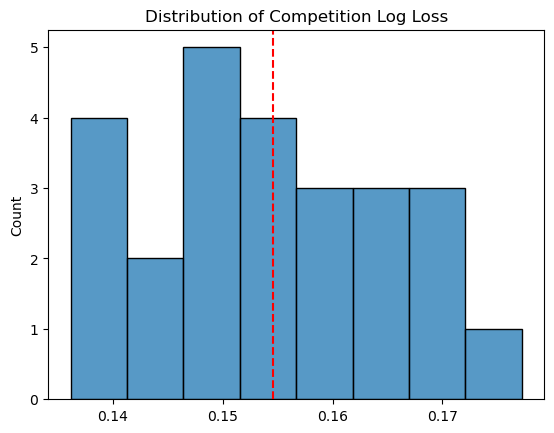

In [25]:
# plotting the distribution of competition log loss

sns.histplot(balance_score, bins=8)

plt.axvline(x=np.mean(balance_score), color='red', linestyle='--', label='s')
plt.title("Distribution of Competition Log Loss")
plt.show()

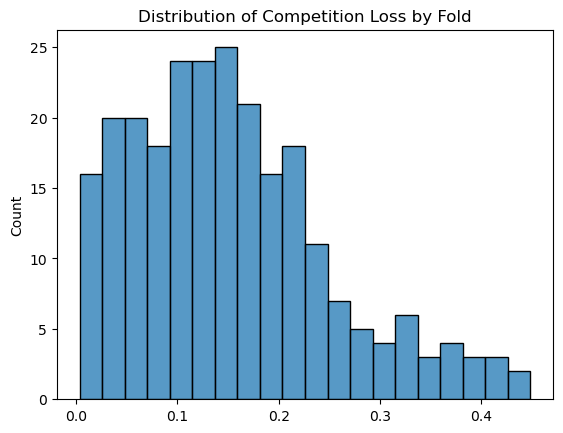

In [26]:
# examing scores by folds to see if there are any patterns
# in when the model learns poorly

sns.histplot(pd.Series(fold_scores), bins=20)
plt.title("Distribution of Competition Loss by Fold")
plt.show()

In [27]:
# every out of fold prediction for every patient

patient_preds = (pd.DataFrame(np.vstack(oofs)).T)
patient_preds['avg_pred'] = patient_preds.mean(axis=1)
patient_preds['median_pred'] = patient_preds.median(axis=1)
patient_preds['std_pred'] = patient_preds.std(axis=1)
patient_preds['min_pred'] = patient_preds.min(axis=1).round(5)
patient_preds['max_pred'] = patient_preds.max(axis=1)
patient_preds['y'] = y

In [28]:
competition_log_loss(y, patient_preds['median_pred'])

0.1344114583496523

In [29]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(patient_preds['y'], patient_preds['median_pred'], n_bins=20)

def plot_calibration(pred_limit=1):
    
    y_ = patient_preds.query("avg_pred <= 1")['y']
    x_ = patient_preds.query("avg_pred <= 1")['avg_pred']
                            
    prob_true_, prob_pred_ = calibration_curve(y_, x_, n_bins=20)
    
    fig, ax = plt.subplots()
    
    ax.set_ylim([0, 1])
    
    ax.errorbar(x=prob_pred_, y=prob_true_, yerr=abs(prob_true_ - prob_pred_) * 0.4, fmt=".k", label='Actual')    
    sns.scatterplot(x=prob_pred_, y=prob_true_)
    
    
    sns.lineplot(x=np.linspace(0, 1, 25), y=np.linspace(0, 1, 25), linestyle='--', label='Perfect Calibration')
    
    plt.title("Calibration Curve of Base Model")
    
    plt.show()

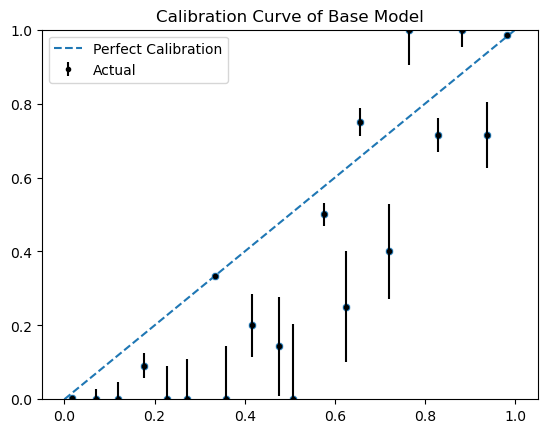

In [30]:
plot_calibration(pred_limit=1)

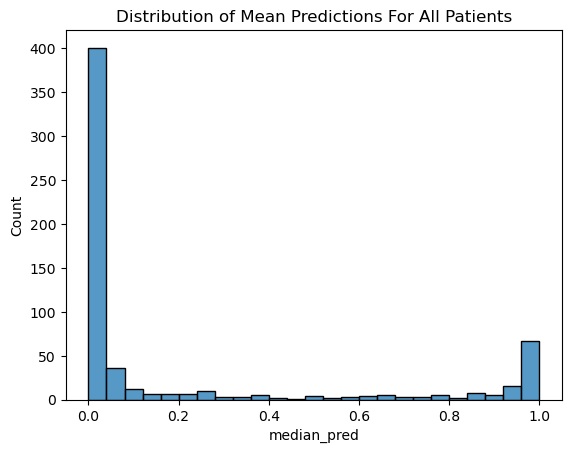

In [31]:
sns.histplot(patient_preds['median_pred'], bins=25)
plt.title("Distribution of Mean Predictions For All Patients")
plt.show()

Clearly most of our predictions are under 0.2. 

In [35]:
# creating a nested calibration cell

nested_fold = KFold(n_splits=10, shuffle=True)
X = train_df.drop(columns=['EJ']).copy()
y = train_df['Class'].values
outside_oof = np.zeros(len(X))

for i, (train_outer, val_outer) in enumerate(nested_fold.split(X, y)):
    
    # multilabel stratification
    ml_skf = MultilabelStratifiedKFold(n_splits=10, shuffle=True)
    
    # creating the outer training set that will be split for 
    # inner cross-validation
    X_train_outer = X.iloc[train_outer].copy()
    y_train_outer = y[train_outer]
    
    # creating the outer validation set that'll be used to generate
    # oof predictions
    X_val_outer = X.iloc[val_outer].copy()
    y_val_outer = y[val_outer]
    
    # filtering the greek df to only those rows in the train set
    greek_outer = greek_df.iloc[train_outer, 1:-1].copy()
    
    inner_oof = np.zeros(len(X_train_outer))

    models = {}
    oof = np.zeros(len(X))

    for j, (train, val) in enumerate(ml_skf.split(X_train_outer, greek_outer)):
        
        # the inner cross-validation loop       
 
        train_x = X_train_outer.iloc[train].drop(columns=['Id', 'Class']).copy()
        train_y = y_train_outer[train]

        # getting the id values
        val_x = X_train_outer.iloc[val].drop(columns=['Id', 'Class']).copy()
        val_y = y_train_outer[val]

        model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 5000,
                           early_stopping_rounds=300,
                           subsample=0.7,
                           colsample_bytree=0.6,
                           max_depth=8,
                           class_weight='balanced',
                           metric='None',
                           is_unbalance=True)

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric=lgb_metric, verbose=False) 
        

        preds = model.predict_proba(val_x)[:,1]
        inner_oof[val] = preds
        
        # getting the score and saving the model
        score = competition_log_loss(val_y, preds)        
        models[f'model_{i}_{j}'] = model

    # generating the out of fold predictions using the models 
    # from the inner loop
    out_preds = []
    for key in models.keys():
        model_ = models[key]
        features = model_.feature_name_
        outer_pred_ = model_.predict_proba(X_val_outer[features])[:,1]
        out_preds.append(outer_pred_)
    
    # here we're using the *median* value of the model
    # predictions
    outside_oof[val_outer] = np.median(np.vstack(out_preds).T, axis=1)

In [36]:
print("competition loss on the nested val set:", 
      competition_log_loss(y, outside_oof))

competition loss on the nested val set: 0.40479298140179654


In [ ]:
importances = []
fi_df = train_df.drop(columns=['Id']).copy()

cv = StratifiedKFold(n_splits=10, shuffle=True)

data = Dataset(df=fi_df, target="Class", features=[col for col in fi_df.columns if col not in ['Class', 'AF', 'FL', 'EJ', 'FE', 'DI']])

model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 888,
                           random_state=42,
                           subsample=0.6970532011679706,
                           colsample_bytree=0.6055755840633003,
                           max_depth=8,
                           class_weight='balanced',
                           is_unbalance=True)

lofo_imp = LOFOImportance(data, cv=cv, scoring=custom_score, model=model)
importance_df = lofo_imp.get_importance()

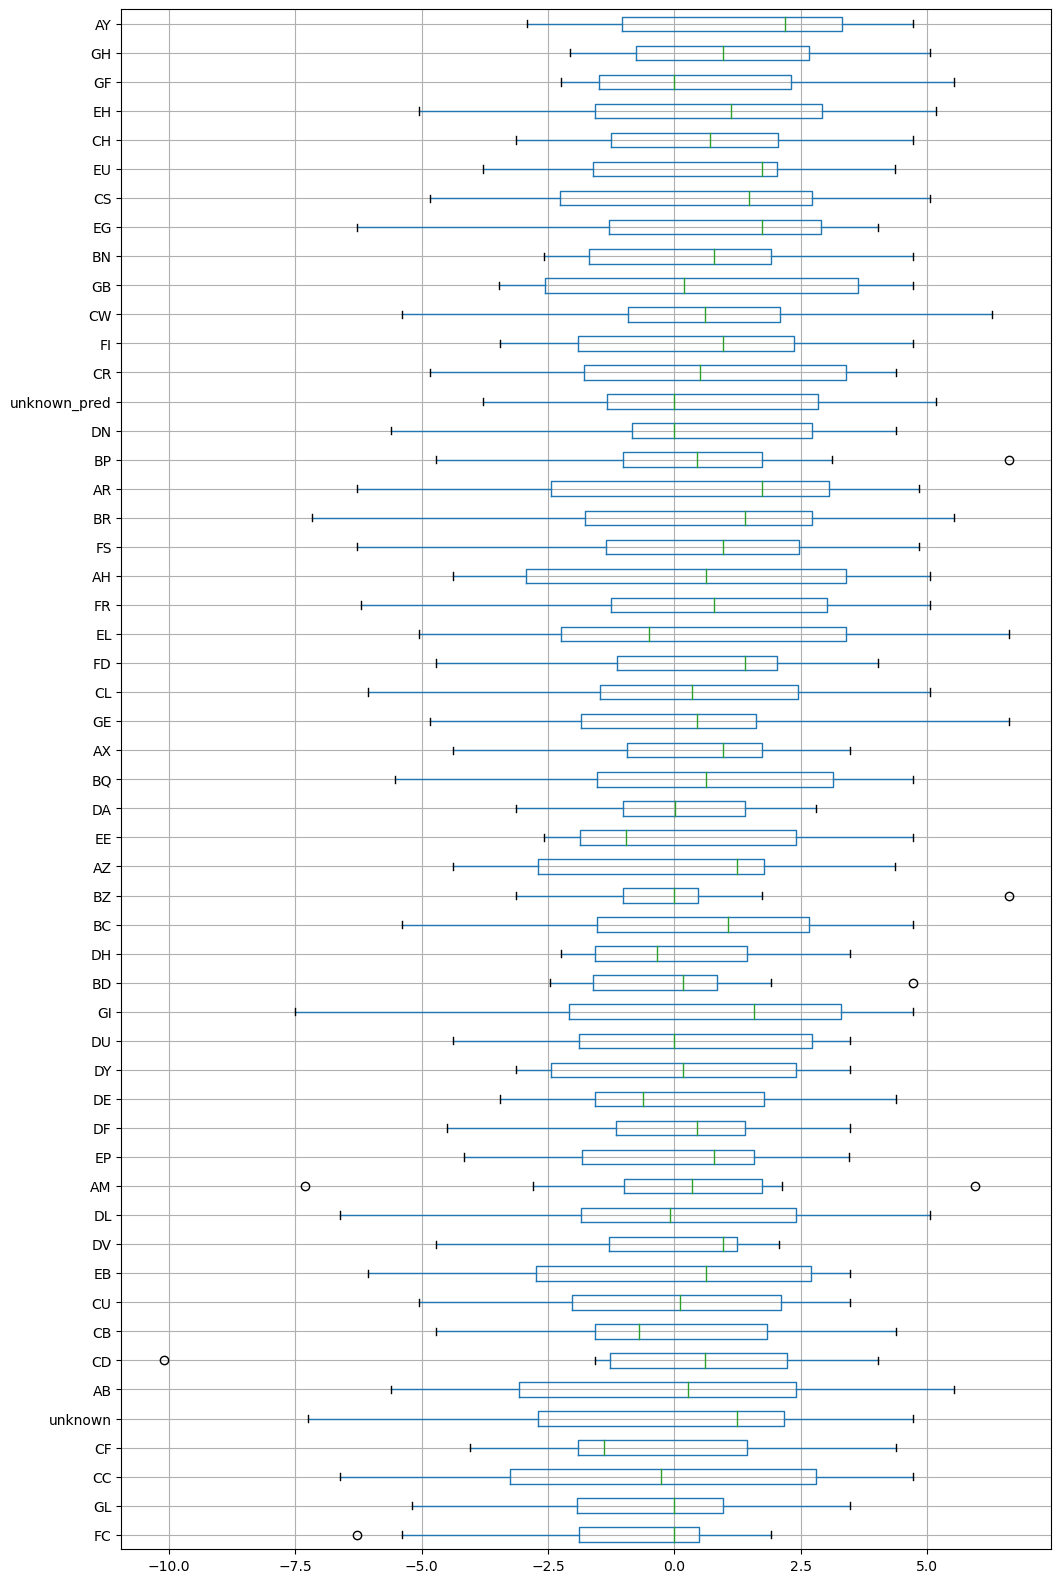

In [304]:
plot_importance(importance_df, figsize=(12, 20), kind='box')

In [403]:
model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 888,
                           random_state=42,
                           subsample=0.6970532011679706,
                           colsample_bytree=0.6055755840633003,
                           max_depth=8,
                           class_weight='balanced',
                           is_unbalance=True)

In [320]:
from sklearn.calibration import IsotonicRegression
from sklearn.model_selection import LeaveOneOut

iso_cv = LeaveOneOut()

oof_calib = np.zeros(len(train_df))

X = patient_preds['mean_prediction']
y = patient_preds['actual']

for i, (train, val) in enumerate(iso_cv.split(X, y)):
    
    train_x = X[train]
    train_y = y[train]
    
    val_x = X[val]
    val_y = y[val]
    
    preds = []
    
    for v in val_x:
        iso_model1 = IsotonicRegression(out_of_bounds='clip')
        train_x_1 = np.concatenate([train_x, np.array([v])])
        train_y_1 = np.concatenate([train_y, [1]])
    
        iso_model1.fit(train_x_1, train_y_1)
    
        iso_model0 = IsotonicRegression(out_of_bounds='clip')
        train_x_0 = np.concatenate([train_x, np.array([v])])
        train_y_0 = np.concatenate([train_y, [0]])
    
        iso_model0.fit(train_x_0, train_y_0)
    
        pred_1 = iso_model1.predict(np.atleast_2d(v))
        pred_0 = iso_model0.predict(np.atleast_2d(v))
    
        final_pred = (0.5 * pred_1) + (0.5 * pred_0)
        
    preds.append(final_pred)
    
    oof_calib[val] = preds

In [414]:
from sklearn.feature_selection import RFECV

eliminated_list = []

for n in range(5):
    rc_spl = StratifiedKFold(n_splits=10, shuffle=True)

    rfecv = RFECV(
        estimator=model,
        step=0.1,
        cv=rc_spl,
        scoring="neg_log_loss",
    )
    rfecv.fit(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon', 'unknown_pred']), y)
    
    features_to_eliminate = rfecv.feature_names_in_[~rfecv.support_]
    eliminated_list.append(features_to_eliminate)

In [ ]:
counts = {}
elim_features = set(np.concatenate(eliminated_list))


for feature in np.concatenate(eliminated_list):
    if feature not in counts:
        counts[feature] = 1
    else:
        counts[feature] += 1

In [97]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
X = train_df.drop(columns=['EJ', 'unknown', 'Epsilon', 'AH', 'AR', 
                           'AY', 'AZ', 'BN', 'BR', 'BZ', 'DF', 'DV',
                           'Id', 'Class']).copy()

y = train_df['Class'].values

X = X.fillna(X.median())

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)



In [95]:
def tf_competition_log_loss(y_true, y_pred):
    # Calculate the number of observations for each class
    N_0 = tf.reduce_sum(1 - y_true)
    N_1 = tf.reduce_sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = tf.clip_by_value(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -tf.reduce_sum((1 - y_true) * tf.math.log(p_0)) / N_0
    log_loss_1 = -tf.reduce_sum(y_true * tf.math.log(p_1)) / N_1
    # Return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1) / 2

In [115]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
oof = np.zeros(len(X_scaled))

for i, (train, val) in enumerate(skf.split(X_scaled, y)):
    train_x = X_scaled[train]
    train_y = y[train]

    val_x = X_scaled[val]
    val_y = y[val]




    cnn_model = tf.keras.Sequential()

    cnn_model.add(layers.Dense(256, activation='relu'))
    cnn_model.add(layers.Reshape((32, 8)))
    cnn_model.add(layers.Conv1D(12, 2))
    cnn_model.add(layers.Conv1D(4, 2))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(12, activation='relu'))  
    cnn_model.add(layers.Dense(4, activation='relu'))
    cnn_model.add(layers.Dense(1, activation='sigmoid')) 

    cnn_model.compile(loss='binary_crossentropy', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    cnn_model.fit(train_x, train_y, validation_data=[val_x, val_y], callbacks=[early_stopping], epochs=500)

    preds = cnn_model.predict(val_x).flatten()

    oof[val] = preds

TypeError: __init__() got an unexpected keyword argument 'metrics'

In [113]:
competition_log_loss( y, oof)

0.4211988021402058